In [1665]:
'''
File name: Gender_gap_evolution.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 29/11/2022
Date last modified: 23/12/2022
Python version: 3.8.8
'''

'\nFile name: Gender_gap_evolution.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 29/11/2022\nDate last modified: 23/12/2022\nPython version: 3.8.8\n'

# The evolution of the gender gap in the film industry

Our goal with this work is to analyze the evolution in time of sexism and women discrimination in the film industry, which is known as one of the least women-friendly industries: [almost 9 in 10 films (89%) have more men in their 10 or so most senior roles, both acting and non-acting](https://www.bbc.com/culture/article/20180508-the-data-that-reveals-the-film-industrys-woman-problem). The #MeToo movement, known for its apogee in 2017 with the complaints of many known actresses about the sexism and assaults in the film industry, appeared in reality in 2007. It made less noise back then, but it was present and in many fields. The premises of free speech and liberation about the harassment, assault and rape culture women were suffering of, were launched. We want to tell the story of those women, particularly in the film industry, who suffer from daily discrimination. We want to have a look at the gender gap and how it has evolved in time, especially after the appearance of the #MeToo movement? Finally, the goal is to assess whether this movement has had a real impact on the situation.

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Data](#Data)\
        C. [Imports](#Imports)\
        D. [Paths](#Paths)

1. [Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Pre-processing](#Pre-pro)\
        B. [Other datatsets pre-processing](#Other_ds)\
        C. [First insights on gender gap](#First_insights)

2. [Box office revenues, salaries](#Box_Office)
3. [Evolution of women representation ](#Evolution)\
        A. [Are women present?] (#Presence)\
        B. [What are women associated with? How do we talk about these women?] (#Association)\
        C. [What kind of roles and jobs women do are the most appreciated? In which context do people like to see women?] (#Roles)\
        D. [How do women interact, with other women and with men?] (#Interaction)
4. [Conclusion](#Conclusion)


---
# 0. General Information <a id="GI"> </a> 

## A. Folder structure <a id="Folder"> </a>

## B. Data <a id="Data"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
    - *oscar_winners.csv*
    - *movie_appreciation_metadata.csv*
    - *title.ratings.tsv*
    - *title.basics.tsv*
    


- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.

`movie.metadata.tsv.gz` [3.4 M]

Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`name.clusters.txt`

970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`plot_summaries.txt` [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


`tvtropes.clusters.txt`

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`corenlp_plot_summaries.tar` [628 M, separate download]

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

`oscar.winners.csv` [794 K]

Oscar winners in every field for the last years.


`title.basics.txt` [807.6 M]

Title of movies linked to their alphanumeric unique identifier, from IMDb interface.


`title.ratings.txt` [21.7 M]

Ratings and number of votes for movies, from IMDb interface.


## C. Imports <a id="Imports"> </a>

***Libraries used for milestone 2:***
- python=3.8.12
- pandas
- ast
- datetime
- seaborn
- numpy
- matplotlib
- json

In [1666]:
#Imports used in this notebook
from datetime import datetime

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json as js 
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import gmean
from scipy.stats import bootstrap
from scipy.stats import skew, skewtest
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.regressionplots import abline_plot
from causalgraphicalmodels import CausalGraphicalModel
from matplotlib.pyplot import figure
import fuzzywuzzy

## D. Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [1667]:
### PATHs for dataset:
PATH_DATA = 'data/'

PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'
PATH_NAME_CLUSTERS=PATH_DATA+'name.clusters.txt'
PATH_TV_TROPES_CLUSTERS=PATH_DATA+'tvtropes.clusters.txt'

#additionnal datasets:
PATH_MOVIE_OSCAR_WINNERS = PATH_DATA+'oscar_winners.csv'
PATH_TITLE_BASICS = PATH_DATA+'title.basics.tsv'
PATH_TITLE_RATINGS = PATH_DATA+'title.ratings.tsv'


---
#  1. Data scraping, pre-processing and dataset construction<a id="Step-1"> </a>

## A. Pre-processing <a id="#Pre-pro"> </a>

In [1668]:
def dict_to_cols(row): 
    '''
    Allows to transform the dictionnary into a dataframe with multiple columns.
    :param row : row to transform
    :return : 
    '''
    d = js.loads(row[1])
    return row[0], *list(d.values())

def dict_to_lst(stri):
    '''
    Allows to transform a dictionnary into a list of features.
    :param stri : 
    :return : list of features
    '''
    dict = ast.literal_eval(stri)
    lst  = list(dict.values())
    return lst

First we will properly name each column of  in order to manipulate in an easier way

In [1669]:
print("Reading in movie data")


movie_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue',
                 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
plot_headers = ['Wikipedia_movie_ID','Plot_Summary']
character_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID','Movie_release_date','Character_name','Actor_date_of_birth',
                     'Actor_gender','Actor_height','Actor_ethnicity','Actor_name','Actor_age_at_movie_release',
                     'Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
name_clusters_headers=['Character_name', 'Freebase_movie_ID']
tv_tropes_cluster_headers=['Trope','Character_name','movie','id','actor']
new_cols_apprec=['movie_title','director name','duration','country','actor_1_name','actor_2_name','actor_3_name',
                    'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
                    'director_facebook_likes','gross','genres','num_voted_users','cast_total_facebook_likes',
                    'facenumber_in_poster','num_user_for_reviews','content_rating','budget',
                    'title_year','imdb_score','aspect_ratio'
                    ]

# Read in movie metadata, plot summaries, and character metadata.
movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia_movie_ID')
name_clusters=pd.read_csv(PATH_NAME_CLUSTERS,sep='\t',header=None,names=name_clusters_headers,index_col='Freebase_movie_ID')
tv_tropes_clusters = pd.read_csv(PATH_TV_TROPES_CLUSTERS,sep='\t',header=None).apply(dict_to_cols, axis=1, result_type='expand')

# Read in additionnal datasets
movie_oscar_winners=pd.read_csv(PATH_MOVIE_OSCAR_WINNERS,header=0)
IMDb_basics=pd.read_csv(PATH_TITLE_BASICS,sep='\t',header=0,index_col=0, dtype={'isAdult': str}) #define dtype of isAdult to avoid warning on reading
IMDb_ratings=pd.read_csv(PATH_TITLE_RATINGS,sep='\t',header=0, index_col=0)

# Cleaning datasets
tv_tropes_clusters.columns = tv_tropes_cluster_headers
tv_tropes_clusters.set_index('id')
movie_metadata['Movie_languages']=movie_metadata['Movie_languages'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_countries']=movie_metadata['Movie_countries'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_genres']=movie_metadata['Movie_genres'].apply(lambda x: dict_to_lst(x))

# Cleaning for the additionnal dataset
movie_oscar_winners=movie_oscar_winners.replace('1927/1928','1928').replace('1928/1929','1929').replace(
    '1929/1930','1930').replace('1930/1931','1931').replace('1931/1932','1932').replace('1932/1933','1933')
IMDb_basics = IMDb_basics.drop(['isAdult','endYear','runtimeMinutes'], axis=1)

"""
# Displaying the datasets
display(movie_metadata.head())
display(plot_summaries.head())
display(character_metadata.head())
display(name_clusters.head())
display(tv_tropes_clusters.head())
display(movie_appreciation_metadata.head())
display(movie_oscar_winners.head())
display(IMDb_basics.head())
display(IMDb_ratings.head())
"""

Reading in movie data


'\n# Displaying the datasets\ndisplay(movie_metadata.head())\ndisplay(plot_summaries.head())\ndisplay(character_metadata.head())\ndisplay(name_clusters.head())\ndisplay(tv_tropes_clusters.head())\ndisplay(movie_appreciation_metadata.head())\ndisplay(movie_oscar_winners.head())\ndisplay(IMDb_basics.head())\ndisplay(IMDb_ratings.head())\n'

In [1670]:
n_movie = len(movie_metadata)
n_summaries = len(plot_summaries)
n_char = len(character_metadata)
n_name_clusters = len(name_clusters)
n_tropes_clusters = len(tv_tropes_clusters)
n_osc = len(movie_oscar_winners)
n_IMDb = len(IMDb_basics)
n_ratings = len(IMDb_ratings)



print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the plot_summaries dataset : %d' %n_summaries)
print('Number of rows in the character.metadata dataset : %d' %n_char)
print('Number of rows in the name.clusters dataset : %d' %n_name_clusters)
print('Number of rows in the movie_oscar_winners dataset : %d' %n_osc)
print('Number of rows in the title.basics dataset : %d' %n_IMDb)
print('Number of rows in the ratings.basics dataset : %d' %n_ratings)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the plot_summaries dataset : 42303
Number of rows in the character.metadata dataset : 450669
Number of rows in the name.clusters dataset : 2666
Number of rows in the movie_oscar_winners dataset : 9964
Number of rows in the title.basics dataset : 9430996
Number of rows in the ratings.basics dataset : 1254849


We have extracted the data. Preprocessing needs to be done now.

`movie.metadata.tsv`

Firstly, the movie release dates are not standardized: some are in a year-month-day format and some only have the release year. Secondly, for some of the columns (Movie languages, Movie countries, and Movie genres) the way we the data is presented might not be the best (dictionary with ID and actual "value).
We also need to look for any column containing NaN values and see what we want to do with these missing values. Depending on what data we need for each of our research axis, we might deal differently with NaNs.

We can see that some values are missing, movie languages, movie countries and movie genres are lists. Also the dates don't all have the same format, in fact, some are missing the month and day. 

In [1671]:
movie_metadata.head()

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [1672]:
movie_metadata.describe()

,Movie_box_office_revenue,Movie_runtime
count,8.401000e+03,6.129100e+04
mean,4.799363e+07,1.118192e+02
std,1.121753e+08,4.360070e+03
min,1.000000e+04,0.000000e+00
25%,2.083193e+06,8.100000e+01
50%,1.063969e+07,9.300000e+01
75%,4.071696e+07,1.060000e+02
max,2.782275e+09,1.079281e+06


First of all, we make an inspection of the dataframes, to see wether there exist some duplicates, NaN values etc... 

In [1673]:
movie_metadata.index.is_unique

True

In [1674]:
movie_metadata.isna().any()

Freebase_movie_ID           False
Movie_name                  False
Movie_release_date           True
Movie_box_office_revenue     True
Movie_runtime                True
Movie_languages             False
Movie_countries             False
Movie_genres                False
dtype: bool

Here is a more visual way to see which columns of the dataset contain missing entries. Such that, every white line is a missing value of the dataset.

Sum of NaN in each feature : 


Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64

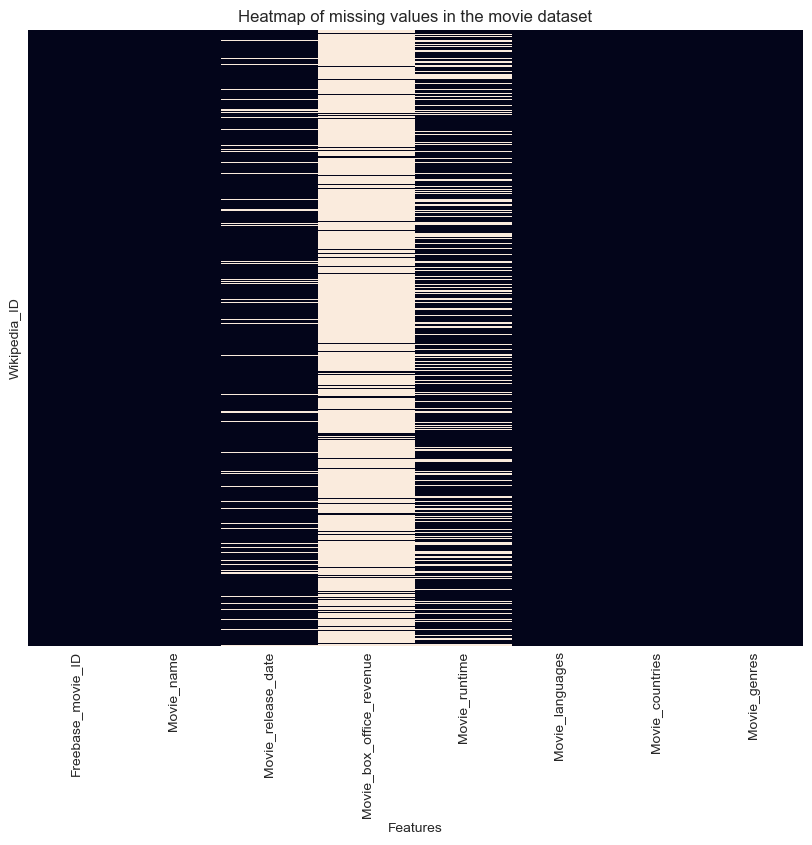

In [1675]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the movie dataset')

print('Sum of NaN in each feature : ')
movie_metadata.isna().sum(axis = 0)

In [1676]:
n_movie=len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime']].isna().sum() / n_movie)
movie_metadata

Percentage of missing entries in the movie.metadata dataset:
 Movie_release_date           8.443743
Movie_box_office_revenue    89.722416
Movie_runtime               25.018045
dtype: float64


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"


In [1677]:
print("What is need to be processed")
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie_runtime']<=0]))

What is need to be processed
Rows with movie runtime under or equal to 0: 1


In [1678]:
movie_metadata.drop(movie_metadata[movie_metadata['Movie_runtime']==0].index, inplace=True)

For the `movie_ metadata` dataset, we need to check duplicated depending on rows. As we don't want for example the same movie with different Movie release dates, or different Freebase movie IDs.

In [1679]:
#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Freebase_movie_ID has 0 duplicated rows
Movie_name has 6263 duplicated rows
Movie_release_date has 61350 duplicated rows
Movie_box_office_revenue has 74377 duplicated rows
Movie_runtime has 81143 duplicated rows
Movie_languages has 79923 duplicated rows
Movie_countries has 79616 duplicated rows
Movie_genres has 57923 duplicated rows


We can see that there are 6263 movies with the same title. This could be concerning. However, as no movie has the same Wikipedia movie ID or Freebase movie ID, we could assume that these title duplications are only movies with the same title and not the same movie just duplicated.

In [1680]:
#one movie has a release year that is obviously false 
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-02. We correct this.

In [1681]:
movie_metadata.loc[movie_metadata['Movie_release_date'] == '1010-12-02','Movie_release_date'] = '2010-12-02'

In [1682]:
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,2010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We see that some of the Movie release dates only contain the year and not the full year-month-day date so we correct this to have a standardized way of having our Movie release dates.

In [1683]:
#Adding Year-01-01 for movies only including a year for the dates
movie_metadata["Movie_release_date"] = pd.to_datetime(movie_metadata["Movie_release_date"],errors='coerce') 
movie_metadata.head()

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [1684]:
character_metadata["Movie_release_date"] = pd.to_datetime(character_metadata["Movie_release_date"],errors='coerce')
character_metadata.head()

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


The last film in our dataframe was released in 2016 and the first one in 1888


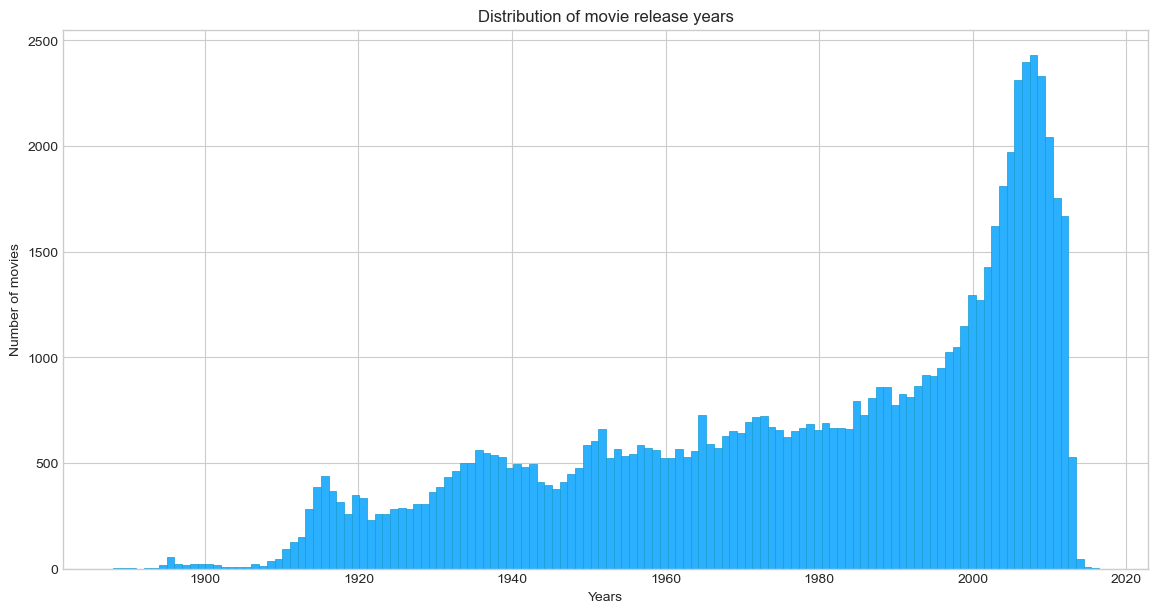

In [1685]:
print('The last film in our dataframe was released in', movie_metadata.Movie_release_date.max().year,'and the first one in',movie_metadata.Movie_release_date.min().year)

num_years=(movie_metadata.Movie_release_date.max().year-movie_metadata.Movie_release_date.min().year)

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(movie_metadata['Movie_release_date'],bins=num_years, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Distribution of movie release years') 
plt.xlabel('Years') 
plt.ylabel('Number of movies') 
plt.show()

As we can see the first film seems to have been released in 1888, it is in fact a short sequence of less than 3 seconds. But for our analysis it isn't releavant. Even if there is a debate on which is the fisrt "real movie" we will consider that it is "A trip to the Moon", which is often taught at school. So we will consider movies starting from 1902, and this seems relevant in view of the plot above! 

Source: https://www.studiobinder.com/blog/what-was-the-first-movie-ever-made/

In [1686]:
movie_metadata=movie_metadata[~(movie_metadata['Movie_release_date'] <= '1902-01-01')]

We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis. For the release dates and runtime we could discard the rows with missing values but it could be interesting to check if the rows discarded contain on average more or less lead women characters  or women directors so that we don't overlook any data.

`plot_summaries.txt`

In [1687]:
print("Reading in summaries data")
plot_summaries.head()

Reading in summaries data


,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [1688]:
plot_summaries.describe()

,Plot_Summary
count,42303
unique,42295
top,A woman is thrown out of her home by her jealo...
freq,5


In [1689]:
plot_summaries.index.is_unique

True

In [1690]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot_Summary    0
dtype: int64

The summary dataset seems to be relatively clean in term of completeness of information.

We check for duplicated rows in the `plot_summaries` dataset as we don't want duplicates. We do not need to check for specific features duplicated as it could be possible and would not be a problem

In [1691]:
print("Duplicated rows in the plot_summaries dataset : {}".format(plot_summaries.duplicated().sum()))

Duplicated rows in the plot_summaries dataset : 8


In [1692]:
plot_summaries.drop_duplicates(inplace=True, keep='first')

`character.metadata.tsv`

In [1693]:
print("Reading in character data")
character_metadata.head()

Reading in character data


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [1694]:
character_metadata.describe()

,Actor_height,Actor_age_at_movie_release
count,154824.000000,292556.000000
mean,1.788893,37.788523
std,4.379940,20.587870
min,0.610000,-7896.000000
25%,1.676400,28.000000
50%,1.750000,36.000000
75%,1.830000,47.000000
max,510.000000,103.000000


In [1695]:
character_metadata.isna().any()

Freebase_movie_ID                  False
Movie_release_date                  True
Character_name                      True
Actor_date_of_birth                 True
Actor_gender                        True
Actor_height                        True
Actor_ethnicity                     True
Actor_name                          True
Actor_age_at_movie_release          True
Freebase_character_actor_map_ID    False
Freebase_character_ID               True
Freebase_actor_ID                   True
dtype: bool

Sum of NaN in each feature : 


Freebase_movie_ID                       0
Movie_release_date                  10010
Character_name                     257875
Actor_date_of_birth                106145
Actor_gender                        45609
Actor_height                       295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64

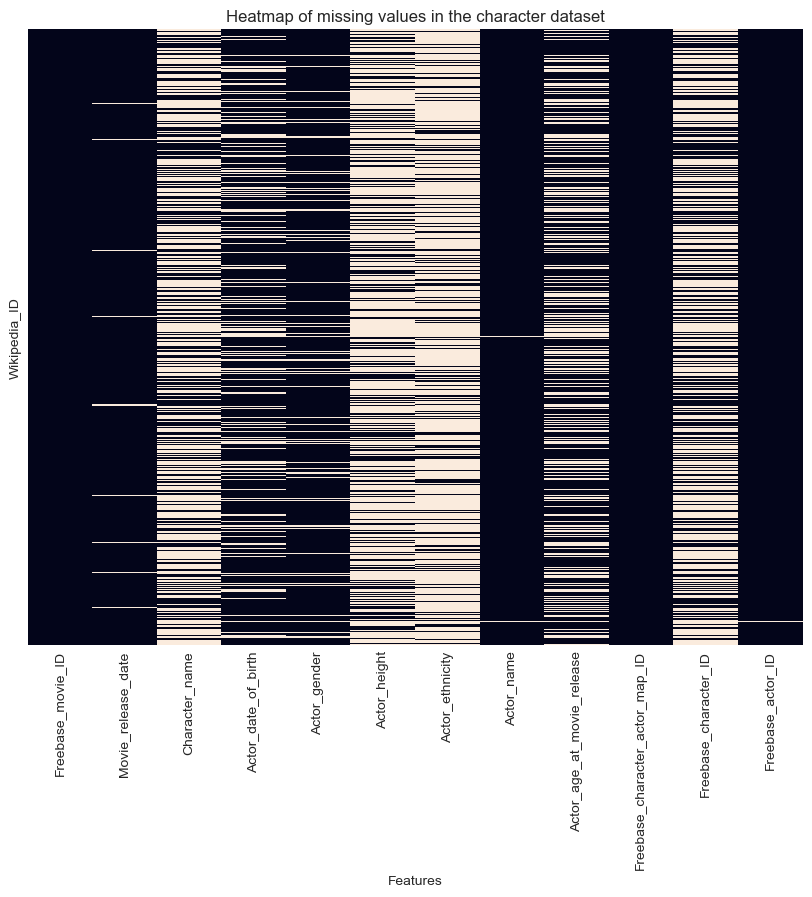

In [1696]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(character_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the character dataset')
print('Sum of NaN in each feature : ')
character_metadata.isna().sum(axis = 0)

The white lines stand for missing values.

In [1697]:
n_char=len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase_movie_ID', 'Movie_release_date', 'Character_name',
                                                                                   'Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity',
                                                                                   'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_ID',
                                                                                   'Freebase_actor_ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase_movie_ID              0.000000
Movie_release_date             2.221142
Character_name                57.220488
Actor_date_of_birth           23.552763
Actor_gender                  10.120288
Actor_height                  65.645740
Actor_ethnicity               76.466542
Actor_name                     0.272484
Actor_age_at_movie_release    35.084064
Freebase_character_ID         57.218269
Freebase_actor_ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially. For the other features we need to figure out if they are relevant to our analysis, and if so, need to decide wheter we want to discard the rows containing NaNs or try and find the information elsewhere.

In [1698]:
character_dropna = character_metadata.dropna()
character_dropna.head()

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
2314463,/m/0734w5,2006-01-01,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


In [1699]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_age_at_movie_release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_height']<=0]))
character_metadata

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957-01-01,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


In [1700]:
#putting the absolute value for the actor's ages that are negative
character_metadata['Actor_age_at_movie_release']=character_metadata['Actor_age_at_movie_release'].abs()

In [1701]:
#dropping the actor ages
character_metadata.drop(character_metadata[character_metadata['Actor_age_at_movie_release']==0].index, inplace=True)

We check for duplicated rows in the `character.metadata` dataset as we don't want duplicates. We do not need to check for specific features duplicated as it could be possible and would not be a problem

In [1702]:
print("Duplicated rows in character.metadata dataset : {}".format(character_metadata.duplicated().sum()))

Duplicated rows in character.metadata dataset : 0



## B. Other datatsets pre-processing <a id="#Other_ds"> </a>

`oscar_winners.csv`

In [1703]:
movie_oscar_winners.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [1704]:
movie_oscar_winners.describe()

,Ceremony,Winner
count,9964.000000,2321.0
mean,45.471798,1.0
std,24.841392,0.0
min,1.000000,1.0
25%,23.000000,1.0
50%,44.000000,1.0
75%,68.000000,1.0
max,88.000000,1.0


In [1705]:
movie_oscar_winners.isna().any()

Year        False
Ceremony    False
Award       False
Winner       True
Name        False
Film         True
dtype: bool

We do not consider the column 'winner' as it contains indicators (1 and 0) to check wether a movie, an actor or a director has won the oscar. 

Sum of NaN in each feature : 


Year          0
Ceremony      0
Award         0
Name          0
Film        333
dtype: int64

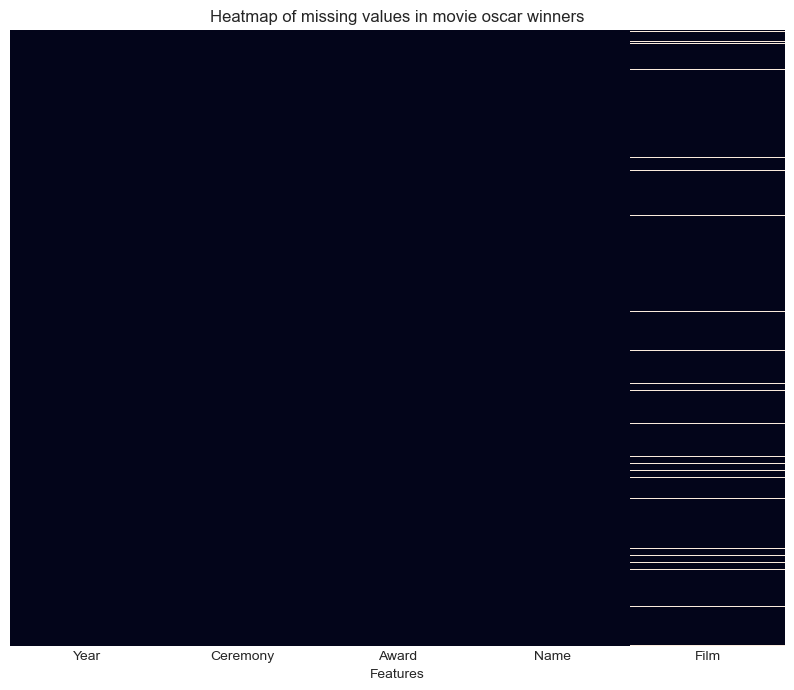

In [1706]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="")
ax.set_title('Heatmap of missing values in movie oscar winners')
print('Sum of NaN in each feature : ')

movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna().sum(axis = 0)

`title.basics.tsv`

In [1707]:
IMDb_basics.head()

,titleType,primaryTitle,originalTitle,startYear,genres
tconst,,,,,
tt0000001,short,Carmencita,Carmencita,1894,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,1892,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,1892,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,1892,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,1893,"Comedy,Short"


In [1708]:
IMDb_basics.describe()

,titleType,primaryTitle,originalTitle,startYear,genres
count,9430996,9430985,9430985,9430996,9430986
unique,11,4309602,4330505,151,2333
top,tvEpisode,Episode #1.1,Episode #1.1,\N,Drama
freq,7127515,46013,46013,1264000,1072166


We drop duplicated rows, but not on a specific feature. NaN values will be treated later if needed when merging with other datasets of interest.

In [1709]:
IMDb_basics=IMDb_basics.drop_duplicates()
IMDb_basics.isna().any()

titleType        False
primaryTitle      True
originalTitle     True
startYear        False
genres            True
dtype: bool

`title.ratings.tsv`

In [1710]:
IMDb_ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.7,1924
tt0000002,5.8,261
tt0000003,6.5,1740
tt0000004,5.6,176
tt0000005,6.2,2554


In [1711]:
IMDb_ratings.describe()

,averageRating,numVotes
count,1.254849e+06,1.254849e+06
mean,6.953103e+00,1.041876e+03
std,1.387213e+00,1.729181e+04
min,1.000000e+00,5.000000e+00
25%,6.200000e+00,1.200000e+01
50%,7.200000e+00,2.600000e+01
75%,7.900000e+00,1.020000e+02
max,1.000000e+01,2.668376e+06


In [1712]:
IMDb_ratings=IMDb_ratings.drop_duplicates()
IMDb_ratings=IMDb_ratings.dropna()
IMDb_ratings.isna().any()
print('The length of the IMDb ratings dataset is', len(IMDb_ratings))

The length of the IMDb ratings dataset is 119899


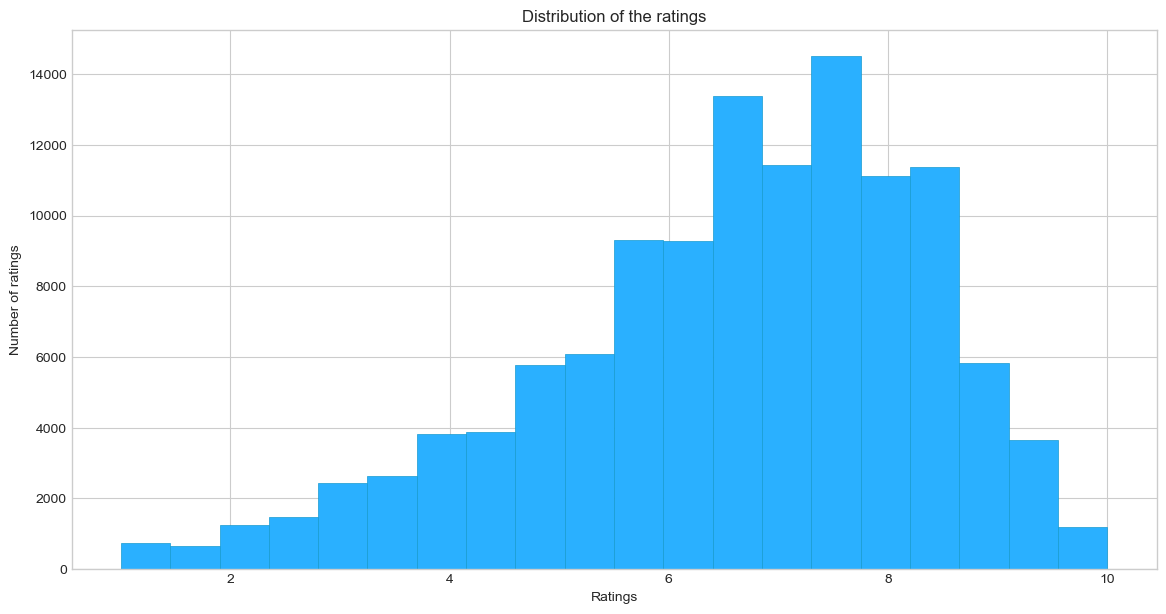

In [1713]:
num_ratings=20

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(IMDb_ratings['averageRating'], bins=num_ratings, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Distribution of the ratings') 
plt.xlabel('Ratings') 
plt.ylabel('Number of ratings') 
plt.show()

To obtain the dataset with ratings and the associated movie titles, we merge the IMDb_basics dataset with the IMDb_ratings dataset.

In [1714]:
IMDb_ratings=IMDb_ratings.merge(IMDb_basics, on='tconst', how='left').dropna()


The dataset IMDb-ratings after merging with IMDb_basics is the one we are going to use in part 3.C. We decide to only consider the original title as the title of the film, and to drop the primary title.

In [1715]:
IMDb_ratings = IMDb_ratings.drop(['primaryTitle'], axis=1)
IMDb_ratings = IMDb_ratings.rename(columns={'tconst': 'IMDb_ID', 'averageRating': 'IMDb_rating', 'numVotes': 'IMDb_votes', 'originalTitle':'Movie_name','startYear': 'Movie_release_year', 'runtimeMinutes': 'Movie_runtime', 'genres': 'Movie_genres'})

We only keep movies from after 1902, as in the given datasets.

In [1716]:
# only keep rows where titleType = 'movie'
IMDb_ratings = IMDb_ratings[IMDb_ratings['titleType'] == 'movie']
IMDb_ratings = IMDb_ratings[~(IMDb_ratings['Movie_release_year'] <= '1902')]

In [1717]:
IMDb_ratings

,IMDb_rating,IMDb_votes,titleType,Movie_name,Movie_release_year,Movie_genres
tconst,,,,,,
tt0000502,4.2,14,movie,Bohemios,1905,\N
tt0000574,6.0,797,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography"
tt0000591,5.1,20,movie,L'enfant prodigue,1907,Drama
tt0000615,4.3,23,movie,Robbery Under Arms,1907,Drama
tt0000630,2.9,25,movie,Amleto,1908,Drama
...,...,...,...,...,...,...
tt9902160,7.0,3885,movie,Herself,2020,Drama
tt9904802,4.5,1726,movie,Enemy Lines,2020,War
tt9907782,6.2,11447,movie,Eight for Silver,2021,"Fantasy,Horror,Mystery"


## C. First insights on gender gap <a id="First_insights"> </a>

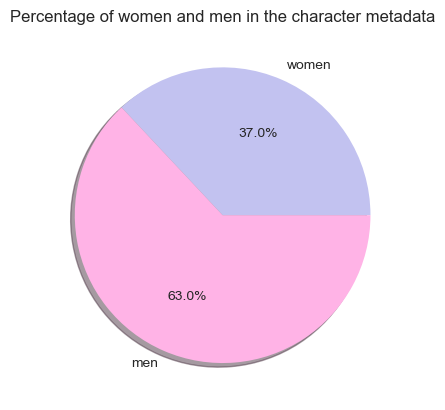

In [1718]:
#Plotting on a pie chart the percentage of women and men in the character metadata
fem_act = character_metadata[character_metadata['Actor_gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [1719]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [1720]:
#new dataframe with movies after 2007 after converting the release date to datetime 

movie_metadata_clean['Movie_release_date'] = pd.to_datetime(movie_metadata_clean['Movie_release_date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie_release_date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
21926710,/m/05p45cv,White on Rice,2009-01-01,0.0,82.0,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]"
20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,0.0,0.0,[Tamil Language],[India],[Romance Film]
29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,0.0,110.0,[Malayalam Language],[India],[Drama]
26623942,/m/0bh9fbk,Kausthubham,2010-03-19,0.0,0.0,[Malayalam Language],[India],[Drama]
32445576,/m/0gyv1h1,Vinayaka Geleyara Balaga,2011-07-15,0.0,0.0,[],[],[]


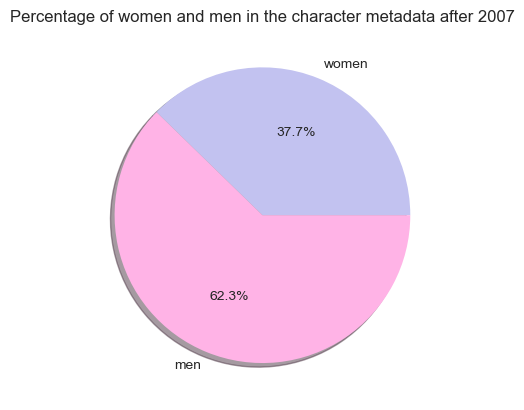

In [1721]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

We can at least see that there's a small increase of 0.7% in the distribution for women on screen after 2007.

In [1722]:
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia_movie_ID')
plot_summaries=plot_summaries.dropna()
plot_summaries.head()

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj


/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1070814605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1070814605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T

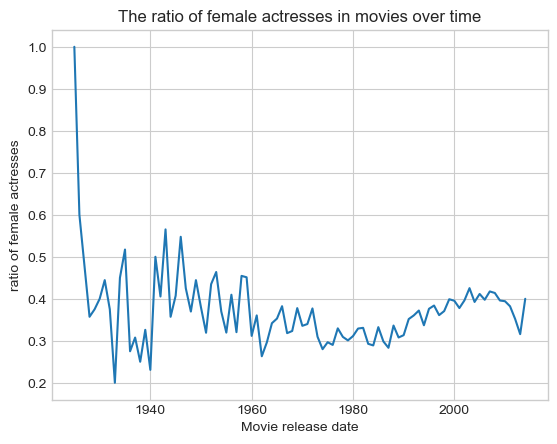

In [1723]:
#create new dataframe where we change movie release date to datetime in plot_summaries
plot_summaries_new = plot_summaries[['Freebase_movie_ID', 'Movie_release_date','Actor_gender']]
plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
plot_summaries_new
#calculate the number of 'F' for every 'Movie release date'
plot_summaries_new = plot_summaries_new.groupby(['Movie_release_date','Actor_gender']).size().reset_index(name='counts')
plot_summaries_new[170:180]
#add the total counts for every 'Movie release date'
plot_summaries_new['total_counts'] = plot_summaries_new.groupby('Movie_release_date')['counts'].transform('sum')
plot_summaries_new
#find the ratio of 'F' counts to total counts for every 'Movie release date'
plot_summaries_new['ratio'] = plot_summaries_new.groupby('Movie_release_date')['counts'].apply(lambda x: x/x.sum())
plot_summaries_new
#only keep the 'F' rows
plot_summaries_new = plot_summaries_new[plot_summaries_new['Actor_gender'] == 'F']
plot_summaries_new
#plot the 'Movie release date' and 'ratio' in a line graph
plt.plot(plot_summaries_new['Movie_release_date'], plot_summaries_new['ratio'])
plt.xlabel('Movie release date')
plt.ylabel('ratio of female actresses')
plt.title('The ratio of female actresses in movies over time')
plt.show()

We can interpret from the graph that the ratio of female actresses is clearly lower than half in the years between 1930 and 2010s where the data is most relevant. So actresses are less present than actors in the movies' main characters. We will keep on analysing this data in the next milestone.

 ---
# 2. Salaries, box office revenues, etc. <a id="Box_Office"> </a>

The gender gap is often referred to as the gender pay gap. This is why our first axis of analysis was done from a financial view.

We start out by visualizing and analyzing what we know about box office revenues.

In [1724]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie_box_office_revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]"
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]"
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]"


In [1725]:
print("{:.2%} of the movies have a missing movie box office revenue value".format(movie_metadata.isnull().sum()['Movie_box_office_revenue']/len(movie_metadata)))

89.70% of the movies have a missing movie box office revenue value


As we see above, a lot of the data on the movie box office revenue is missing. This could be problematic as our analysis will focus solely on a partial amount of our dataset. It might make more sense to look at some kind of rating, such ad IMDb rating, to assess whether the movie was successful or not and to try to make sense of how gender is linked to the success of movies.

In [1726]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie_box_office_revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)
movie_metadata_filt['Movie_release_date'] = pd.to_datetime(movie_metadata_filt['Movie_release_date'],errors='coerce')

In [1727]:
movie_metadata.shape[0]

81529

In [1728]:
movie_metadata_filt.shape[0]

8400

We only have 8400 movies where we have their box office revenue.

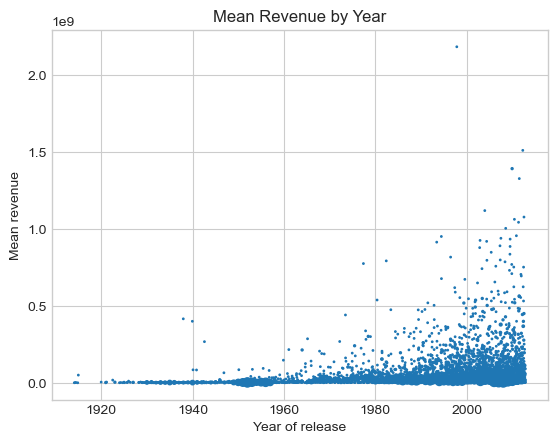

In [1729]:
revenue_year = movie_metadata_filt.groupby("Movie_release_date")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From the movies which we have the box office revenue of, we observe a tendency to rise along the years. This is easily explained by the fact that the movie industry has grown over the years and that it generates more and more money through the years.

In [1730]:
display(character_metadata.head())
display(movie_metadata.head())

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


We merge our character_metadata dataset and our movie_metadata dataset to try and visualize the difference in box office revenues according to the differenct actor's genders.
We do an inner join because there are movies in the movie_metadata dataset for which we do not have any information on the characters in character_metadata and vice versa.
For further analysis, we need information about both the characters and the movies they appear in.

In [1731]:
characters_movie=pd.merge(character_metadata,movie_metadata_filt,left_index=True,right_index=True,how="inner")
characters_movie['Movie_release_date_x'] = pd.to_datetime(characters_movie['Movie_release_date_x'],errors='coerce')
characters_movie.head()

,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Fake shemp,1956,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."


In [1732]:
characters_movie_F = characters_movie[characters_movie['Actor_gender'] == 'F']
characters_movie_M = characters_movie[characters_movie['Actor_gender'] == 'M']

In [1733]:
display(characters_movie_F.head())
display(characters_movie_F.head())

,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.68,/m/07hwkr,Bridget Fonda,28.0,/m/0jtqtq,/m/0h2hxrl,/m/01yd8v,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Sheila,1965-08-11,F,1.73,/m/06v41q,Embeth Davidtz,27.0,/m/0jtqtk,/m/0h36j9w,/m/034b7r,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Possessed Witch,1957-09-04,F,1.75,NaN,Patricia Tallman,35.0,/m/04hzm5r,/m/0hgcnl6,/m/045kf0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3333,/m/0151l,1915-01-01,NaN,1893-10-14,F,1.66,NaN,Lillian Gish,NaN,/m/0k4hhp,NaN,/m/01c2sl,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."
3333,/m/0151l,1915-01-01,NaN,1894-11-09,F,1.60,NaN,Mae Marsh,NaN,/m/0k4hh_,NaN,/m/0735gw,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."


,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.68,/m/07hwkr,Bridget Fonda,28.0,/m/0jtqtq,/m/0h2hxrl,/m/01yd8v,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Sheila,1965-08-11,F,1.73,/m/06v41q,Embeth Davidtz,27.0,/m/0jtqtk,/m/0h36j9w,/m/034b7r,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Possessed Witch,1957-09-04,F,1.75,NaN,Patricia Tallman,35.0,/m/04hzm5r,/m/0hgcnl6,/m/045kf0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3333,/m/0151l,1915-01-01,NaN,1893-10-14,F,1.66,NaN,Lillian Gish,NaN,/m/0k4hhp,NaN,/m/01c2sl,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."
3333,/m/0151l,1915-01-01,NaN,1894-11-09,F,1.60,NaN,Mae Marsh,NaN,/m/0k4hh_,NaN,/m/0735gw,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."


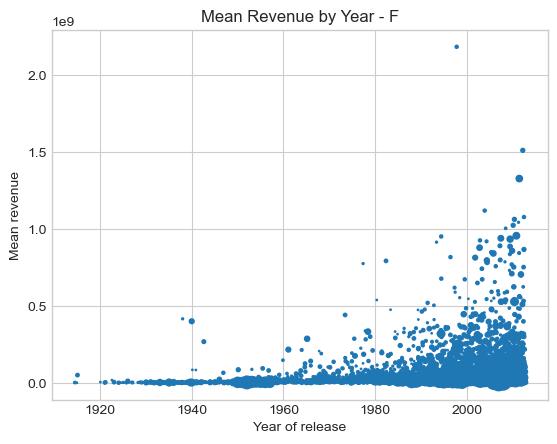

In [1734]:
revenue_year = characters_movie_F.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - F')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

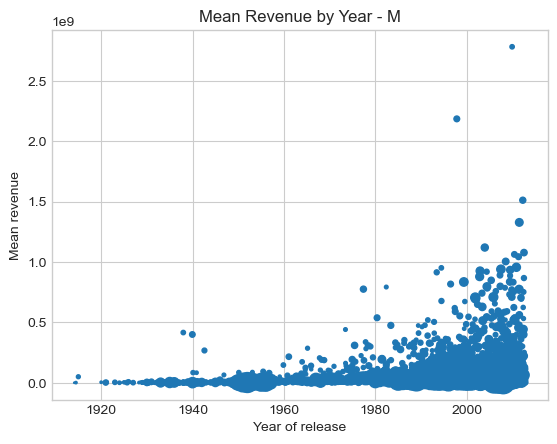

In [1735]:
revenue_year = characters_movie_M.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - M')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From what we can see on this first visualization, it seems like movies with male characters en up having a bigger mean revenue in box office revenue compared to movies with female characters.

We did not manage to find any data on the actor's salaries for each movies. This would've been a way to visualize discrimination between genders and we will continue to look in case we end up finding some data.

---

# 3. Evolution of women representation <a id="Evolution"> </a>


##  A. Are women present? <a id="Presence"> </a>

### Feminine vs. masculine pronouns occurence

In [1736]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [1737]:
# Keep only 1 example per movie. Here we will keep the first one, but it doesn't matter as we work on the summaries and not on the actors themselves

plot_summaries = plot_summaries.drop_duplicates(subset='Freebase_movie_ID', keep="first")

In [1738]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [1739]:
length_summaries = len(plot_summaries)
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 10489
The percentage of summaries with feminine pronouns occurence: 70.78075443687159 %
The number of summaries with masculine pronouns occurence: 13334
The percentage of summaries with masculine pronouns occurence: 89.97908090964303 %


> We observe that there is more than 29% difference between the occurence of feminine and masculine pronouns in the given summaries.

> We can check if the pronouns occurence changes through time.

In [1740]:
# sort by dates
summaries_with_date = plot_summaries.dropna()
summaries_with_date["Movie_release_date"] = pd.to_datetime(summaries_with_date["Movie_release_date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie_release_date")

In [1741]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie_release_date"] < "2007-01-01"]
summaries_2007 = summaries_with_date[(summaries_with_date["Movie_release_date"] >= "2007-01-01") & (summaries_with_date["Movie_release_date"] < "2016-01-01") ]
summaries_2016 = summaries_with_date[summaries_with_date["Movie_release_date"] >= "2016-01-01"]

print('The dataset with movies from after 2016 is empty, as its length is', len(summaries_2016))

print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")


The dataset with movies from after 2016 is empty, as its length is 0
The number of summaries before 2007 with feminine pronouns occurence: 8025
The percentage of summaries before 2007 with feminine pronouns occurence: 70.41326664911819 %
The number of summaries before 2007 with masculine pronouns occurence: 10320
The percentage of summaries before 2007 with masculine pronouns occurence: 90.55014477494078 %
The number of summaries after 2007 with feminine pronouns occurence: 2464
The percentage of summaries after 2007 with feminine pronouns occurence: 72.00467562828756 %
The number of summaries after 2007 with masculine pronouns occurence: 3014
The percentage of summaries after 2007 with masculine pronouns occurence: 88.0771478667446 %


> On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurence (2% each time), always with masculine pronouns mainly used in movies summaries. The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

> These results can not be largely interpreted as the subgroup "before 2007" is five times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.


### Feminine vs. masculine pronouns count

In [1742]:
#create a function that counts the occurence of a word in a string
def count_word(word, string):
    return string.count(word)

In [1743]:
#count the number of times each class of pronoun is mentioned in the plot summary
plot_summaries['fem_occurence'] = 0
plot_summaries['masc_occurence'] = 0

for y in feature_wordsets['fem_pronoun']:
    plot_summaries['fem_occurence'] = plot_summaries['fem_occurence'] + plot_summaries.apply(lambda x: count_word(y, x['Plot_Summary']), axis=1)

for y in feature_wordsets['masc_pronoun']:
    plot_summaries['masc_occurence'] = plot_summaries['masc_occurence'] + plot_summaries.apply(lambda x: count_word(y, x['Plot_Summary']), axis=1)


In [1744]:
print('The mean of feminine pronouns occurence in summaries:', plot_summaries['fem_occurence'].mean())
print('The mean of masculine pronouns occurence in summaries:', plot_summaries['masc_occurence'].mean())
print('The mean difference between feminine and masculine pronouns occurence in summaries:', plot_summaries['fem_occurence'].mean() - plot_summaries['masc_occurence'].mean())

The mean of feminine pronouns occurence in summaries: 14.334435521965045
The mean of masculine pronouns occurence in summaries: 67.2024428099062
The mean difference between feminine and masculine pronouns occurence in summaries: -52.868007287941154


> We clearly see that masculine pronouns are almost 5 times more used, which is a higher ratio than the overall presence of genders among characters (ratio of 1 woman to 3 men). 
> This can at least partly be explained by the use of masculien pronouns as geenric pronouns in English language. From the codes of Enlglish (and other) languages, masculine pronouns are sometimes used in order to reach a generic audience (no specific gender is targeted). This phenomenon could be present in the studied summaries as well and explain why masculine pronouns are always more used, independently of the type of movie genre and the targeted audience that follows. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8016286/)


The next step would be to compare the mean number of fem/masc pronouns in function of **movie genres**, and compare this result to the length of summaries too (maybe action movies have shorter summaries, and they are also more representative of the men population).


In [1745]:
# group by genres clusters
def group_genres(genre):
    genre_groups = {
        'Romance Film': 'Romance',
        'Romantic comedy': 'Romance',
        'Romantic drama': 'Romance',
        'Comedy-drama': 'Comedy',
        'Action Comedy': 'Comedy',
        'Comedy': 'Comedy',
        'Comedy film': 'Comedy',
        'Addiction Drama': 'Drama',
        'Costume Drama': 'Drama',
        'Drama': 'Drama',
        'Historical drama': 'Drama',
        'Political drama': 'Drama',
        'Mariage drama': 'Drama',
        'Crime drama': 'Drama',
        'Biography': 'Biography',
        'Biographical film': 'Biography',
        'Documentary': 'Biography',
        'History': 'Biography',
        'Horror': 'Horror',
        'Mystery': 'Mystery',
        'Music': 'Music',
        'Musical': 'Music',
        'Action': 'Action',
        'Action/Adventure': 'Action',
        'Adventure': 'Adventure',
        'Action Thrillers': 'Action',
        'Psychological thriller': 'Thriller',
        'Crime Thriller': 'Crime',
        'Crime Fiction': 'Crime',
        'Sport': 'Sport',
        'Family Drama': 'Drama',
        'Western': 'Western',
    }
    return genre_groups.get(genre, genre)

movie_metadata_genres=movie_metadata.explode('Movie_genres')
movie_metadata_genres['Movie_genres'] = movie_metadata_genres['Movie_genres'].apply(group_genres)
#only keep the genres with more than 1000 movies
movie_metadata_genres=movie_metadata_genres.groupby('Movie_genres').filter(lambda x: len(x) > 1000)
movie_metadata_genres=movie_metadata_genres.drop_duplicates(subset=['Freebase_movie_ID'], keep='first')
movie_metadata_genres

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],Thriller
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],Mystery
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],Crime
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],Thriller
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],Drama
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],Drama
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]",Biography
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],Comedy


In [1746]:
# add the movie_genres column from movie_metadata dataset to plot_summaries dataset
plot_summaries = plot_summaries.merge(movie_metadata[['Freebase_movie_ID','Movie_genres']], on='Freebase_movie_ID', how='left')
plot_summaries_genres = plot_summaries.merge(movie_metadata_genres[['Freebase_movie_ID','Movie_genres']], on='Freebase_movie_ID', how='left')

# add a gender to the movie in function of the highest pronoun occurence
def genre_pronoun(row):
    if row['fem_occurence'] > row['masc_occurence']:
        return 'F'
    elif row['fem_occurence'] < row['masc_occurence']:
        return 'M'
    else:
        return 'N'

plot_summaries['genre_pronoun'] = plot_summaries.apply(lambda row: genre_pronoun(row), axis=1)
plot_summaries_genres['genre_pronoun'] = plot_summaries_genres.apply(lambda row: genre_pronoun(row), axis=1)


# drop movies where there is no pronoun or where the number of feminine and masculine pronoun is equal - considered as 'N' neutral movies 
indexPronoun = plot_summaries[(plot_summaries['genre_pronoun'] == 'N')].index
plot_summaries.drop(indexPronoun , inplace=True)

indexPronounGenres = plot_summaries_genres[(plot_summaries_genres['genre_pronoun'] == 'N')].index
plot_summaries_genres.drop(indexPronounGenres , inplace=True)
plot_summaries_genres=plot_summaries_genres.drop(columns=['Movie_genres_x'])

# explode movie_genres columns into sub rows in order to treat movie genre by movie genre
plot_summaries_exp = plot_summaries.explode('Movie_genres')

In [1747]:
plot_summaries_exp['Movie_genres'].value_counts()

Drama                              7969
Comedy                             4842
Romance Film                       3471
Thriller                           3419
Action                             2948
                                   ... 
Tokusatsu                             1
The Netherlands in World War II       1
Exploitation                          1
Gender Issues                         1
Family & Personal Relationships       1
Name: Movie_genres, Length: 311, dtype: int64

From the dataset, there are 311 different movie genres in total when there is no genres clustering. Somes defined genres are not real genres (e.g. Airplanes, Tokusatsu). We decided to keep the most important ones (that appears more than 1000 times).

In [1748]:
# count the mean feminine and masculine pronouns occurence for each movie_genres
fm = plot_summaries_exp.groupby('Movie_genres')['fem_occurence'].agg(['mean']).rename(columns={"mean": "mean_fem_occ"})
mm = plot_summaries_exp.groupby('Movie_genres')['masc_occurence'].agg(['mean']).rename(columns={"mean": "mean_masc_occ"})

pron_occ_genres = pd.concat([fm, mm], axis=1).reset_index()
pron_occ_genres

,Movie_genres,mean_fem_occ,mean_masc_occ
0,Absurdism,12.423729,85.796610
1,Acid western,6.750000,60.250000
2,Action,11.700475,76.088535
3,Action Comedy,11.576471,81.705882
4,Action Thrillers,12.714859,86.875502
...,...,...,...
306,Women in prison films,4.750000,19.250000
307,Workplace Comedy,15.879310,69.482759
308,World cinema,14.726908,63.307229
309,Wuxia,16.071429,106.500000


In [1749]:
plot_summaries_genres

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,fem_pronoun,masc_pronoun,fem_occurence,masc_occurence,Movie_genres_y,genre_pronoun
0,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh,1,1,38,122,Action,M
1,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,2000-01-01,Nandagopal Marar,1951-09-07,M,1.780,/m/04mvp8,Mammootty,48.0,/m/059t6pv,/m/0h27qg5,/m/02hkv5,1,1,16,67,Music,M
2,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,1988-11-03,Michael Chamberlain,1947-09-14,M,1.822,/m/02jvpv,Sam Neill,41.0,/m/02tbjj2,/m/0h2qv0j,/m/01ckhj,1,1,12,62,Crime,M
3,The president is on his way to give a speech. ...,/m/0dbxtv,2006-01-01,Kate Crawford,1972-08-10,F,1.765,/m/07bch9,Angie Harmon,33.0,/m/02vcql2,/m/0h0x8g4,/m/03sysz,1,1,8,54,Thriller,M
4,"{{plot}} The film opens in 1974, as a young gi...",/m/068jvg,2005-06-27,Dahlia,1970-12-12,F,1.690,/m/041rx,Jennifer Connelly,34.0,/m/0jwzp0,/m/0dds1wb,/m/0fgg4,1,1,61,137,Thriller,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,Dr. Sullivan Travis is a wealthy Dallas gyne...,/m/0323y3,2000-09-12,Dr. T,1949-08-31,M,1.800,/m/033tf_,Richard Gere,51.0,/m/02vch2k,/m/0h0tbzz,/m/01438g,1,1,4,14,Romance,M
14815,The story develops around the evolution of Tit...,/m/0279p_0,2002-01-01,Rohit Roy,1950-06-16,M,1.830,/m/0bpjh3,Mithun Chakraborty,51.0,/m/03js489,/m/04hqnqr,/m/04c636,1,1,26,84,Drama,M
14816,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0,1,1,52,112,Period piece,M
14817,While drinking alone one night and reminiscing...,/m/0b76dxj,1989-01-01,Xenos,1919-02-18,M,1.930,/m/0ffjvd,Jack Palance,69.0,/m/0gm35v0,/m/0gm35r7,/m/02t_w8,1,1,14,78,Science Fiction,M


In [1750]:
# count the mean feminine and masculine pronouns occurence for clustered movie_genres
fc = plot_summaries_genres.groupby('Movie_genres_y')['fem_occurence'].agg(['mean']).rename(columns={"mean": "mean_fem_occ"})
mc = plot_summaries_genres.groupby('Movie_genres_y')['masc_occurence'].agg(['mean']).rename(columns={"mean": "mean_masc_occ"})

pron_occ_clust_genres = pd.concat([fc, mc], axis=1).reset_index()
pron_occ_clust_genres

,Movie_genres_y,mean_fem_occ,mean_masc_occ
0,Action,9.710280,62.646937
1,Adventure,16.873444,101.560166
2,Animation,17.301587,97.682540
3,Biography,15.238562,71.222222
4,Black comedy,12.866197,64.908451
5,Black-and-white,15.139535,69.674419
6,Bollywood,12.161290,52.193548
7,Chinese Movies,7.428571,52.714286
8,Comedy,11.238573,56.576366
9,Crime,11.971777,65.520976


In [1751]:
pron_occ_genres['diff_pron_occ'] = pron_occ_genres['mean_masc_occ']-pron_occ_genres['mean_fem_occ']
pron_occ_genres

,Movie_genres,mean_fem_occ,mean_masc_occ,diff_pron_occ
0,Absurdism,12.423729,85.796610,73.372881
1,Acid western,6.750000,60.250000,53.500000
2,Action,11.700475,76.088535,64.388060
3,Action Comedy,11.576471,81.705882,70.129412
4,Action Thrillers,12.714859,86.875502,74.160643
...,...,...,...,...
306,Women in prison films,4.750000,19.250000,14.500000
307,Workplace Comedy,15.879310,69.482759,53.603448
308,World cinema,14.726908,63.307229,48.580321
309,Wuxia,16.071429,106.500000,90.428571


In [1752]:
pron_occ_clust_genres['diff_pron_occ'] = pron_occ_clust_genres['mean_masc_occ']-pron_occ_clust_genres['mean_fem_occ']
pron_occ_clust_genres

,Movie_genres_y,mean_fem_occ,mean_masc_occ,diff_pron_occ
0,Action,9.710280,62.646937,52.936656
1,Adventure,16.873444,101.560166,84.686722
2,Animation,17.301587,97.682540,80.380952
3,Biography,15.238562,71.222222,55.983660
4,Black comedy,12.866197,64.908451,52.042254
5,Black-and-white,15.139535,69.674419,54.534884
6,Bollywood,12.161290,52.193548,40.032258
7,Chinese Movies,7.428571,52.714286,45.285714
8,Comedy,11.238573,56.576366,45.337793
9,Crime,11.971777,65.520976,53.549199


> The difference in pronouns occurence will probably be larger if the summaries are longer also. So movie genres that exhibit long summaries in general will have probably bigger difference in the use of pronouns. We could thus ponderate the differences in pronoun occurence by the mean length of summaries for each movie category.

In [1753]:
# check if there are movies where they use more feminine pronouns, so where diff_pron_occ is positive

pron_occ_genres[pron_occ_genres['diff_pron_occ'] <= 0]

,Movie_genres,mean_fem_occ,mean_masc_occ,diff_pron_occ


> For no movie genres is the mean feminine pronouns occurence larger than the mean masculine pronouns occurence. The higher masculine presence (at least in summaries) is thus an overall phenomenon and not specific to certain movie genres. 


For some movie genres, the difference in pronouns occurence for both genders is small (smaller than 10).

In [1754]:
pron_occ_genres[pron_occ_genres['diff_pron_occ'] <= 10]

,Movie_genres,mean_fem_occ,mean_masc_occ,diff_pron_occ
118,Exploitation,1.0,3.0,2.0
138,Filmed Play,1.0,9.0,8.0
146,Gender Issues,4.0,14.0,10.0
243,Rockumentary,1.0,10.0,9.0


In [1755]:

pron_occ_clust_genres[pron_occ_clust_genres['diff_pron_occ'] <= 10]

,Movie_genres_y,mean_fem_occ,mean_masc_occ,diff_pron_occ


> Even for "gender issues" movie genres, there are more masculine pronouns in general. For this type of movie, we would expect in the summaries an adaptation of English language, by using inclusive writing for example, in order to minimize the gender gap in the textual communication. 

> Eveything is biased as there are sometimes only few movies for a specific movie genre in comparison to thousands of movies for 'drame' and 'comedy'. For example, there is only one 'gender issues' movie. So its plot is probably not representative of all gender issues movies.

> The fact it is not the case on average could testifiy that the film industry experiences a gender gap, that translates into summaries writing. The summary of a movie is of course the direct short representation of this movie. 

> In regular movie genres (the one we clustered), the difference in pronoun count between genders is on average higher.

Text(0.5, 1.0, 'Mean pronoun occurence in movie summaries for masculine and feminine pronoun in function of movie genres')

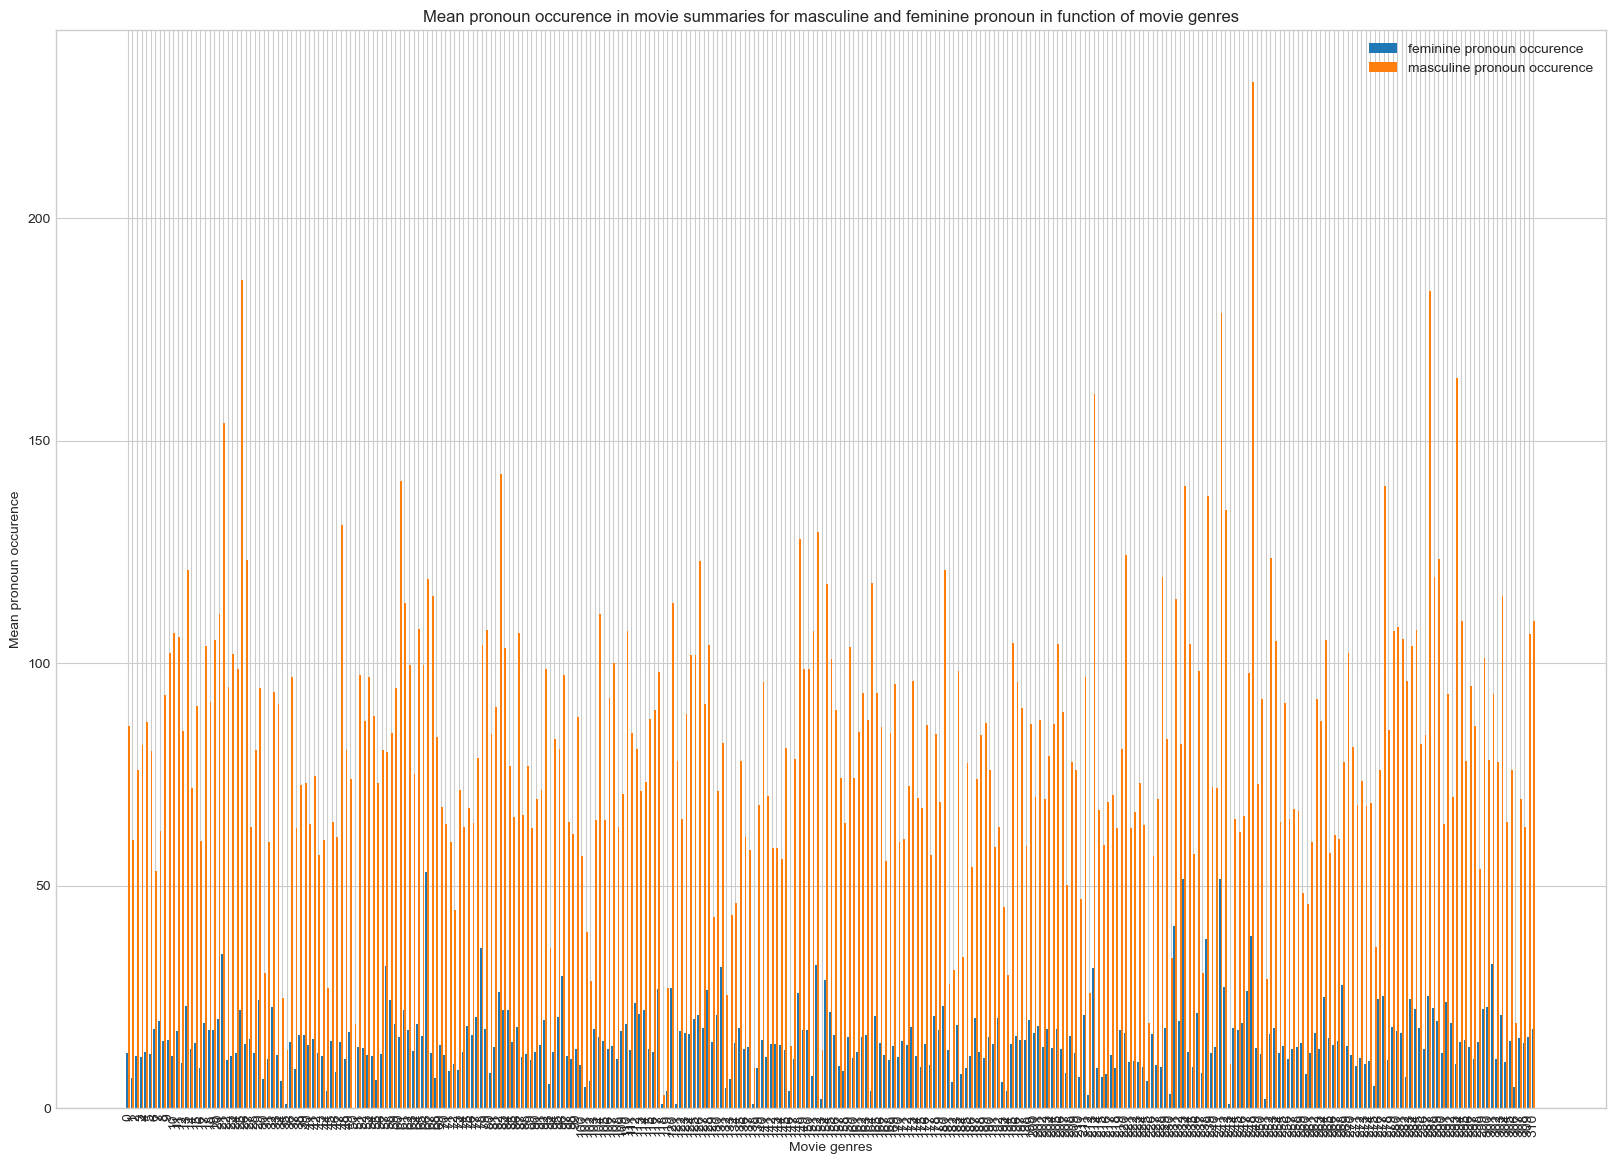

In [1756]:
# plot the mean IMDb_rating per movie genres for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(pron_occ_genres.index))

plt.figure(figsize=(20,14))
plt.bar(X_axis - 0.2, pron_occ_genres['mean_fem_occ'], 0.4, label = 'feminine pronoun occurence') # doesn't plot lables!!
plt.bar(X_axis + 0.2, pron_occ_genres['mean_masc_occ'], 0.4, label = 'masculine pronoun occurence')

plt.legend(loc='best')
plt.xticks(X_axis, pron_occ_genres.index, rotation=90)
plt.xlabel("Movie genres")
plt.ylabel("Mean pronoun occurence")
#plt.yscale('log')
plt.title("Mean pronoun occurence in movie summaries for masculine and feminine pronoun in function of movie genres")

Text(0.5, 1.0, 'Mean pronoun occurence in movie summaries for masculine and feminine pronoun in function of clustered movie genres')

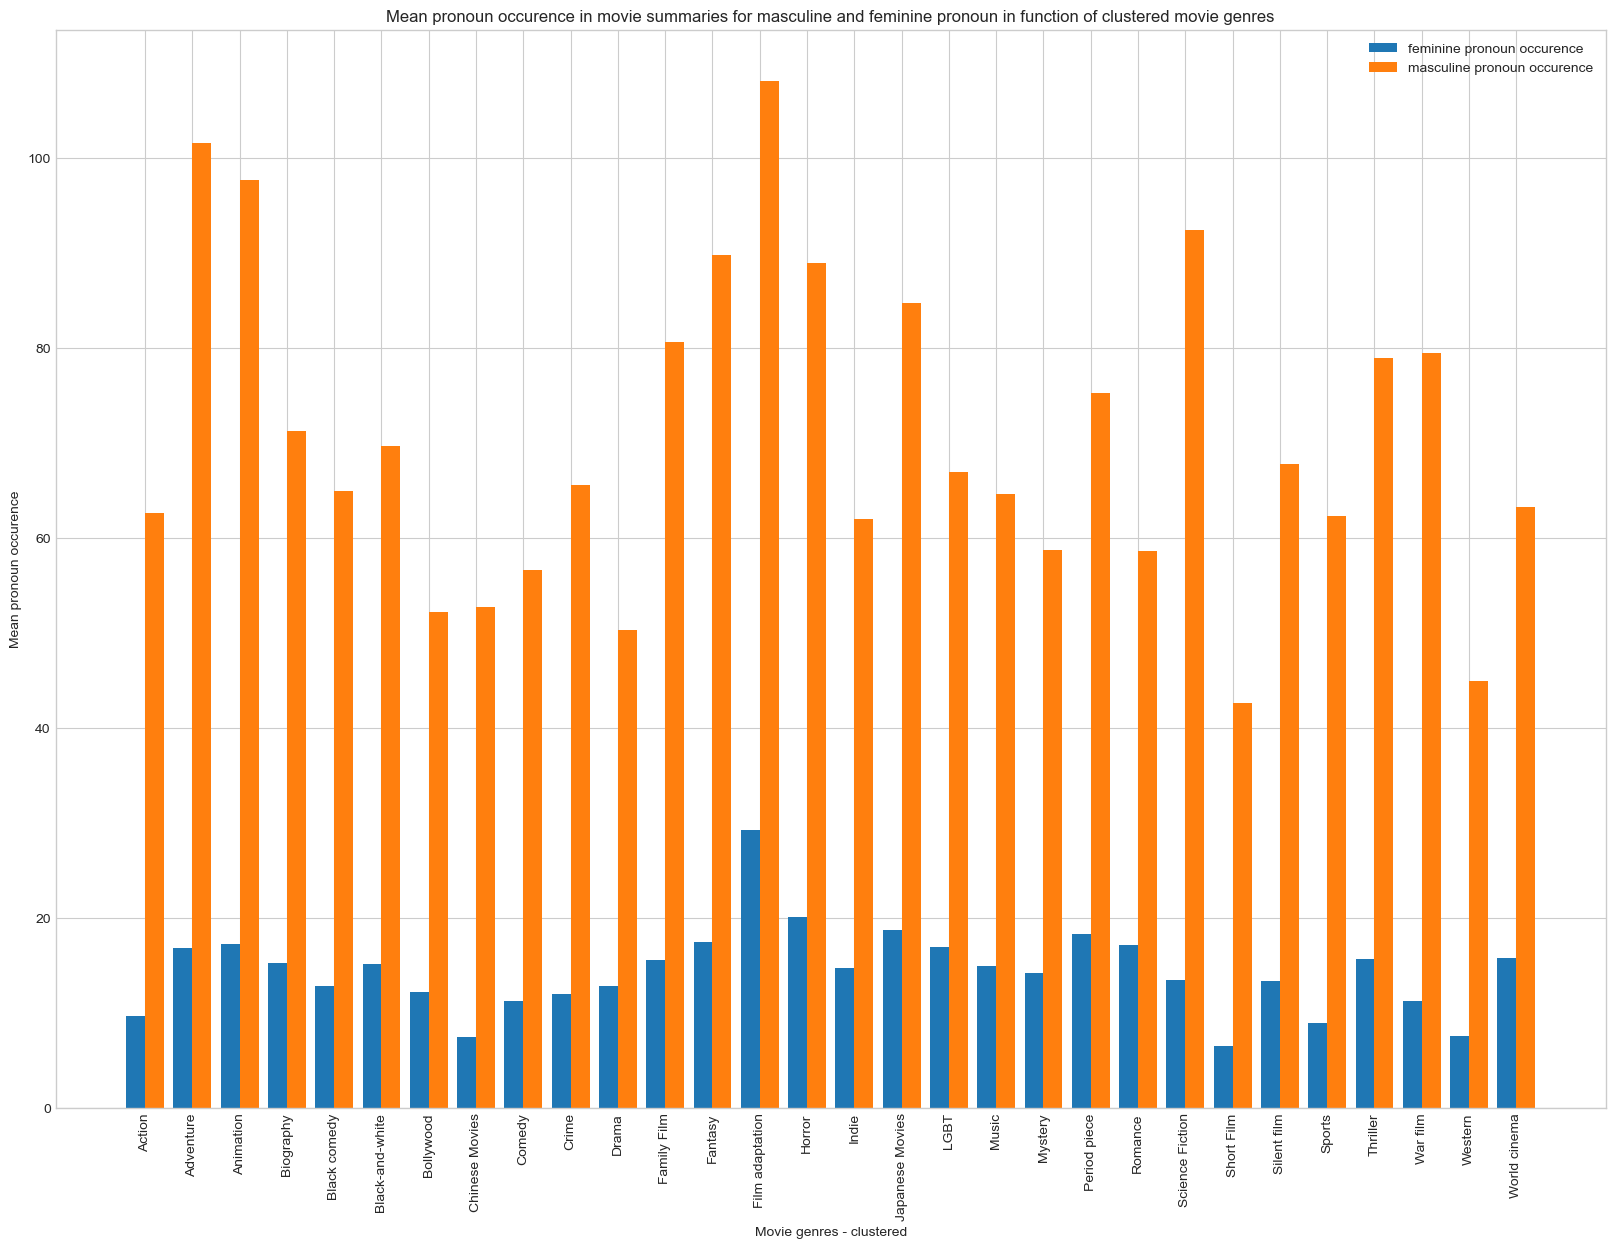

In [1757]:
# plot the mean IMDb_rating per movie genres for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(pron_occ_clust_genres.index))

plt.figure(figsize=(20,14))
plt.bar(X_axis - 0.2, pron_occ_clust_genres['mean_fem_occ'], 0.4, label = 'feminine pronoun occurence') # doesn't plot lables!!
plt.bar(X_axis + 0.2, pron_occ_clust_genres['mean_masc_occ'], 0.4, label = 'masculine pronoun occurence')

plt.legend(loc='best')
plt.xticks(X_axis, pron_occ_clust_genres.Movie_genres_y, rotation=90)
plt.xlabel("Movie genres - clustered")
plt.ylabel("Mean pronoun occurence")
#plt.yscale('log')
plt.title("Mean pronoun occurence in movie summaries for masculine and feminine pronoun in function of clustered movie genres")

> From plot, the feminine pronoun occurence is overall lower than masculine pronoun occurence, indepently of movie genres.

> In conclusion, masculine representation from pronoun count is the most prevalent in movie summaries. 

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

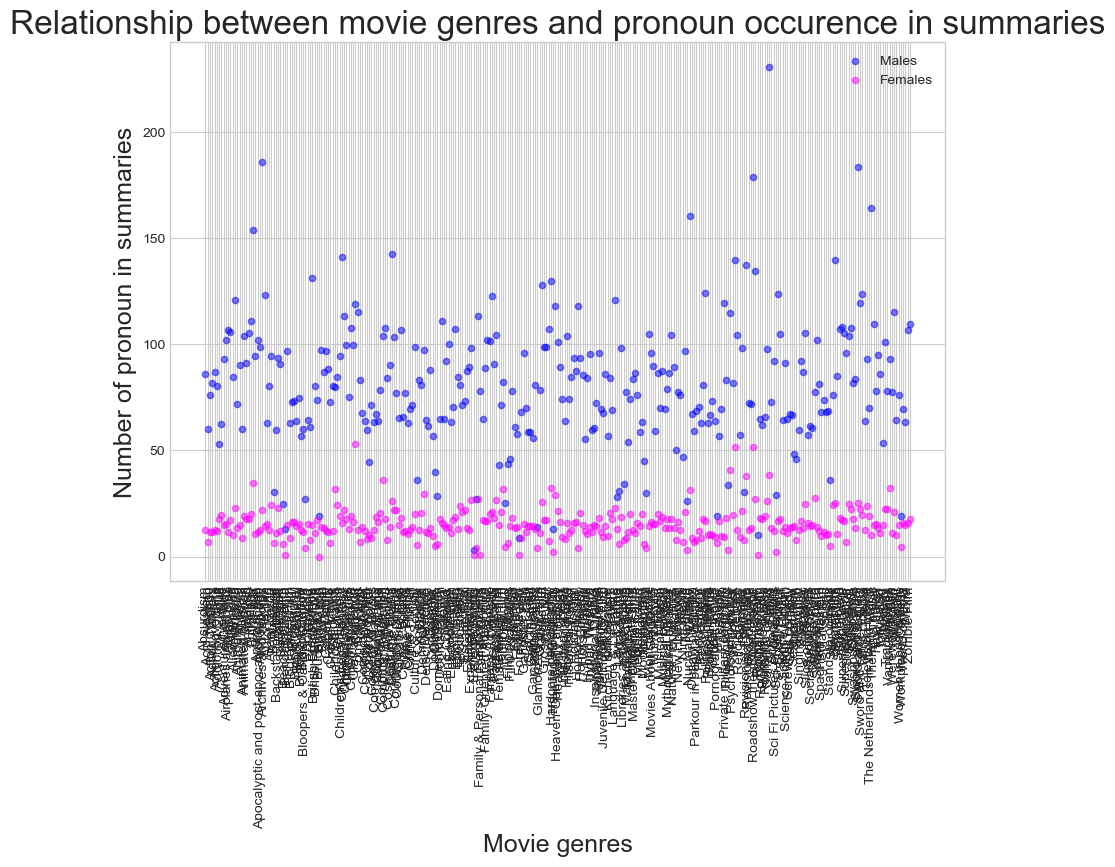

In [1758]:
# plot masculine and feminine pronoun count from summaries in function of movie genres
ax1 = pron_occ_genres.plot(kind='scatter', x='Movie_genres', y='mean_masc_occ', color='blue', alpha=0.5, figsize=(20, 14))
pron_occ_genres.plot(kind='scatter', x='Movie_genres', y='mean_fem_occ', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Males', 'Females'])
plt.title('Relationship between movie genres and pronoun occurence in summaries', size=24)
plt.xlabel('Movie genres', size=18)
plt.ylabel('Number of pronoun in summaries', size=18)
plt.xticks(rotation=90)

# https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

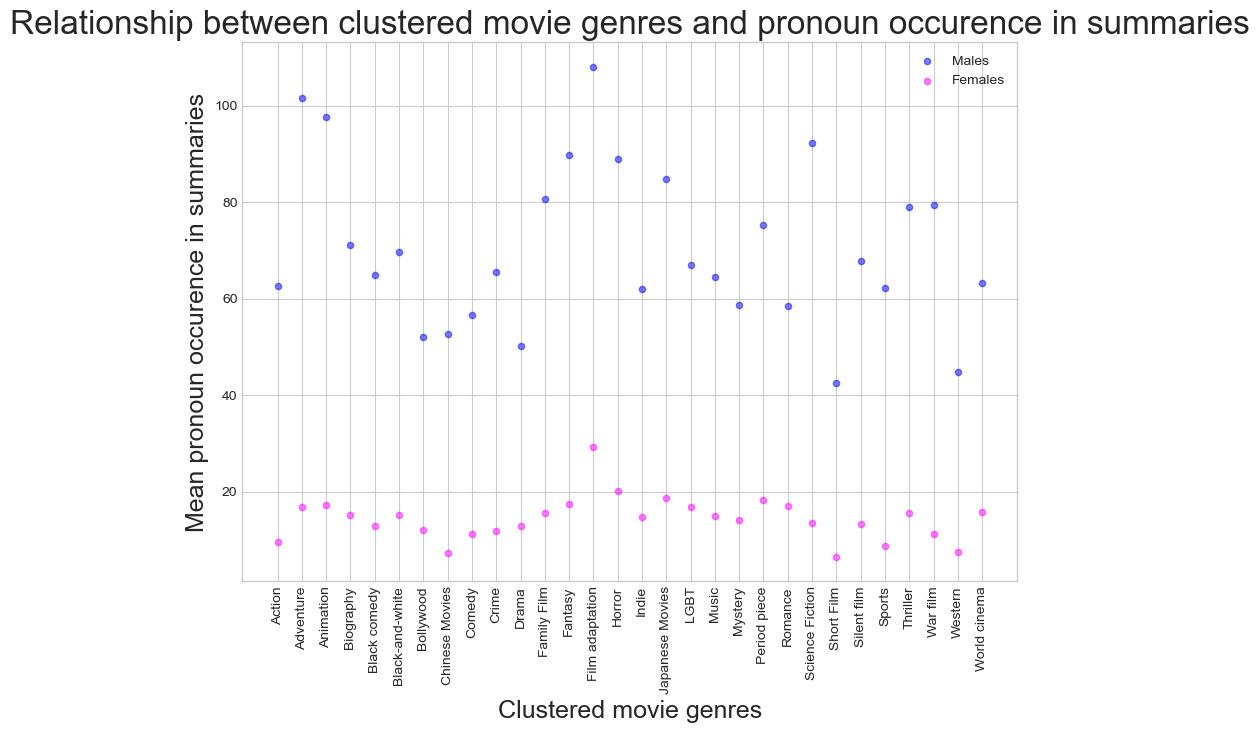

In [1759]:
# check dependency of masculine and feminine pronoun occurence with clustered movie genres
ax1 = pron_occ_clust_genres.plot(kind='scatter', x='Movie_genres_y', y='mean_masc_occ', color='blue', alpha=0.5, figsize=(10, 7))
pron_occ_clust_genres.plot(kind='scatter', x='Movie_genres_y', y='mean_fem_occ', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Males', 'Females'])
plt.title('Relationship between clustered movie genres and pronoun occurence in summaries', size=24)
plt.xlabel('Clustered movie genres', size=18)
plt.ylabel('Mean pronoun occurence in summaries', size=18)
plt.xticks(rotation=90)


In [1760]:
# perform linear regression on the mean pronouns F and M count with respect to the clustered movie genres data 

np.random.seed(1)
y1 = StandardScaler().fit_transform(pron_occ_clust_genres[['mean_fem_occ']])
y2 = StandardScaler().fit_transform(pron_occ_clust_genres[['mean_masc_occ']])

model_fem_genre = smf.ols(formula='mean_fem_occ ~ Movie_genres_y', data=pron_occ_clust_genres).fit()
model_fem_fitted_genre = smf.ols(formula='y1 ~ Movie_genres_y', data=pron_occ_clust_genres).fit()

model_masc_genre = smf.ols(formula='mean_masc_occ ~ Movie_genres_y', data=pron_occ_clust_genres).fit()
model_masc_fitted_genre = smf.ols(formula='y2 ~ Movie_genres_y', data=pron_occ_clust_genres).fit()

prediction_fem_1 = model_fem_genre.predict(pron_occ_clust_genres)
prediction_fem_2 = model_fem_fitted_genre.predict(pron_occ_clust_genres)

prediction_masc_1 = model_masc_genre.predict(pron_occ_clust_genres)
prediction_masc_2 = model_masc_fitted_genre.predict(pron_occ_clust_genres)

In [1761]:
print(model_fem_genre.summary())

                            OLS Regression Results                            
Dep. Variable:           mean_fem_occ   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                nan
Time:                        13:24:03   Log-Likelihood:                 915.64
No. Observations:                  30   AIC:                            -1771.
Df Residuals:                       0   BIC:                            -1729.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [1762]:
print(model_fem_fitted_genre.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                nan
Time:                        13:24:03   Log-Likelihood:                 967.31
No. Observations:                  30   AIC:                            -1875.
Df Residuals:                       0   BIC:                            -1833.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [1763]:
print(model_masc_genre.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_masc_occ   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                nan
Time:                        13:24:03   Log-Likelihood:                 867.15
No. Observations:                  30   AIC:                            -1674.
Df Residuals:                       0   BIC:                            -1632.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [1764]:
print(model_masc_fitted_genre.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                nan
Time:                        13:24:03   Log-Likelihood:                 958.31
No. Observations:                  30   AIC:                            -1857.
Df Residuals:                       0   BIC:                            -1815.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/alienorhamoir/opt/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


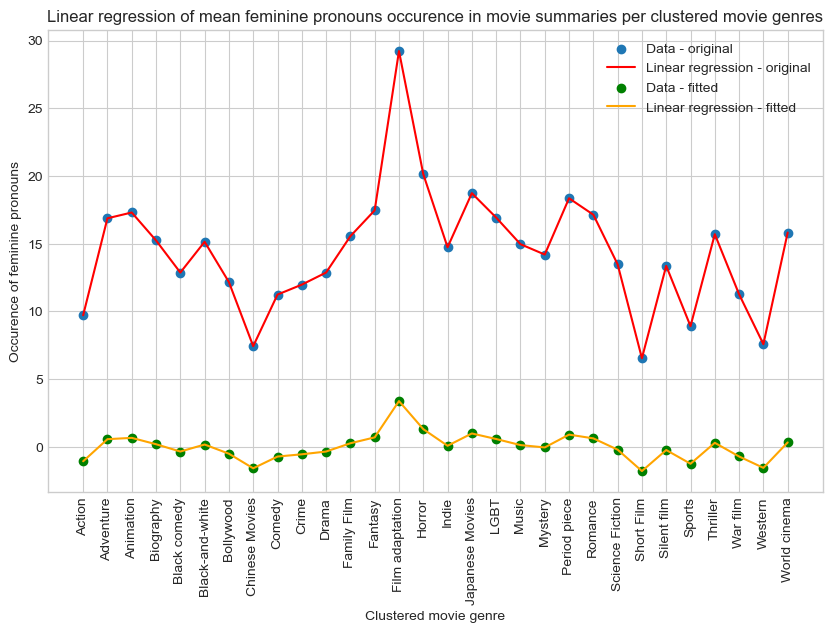

In [1765]:
plt.figure(figsize=(10,6))
plt.scatter(pron_occ_clust_genres.Movie_genres_y, pron_occ_clust_genres.mean_fem_occ)
plt.plot(pron_occ_clust_genres.Movie_genres_y, prediction_fem_1, color='red')
plt.scatter(pron_occ_clust_genres.Movie_genres_y, y1, color='green')
plt.plot(pron_occ_clust_genres.Movie_genres_y, prediction_fem_2, color='orange')
plt.title('Linear regression of mean feminine pronouns occurence in movie summaries per clustered movie genres')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Occurence of feminine pronouns")
plt.xlabel("Clustered movie genre")
plt.xticks(rotation=90)
plt.show()

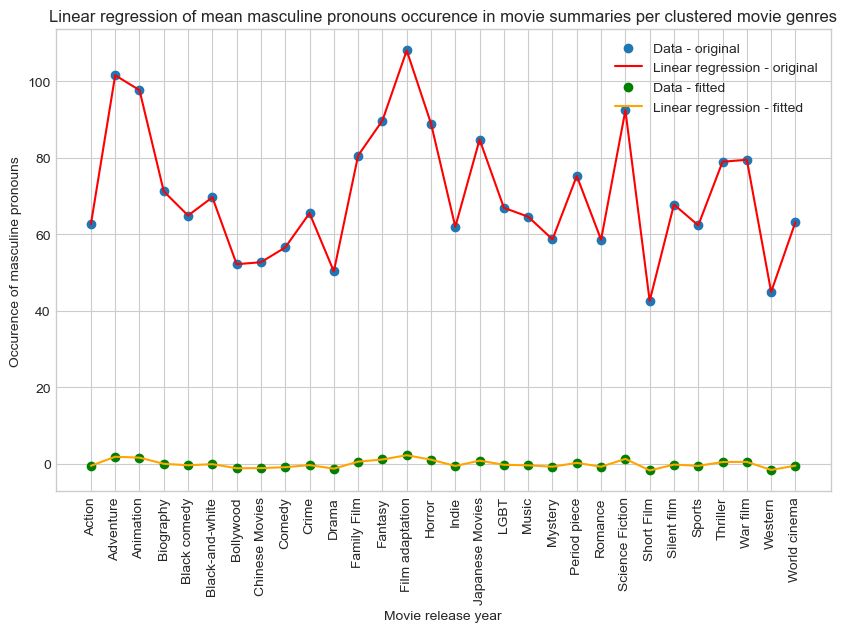

In [1766]:
plt.figure(figsize=(10,6))
plt.scatter(pron_occ_clust_genres.Movie_genres_y,pron_occ_clust_genres.mean_masc_occ)
plt.plot(pron_occ_clust_genres.Movie_genres_y, prediction_masc_1, color='red')
plt.scatter(pron_occ_clust_genres.Movie_genres_y,y2, color='green')
plt.plot(pron_occ_clust_genres.Movie_genres_y, prediction_masc_2, color='orange')
plt.title('Linear regression of mean masculine pronouns occurence in movie summaries per clustered movie genres')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Occurence of masculine pronouns")
plt.xlabel("Movie release year")
plt.xticks(rotation=90)
plt.show()

> The linear regressions on clustered movie genres give no results. This may due to the fact that there is not enough data.

**Evolution of pronouns use in summaries through time**

In [1767]:
# count the mean feminine and masculine pronouns occurence per movie release year

# create column with movie release years 
plot_summaries_genres['Movie_release_year'] = plot_summaries_genres['Movie_release_date'].dt.year

fy = plot_summaries_genres.groupby('Movie_release_year')['fem_occurence'].agg(['mean']).rename(columns={"mean": "mean_fem_occ"})
my = plot_summaries_genres.groupby('Movie_release_year')['masc_occurence'].agg(['mean']).rename(columns={"mean": "mean_masc_occ"})

pron_occ_years = pd.concat([fy, my], axis=1).reset_index()
pron_occ_years

,Movie_release_year,mean_fem_occ,mean_masc_occ
0,1925,5.000000,31.000000
1,1926,16.000000,66.200000
2,1928,9.700000,46.300000
3,1929,12.000000,54.500000
4,1930,13.600000,50.400000
...,...,...,...
84,2010,16.812601,72.977383
85,2011,15.242754,71.088768
86,2012,15.828947,74.385965
87,2013,2.214286,12.785714


In [1768]:
# group by period - will be reused later
# define 10-years period in function of movie release year

period_length = 10
start_year = 1926
end_year = 2013

year_range = end_year - start_year
modulo = year_range % period_length
# For 1926–2013 the modulo is 7

if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1


starts = np.arange(start_year, final_start, period_length).tolist()

tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
period_bins = pd.IntervalIndex.from_tuples(tuples, closed='left')
original_labels = list(period_bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

# The label dict when year range is 1926-2013
{'[1926, 1935)': '1926 - 1935',
 '[1936, 1945)': '1936 - 1945',
 '[1946, 1955)': '1946 - 1955',
 '[1956, 1965)': '1956 - 1965', 
 '[1966, 1975)': '1966 - 1975',
 '[1976, 1985)': '1976 - 1985',
 '[1986, 1995)': '1986 - 1995',
 '[1996, 2005)': '1996 - 2005',
 '[2006, 2013)': '2006 - 2013',}



{'[1926, 1935)': '1926 - 1935',
 '[1936, 1945)': '1936 - 1945',
 '[1946, 1955)': '1946 - 1955',
 '[1956, 1965)': '1956 - 1965',
 '[1966, 1975)': '1966 - 1975',
 '[1976, 1985)': '1976 - 1985',
 '[1986, 1995)': '1986 - 1995',
 '[1996, 2005)': '1996 - 2005',
 '[2006, 2013)': '2006 - 2013'}

In [1769]:
# Assign each row to a period
pron_occ_years_grD = pron_occ_years
pron_occ_years_grD['PERIOD'] = pd.cut(pron_occ_years_grD['Movie_release_year'], bins=period_bins, include_lowest=True, precision=0)
pron_occ_years_grD['PERIOD'] = pron_occ_years_grD['PERIOD'].astype("str")
pron_occ_years_grD = pron_occ_years_grD.replace(label_dict)

pron_occ_years_grD = pron_occ_years.groupby('PERIOD').mean().reset_index()
pron_occ_years_grD

,PERIOD,Movie_release_year,mean_fem_occ,mean_masc_occ
0,"[1926, 1936)",1930.888889,11.638722,49.857435
1,"[1936, 1946)",1940.500000,10.033241,49.638993
2,"[1946, 1956)",1950.500000,12.183497,55.965940
3,"[1956, 1966)",1960.500000,12.618621,60.327103
4,"[1966, 1976)",1970.500000,10.654027,56.298399
5,"[1976, 1986)",1980.500000,12.169377,61.477751
6,"[1986, 1996)",1990.500000,13.070876,64.641204
7,"[1996, 2006)",2000.500000,15.315288,70.323574
8,"[2006, 2014)",2009.500000,14.551093,66.220609
9,nan,1969.500000,3.500000,22.500000


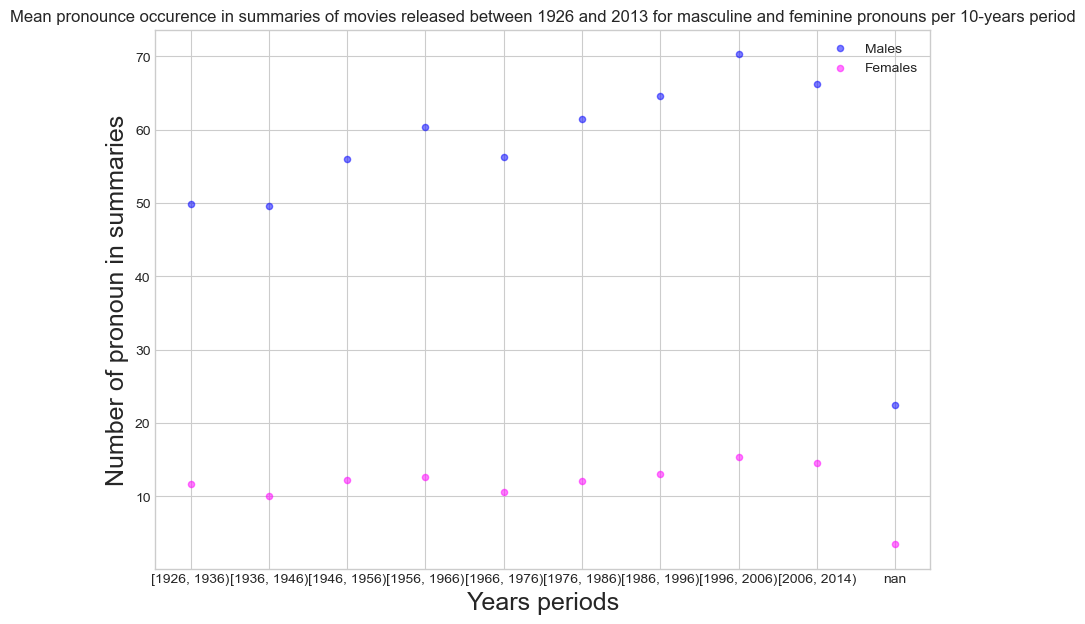

In [1770]:
# check dependency of masculine and feminine pronoun occurence with movie genres
ax1 = pron_occ_years_grD.plot(kind='scatter', x='PERIOD', y='mean_masc_occ', color='blue', alpha=0.5, figsize=(10, 7))
pron_occ_years_grD.plot(kind='scatter', x='PERIOD', y='mean_fem_occ', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Males', 'Females'])
plt.title(f"Mean pronounce occurence in summaries of movies released between {start_year} and {end_year} for masculine and feminine pronouns per 10-years period")
plt.xlabel('Years periods', size=18)
#plt.yscale('log')
plt.ylabel('Number of pronoun in summaries', size=18);

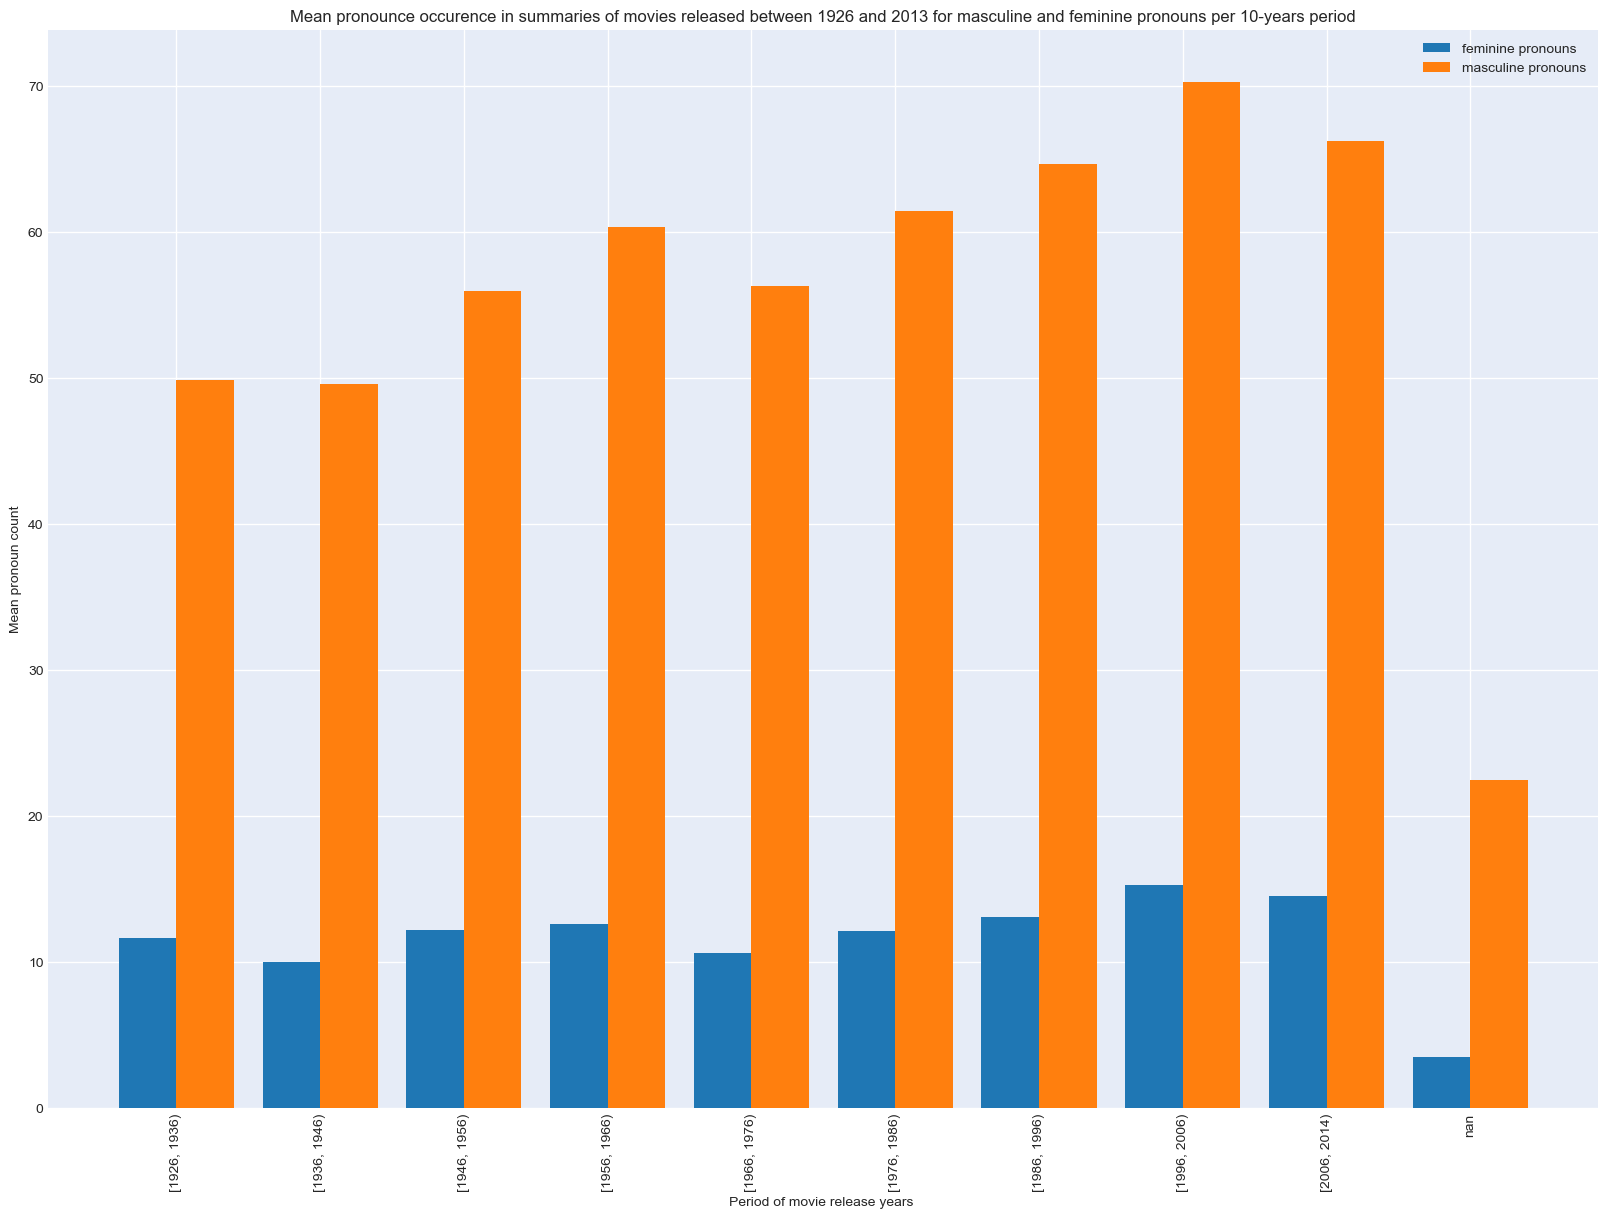

In [1771]:
# mean pronounce occurence in summaries of movies

X_axis = np.arange(len(pron_occ_years_grD.index))

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.bar(X_axis - 0.2, pron_occ_years_grD['mean_fem_occ'], 0.4, label = 'feminine pronouns') # doesn't plot lables!!
plt.bar(X_axis + 0.2, pron_occ_years_grD['mean_masc_occ'], 0.4, label = 'masculine pronouns')

plt.xticks(X_axis, pron_occ_years_grD['PERIOD'], rotation=90)
plt.title(f"Mean pronounce occurence in summaries of movies released between {start_year} and {end_year} for masculine and feminine pronouns per 10-years period")
plt.xlabel("Period of movie release years ") 
plt.ylabel("Mean pronoun count") 
# plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()


> From graph, we want to say number of masculine pronoun occurence increase a little bit with time while feminine pronoun count per summary stays more or less the same.

> We are going to perform a linear regression on the data over the years (and not over epriods, otherwise not to really analyze the trend.

In [1772]:
# perform linear regression on percentage of female?
pron_occ_years_grD["perc_female"] = pron_occ_years_grD["mean_fem_occ"] / (pron_occ_years_grD["mean_fem_occ"] + pron_occ_years_grD["mean_masc_occ"])
pron_occ_years_grD

,PERIOD,Movie_release_year,mean_fem_occ,mean_masc_occ,perc_female
0,"[1926, 1936)",1930.888889,11.638722,49.857435,0.189259
1,"[1936, 1946)",1940.500000,10.033241,49.638993,0.168139
2,"[1946, 1956)",1950.500000,12.183497,55.965940,0.178776
3,"[1956, 1966)",1960.500000,12.618621,60.327103,0.172986
4,"[1966, 1976)",1970.500000,10.654027,56.298399,0.159128
5,"[1976, 1986)",1980.500000,12.169377,61.477751,0.165239
6,"[1986, 1996)",1990.500000,13.070876,64.641204,0.168196
7,"[1996, 2006)",2000.500000,15.315288,70.323574,0.178836
8,"[2006, 2014)",2009.500000,14.551093,66.220609,0.180151
9,nan,1969.500000,3.500000,22.500000,0.134615


In [1773]:
# perform linear regression on the data for each year and not for each period - on period, not enough data to obtain significant results

np.random.seed(1)
y1 = StandardScaler().fit_transform(pron_occ_years[['mean_fem_occ']])
y2 = StandardScaler().fit_transform(pron_occ_years[['mean_masc_occ']])

model_fem_year = smf.ols(formula='mean_fem_occ ~ Movie_release_year', data=pron_occ_years).fit()
model_fem_scaled = smf.ols(formula='y1 ~ Movie_release_year', data=pron_occ_years).fit()

model_masc_year = smf.ols(formula='mean_masc_occ ~ Movie_release_year', data=pron_occ_years).fit()
model_masc_scaled = smf.ols(formula='y2 ~ Movie_release_year', data=pron_occ_years).fit()

prediction_fem_1 = model_fem_year.predict(pron_occ_years)
prediction_fem_2 = model_fem_scaled.predict(pron_occ_years)

prediction_masc_1 = model_masc_year.predict(pron_occ_years)
prediction_masc_2 = model_masc_scaled.predict(pron_occ_years)


In [1774]:
print(model_fem_year.summary())

                            OLS Regression Results                            
Dep. Variable:           mean_fem_occ   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     13.91
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           0.000341
Time:                        13:24:05   Log-Likelihood:                -215.11
No. Observations:                  89   AIC:                             434.2
Df Residuals:                      87   BIC:                             439.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -70.8246     22

> The "R-squared" value of 0.138 indicates that the model explains 13.8% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the small p-value of 0.002 indicates that the model is very significant.

> The coefficient for "Movie_release_year" is 0.0421, which suggests that for every unit increase in the year in which a movie is released, the mean feminine pronouns occurence is expected to increase by 0.0421. The intercept term of -70.7886 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


In [1775]:
print(model_fem_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     13.91
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           0.000341
Time:                        13:24:05   Log-Likelihood:                -119.69
No. Observations:                  89   AIC:                             243.4
Df Residuals:                      87   BIC:                             248.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -28.4257      7

> The "R-squared" value of 0.138 indicates that the model explains 13.8% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the null p-value indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is 0.0144, which suggests that for every unit increase in the year in which a movie is released, the mean feminine pronouns occurence (scaled data) is expected to increase by 0.0144. The intercept term of -28.4125 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.

In [1776]:
print(model_masc_year.summary())

                            OLS Regression Results                            
Dep. Variable:          mean_masc_occ   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     25.29
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.62e-06
Time:                        13:24:06   Log-Likelihood:                -334.00
No. Observations:                  89   AIC:                             672.0
Df Residuals:                      87   BIC:                             677.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -367.4052     84

> The "R-squared" value of 0.225 indicates that the model explains 22.5% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the null p-value indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is 0.2161, which suggests that for every unit increase in the year in which a movie is released, the mean masculine pronouns occurence is expected to increase by 0.2161. The intercept term of -367.1559 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.

In [1777]:
print(model_masc_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     25.29
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.62e-06
Time:                        13:24:06   Log-Likelihood:                -114.93
No. Observations:                  89   AIC:                             233.9
Df Residuals:                      87   BIC:                             238.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -36.3383      7

> The "R-squared" value of 0.225 indicates that the model explains 22.5% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the null p-value indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is 0.0184, which suggests that for every unit increase in the year in which a movie is released, the mean masculine pronouns occurence (scaled data) is expected to increase by 0.0184. The intercept term of -36.3211 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.

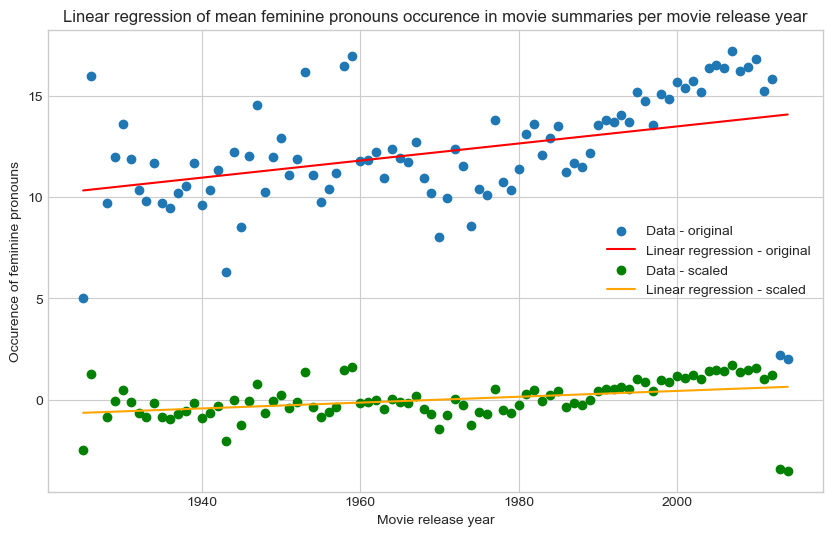

In [1778]:
plt.figure(figsize=(10,6))
plt.scatter(pron_occ_years.Movie_release_year,pron_occ_years.mean_fem_occ)
plt.plot(pron_occ_years.Movie_release_year, prediction_fem_1, color='red')
plt.scatter(pron_occ_years.Movie_release_year,y1, color='green')
plt.plot(pron_occ_years.Movie_release_year, prediction_fem_2, color='orange')
plt.title('Linear regression of mean feminine pronouns occurence in movie summaries per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - scaled','Linear regression - scaled'])
plt.ylabel("Occurence of feminine pronouns")
plt.xlabel("Movie release year")
plt.show()

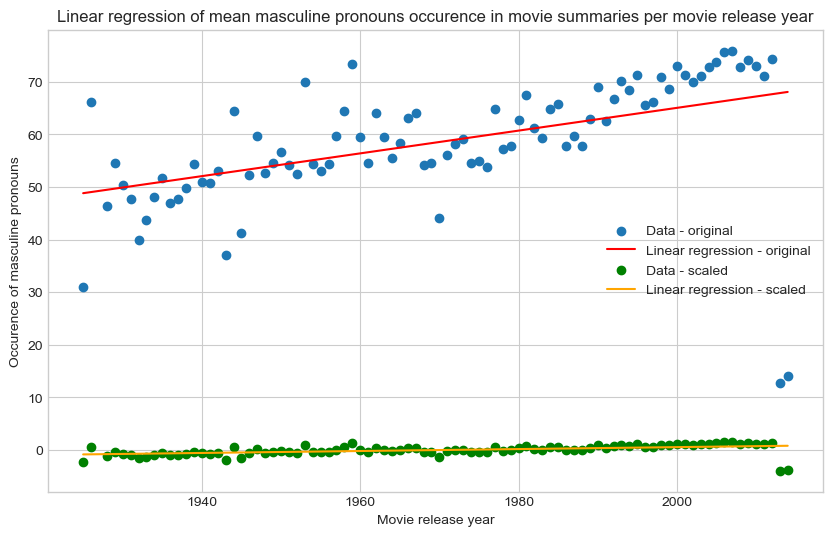

In [1779]:
plt.figure(figsize=(10,6))
plt.scatter(pron_occ_years.Movie_release_year,pron_occ_years.mean_masc_occ)
plt.plot(pron_occ_years.Movie_release_year, prediction_masc_1, color='red')
plt.scatter(pron_occ_years.Movie_release_year,y2, color='green')
plt.plot(pron_occ_years.Movie_release_year, prediction_masc_2, color='orange')
plt.title('Linear regression of mean masculine pronouns occurence in movie summaries per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - scaled','Linear regression - scaled'])
plt.ylabel("Occurence of masculine pronouns")
plt.xlabel("Movie release year")
plt.show()

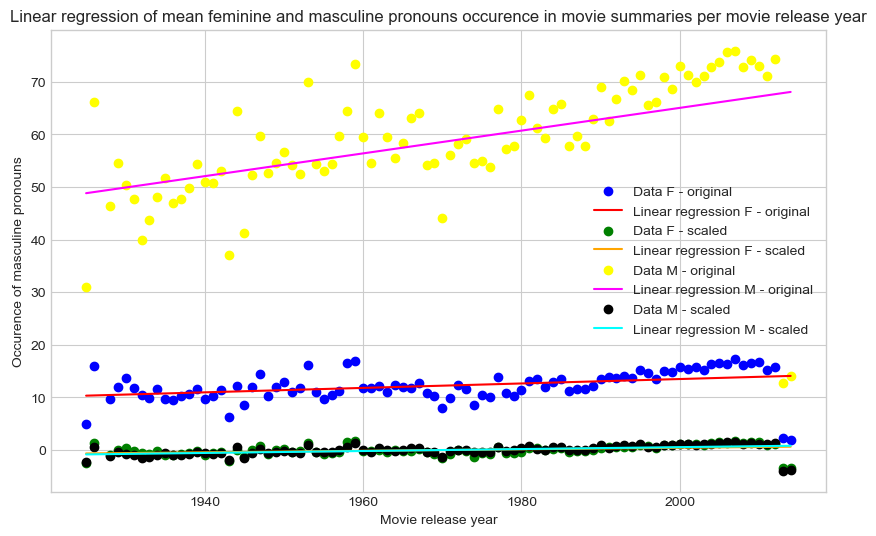

In [1780]:
plt.figure(figsize=(10,6))
plt.scatter(pron_occ_years.Movie_release_year,pron_occ_years.mean_fem_occ, color='blue')
plt.plot(pron_occ_years.Movie_release_year, prediction_fem_1, color='red')
plt.scatter(pron_occ_years.Movie_release_year,y1, color='green')
plt.plot(pron_occ_years.Movie_release_year, prediction_fem_2, color='orange')
plt.scatter(pron_occ_years.Movie_release_year,pron_occ_years.mean_masc_occ, color='yellow')
plt.plot(pron_occ_years.Movie_release_year, prediction_masc_1, color='magenta')
plt.scatter(pron_occ_years.Movie_release_year,y2, color='black')
plt.plot(pron_occ_years.Movie_release_year, prediction_masc_2, color='cyan')
plt.title('Linear regression of mean feminine and masculine pronouns occurence in movie summaries per movie release year')
plt.legend(['Data F - original','Linear regression F - original','Data F - scaled','Linear regression F - scaled','Data M - original','Linear regression M - original','Data M - scaled','Linear regression M - scaled'])
plt.ylabel("Occurence of masculine pronouns")
plt.xlabel("Movie release year")
plt.show()

> From the last plot, when looking at the original data, the mean increase in masculine pronouns occurence in summaries each year is bigger than for feminine pronouns. There are outliers (movies from 2014) with very low occurence of pronouns. This is because there are only a few movies in the dataset for this year.

### Detecting the main character in each movie 

To detect the main character in each movie, we assume the main character is the character from character_data that appears the most in the summary.

In [1781]:

character_metadata=character_metadata.drop_duplicates()
print('There are normally', len(character_metadata),'characters')

There are normally 450127 characters


In [1782]:
character_dropna_name = character_metadata.dropna(subset=['Character_name'])
print('Percentage of missing entries in the name of the characters dataset:\n', 100*character_metadata[['Character_name']].isna().sum() / n_char)
character_dropna_name

Percentage of missing entries in the name of the characters dataset:
 Character_name    57.148373
dtype: float64


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h


In [1783]:

#count the number of times each character is mentioned in the plot summary

plot_summaries['Character_occurence'] = plot_summaries.apply(lambda x: count_word(x['Character_name'], x['Plot_Summary']), axis=1)
plot_summaries['Movie_release_year'] = plot_summaries['Movie_release_date'].dt.year

plot_summaries.head(5)

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,...,Freebase_character_ID,Freebase_actor_ID,fem_pronoun,masc_pronoun,fem_occurence,masc_occurence,Movie_genres,genre_pronoun,Character_occurence,Movie_release_year
0,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,...,/m/0ds96_p,/m/04yd0fh,1,1,38,122,"[Action/Adventure, Science Fiction, Action, Dr...",M,0,2012
1,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,2000-01-01,Nandagopal Marar,1951-09-07,M,1.780,/m/04mvp8,Mammootty,48.0,...,/m/0h27qg5,/m/02hkv5,1,1,16,67,"[Musical, Action, Drama, Bollywood]",M,0,2000
2,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,1988-11-03,Michael Chamberlain,1947-09-14,M,1.822,/m/02jvpv,Sam Neill,41.0,...,/m/0h2qv0j,/m/01ckhj,1,1,12,62,"[Crime Fiction, Drama, Docudrama, World cinema...",M,1,1988
3,The president is on his way to give a speech. ...,/m/0dbxtv,2006-01-01,Kate Crawford,1972-08-10,F,1.765,/m/07bch9,Angie Harmon,33.0,...,/m/0h0x8g4,/m/03sysz,1,1,8,54,"[Thriller, Action/Adventure, Action, Drama]",M,1,2006
4,"{{plot}} The film opens in 1974, as a young gi...",/m/068jvg,2005-06-27,Dahlia,1970-12-12,F,1.690,/m/041rx,Jennifer Connelly,34.0,...,/m/0dds1wb,/m/0fgg4,1,1,61,137,"[Thriller, Drama, Horror]",M,21,2005


In [1784]:
#create dataframe with the highest character occurence for each Freebase movie ID and the corresponding character name and gender

character_occurence = plot_summaries.groupby('Freebase_movie_ID')['Character_occurence'].max().reset_index()
character_occurence = character_occurence.merge(plot_summaries[['Freebase_movie_ID', 'Character_name', 'Character_occurence', 'Movie_release_year']], on=['Freebase_movie_ID', 'Character_occurence'], how='left')
character_occurence = character_occurence.drop_duplicates(subset='Freebase_movie_ID', keep='first')
character_occurence = character_occurence.drop('Character_occurence', axis=1)
character_occurence

#add character name and gender to character_occurence
character_occurence = character_occurence.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID', 'Character_name'], how='left').rename(columns={"Character_name": "Main_character_name", "Actor_gender": "Character_gender"})

character_occurence.head(10)


,Freebase_movie_ID,Main_character_name,Movie_release_year,Character_gender
0,/m/011wtv,John Anderton,2002,M
1,/m/011x_4,Phil Connors,1993,M
2,/m/011xg5,David,2001,M
3,/m/011xrr,Lord John Whorfin,1984,M
4,/m/011ycb,Sandra Goodwin,1994,F
5,/m/011yd2,Sy Liebergot - EECOM White,1995,M
6,/m/011ydl,Fly,1995,F
7,/m/011yfd,Beatrice Russo,1994,F
8,/m/011yg9,Elinor Dashwood,1995,F
9,/m/011yhm,Carl Showalter,1996,M


Freebase_movie_ID      5686
Main_character_name    5686
Movie_release_year     5686
Character_gender       5686
dtype: int64


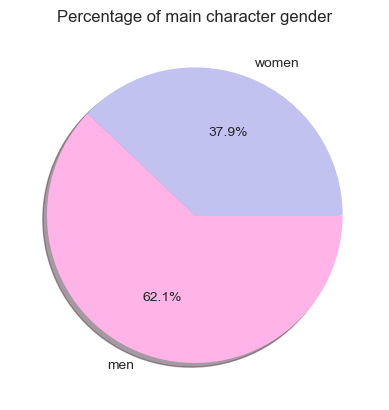

In [1785]:
x=character_occurence[character_occurence['Character_gender'] == 'F'].count()
print(x)
y=character_occurence[character_occurence['Character_gender'] == 'M'].count()
#plot x and y in a pie chart
plt.pie([x[0] , y[0]],labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of main character gender')
plt.show()

In [1786]:
character_occurence

,Freebase_movie_ID,Main_character_name,Movie_release_year,Character_gender
0,/m/011wtv,John Anderton,2002,M
1,/m/011x_4,Phil Connors,1993,M
2,/m/011xg5,David,2001,M
3,/m/011xrr,Lord John Whorfin,1984,M
4,/m/011ycb,Sandra Goodwin,1994,F
...,...,...,...,...
15007,/m/0yyg4,Anderson,1988,M
15008,/m/0yyn5,Tess McGill,1988,F
15009,/m/0yyts,Hoke Colburn,1989,M
15010,/m/0yzbg,Todd Anderson,1989,M


**Look at the evolution through time of number of main characters for each gender on 10-years periods**

In [1787]:
character_occurence

,Freebase_movie_ID,Main_character_name,Movie_release_year,Character_gender
0,/m/011wtv,John Anderton,2002,M
1,/m/011x_4,Phil Connors,1993,M
2,/m/011xg5,David,2001,M
3,/m/011xrr,Lord John Whorfin,1984,M
4,/m/011ycb,Sandra Goodwin,1994,F
...,...,...,...,...
15007,/m/0yyg4,Anderson,1988,M
15008,/m/0yyn5,Tess McGill,1988,F
15009,/m/0yyts,Hoke Colburn,1989,M
15010,/m/0yzbg,Todd Anderson,1989,M


In [1788]:

# Assign each row to a period
character_occurence_grP = character_occurence
character_occurence_grP['PERIOD'] = pd.cut(character_occurence_grP['Movie_release_year'], bins=period_bins, include_lowest=True, precision=0)
character_occurence_grP['PERIOD'] = character_occurence_grP['PERIOD'].astype("str")
character_occurence_grP = character_occurence_grP.replace(label_dict)

character_occurence_grP

,Freebase_movie_ID,Main_character_name,Movie_release_year,Character_gender,PERIOD
0,/m/011wtv,John Anderton,2002,M,1996 - 2005
1,/m/011x_4,Phil Connors,1993,M,1986 - 1995
2,/m/011xg5,David,2001,M,1996 - 2005
3,/m/011xrr,Lord John Whorfin,1984,M,1976 - 1985
4,/m/011ycb,Sandra Goodwin,1994,F,1986 - 1995
...,...,...,...,...,...
15007,/m/0yyg4,Anderson,1988,M,1986 - 1995
15008,/m/0yyn5,Tess McGill,1988,F,1986 - 1995
15009,/m/0yyts,Hoke Colburn,1989,M,1986 - 1995
15010,/m/0yzbg,Todd Anderson,1989,M,1986 - 1995


In [1789]:
# group by and plot the mean number of feminine and masculine main characters per PERIOD
character_occurence_grP = character_occurence_grP.groupby(['PERIOD','Character_gender']).agg('count')
character_occurence_grP

Freebase_movie_ID  Main_character_name  \
PERIOD      Character_gender                                           
1926 - 1935 F                                43                   43   
            M                                57                   57   
1936 - 1945 F                                96                   96   
            M                               185                  185   
1946 - 1955 F                               188                  188   
            M                               279                  279   
1956 - 1965 F                               242                  242   
            M                               379                  379   
1966 - 1975 F                               292                  292   
            M                               585                  585   
1976 - 1985 F                               399                  399   
            M                               896                  896   
1986 - 1995 F                               859                  859   
            M                              1685                 1685   
1996 - 2005 F                              1859                 1859   
            M                              2747                 2747   
2006 - 2013 F                              1706                 1706   
            M                              2495                 2495   
nan         F                                 2                    2   

                              Movie_release_year  
PERIOD      Character_gender                      
1926 - 1935 F                                 43  
            M                                 57  
1936 - 1945 F                                 96  
            M                                185  
1946 - 1955 F                                188  
            M                                279  
1956 - 1965 F                                242  
            M                                379  
1966 - 1975 F                                292  
            M                                585  
1976 - 1985 F                                399  
            M                                896  
1986 - 1995 F                                859  
            M                               1685  
1996 - 2005 F                               1859  
            M                               2747  
2006 - 2013 F                               1706  
            M                               2495  
nan         F                                  2

In [1790]:

character_occurence_F = character_occurence_grP.xs('F', level=1).rename(columns={"Freebase_movie_ID": "F_count"}).drop(['Main_character_name','Movie_release_year'], axis=1)
character_occurence_M = character_occurence_grP.xs('M', level=1).rename(columns={"Freebase_movie_ID": "M_count"}).drop(['Main_character_name','Movie_release_year'], axis=1)

character_occurence_P = pd.concat([character_occurence_F, character_occurence_M], axis=1).reset_index()


character_occurence_P

,PERIOD,F_count,M_count
0,1926 - 1935,43,57.0
1,1936 - 1945,96,185.0
2,1946 - 1955,188,279.0
3,1956 - 1965,242,379.0
4,1966 - 1975,292,585.0
5,1976 - 1985,399,896.0
6,1986 - 1995,859,1685.0
7,1996 - 2005,1859,2747.0
8,2006 - 2013,1706,2495.0
9,nan,2,NaN


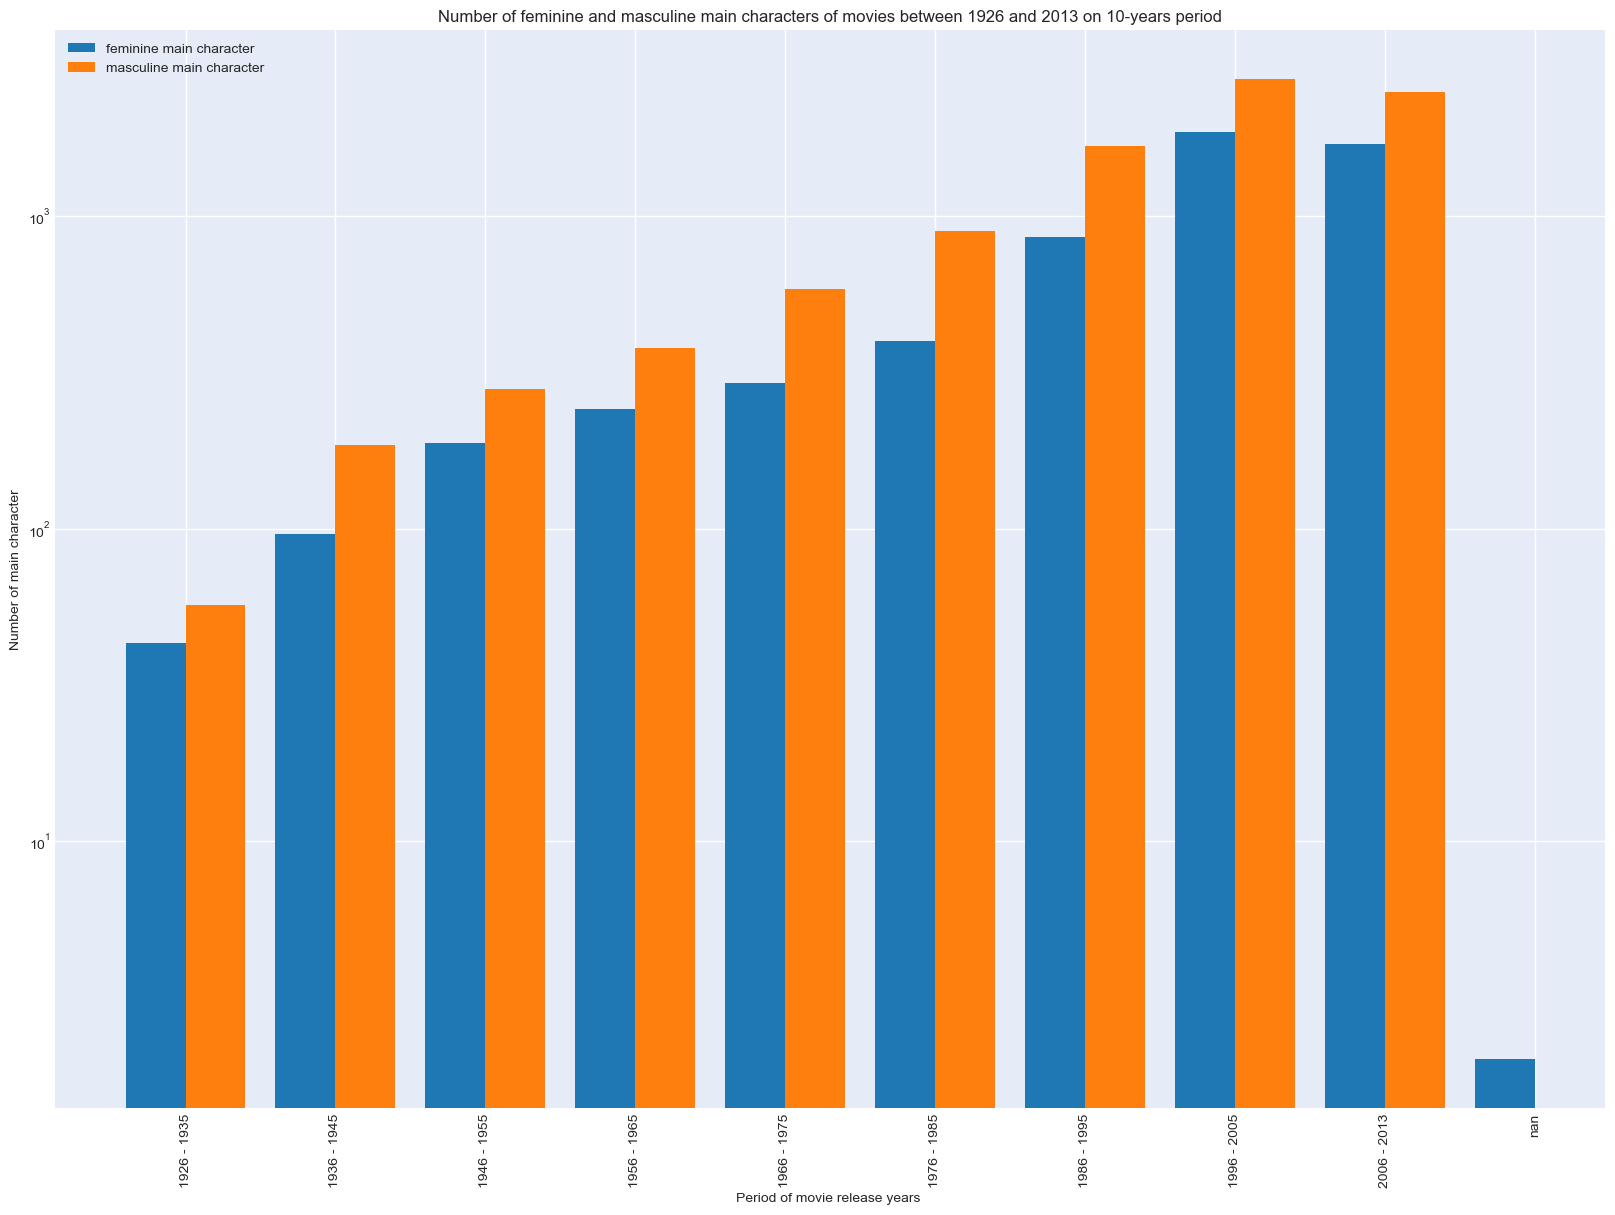

In [1791]:
# main character gender per period - bar plot
X_axis = np.arange(len(character_occurence_P.index))

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.bar(X_axis - 0.2, character_occurence_P['F_count'], 0.4, label = 'feminine main character') # doesn't plot lables!!
plt.bar(X_axis + 0.2, character_occurence_P['M_count'], 0.4, label = 'masculine main character')

plt.xticks(X_axis, character_occurence_P['PERIOD'], rotation=90)
plt.title(f"Number of feminine and masculine main characters of movies between {start_year} and {end_year} on 10-years period")
plt.xlabel("Period of movie release years ") 
plt.ylabel("Number of main character") 
plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

In [1792]:
# group by and plot the number of main characters per year for both genders
character_occurence_grY = character_occurence.groupby(['Movie_release_year','Character_gender']).agg('count')

character_occurence_F_year = character_occurence_grY.xs('F', level=1).rename(columns={"Freebase_movie_ID": "F_count"}).drop(['Main_character_name','PERIOD'], axis=1)
character_occurence_M_year = character_occurence_grY.xs('M', level=1).rename(columns={"Freebase_movie_ID": "M_count"}).drop(['Main_character_name','PERIOD'], axis=1)

character_occurence_Y = pd.concat([character_occurence_F_year, character_occurence_M_year], axis=1).dropna().reset_index()


character_occurence_Y

,Movie_release_year,F_count,M_count
0,1926,3,2.0
1,1928,5,5.0
2,1929,3,6.0
3,1930,2,3.0
4,1931,4,4.0
...,...,...,...
82,2009,273,397.0
83,2010,255,386.0
84,2011,227,350.0
85,2012,83,154.0


> During years with few movies, there are sometimes no feminine nor masculine main characters. In this case, the count is thus a NaN and we decide to drop these rows.

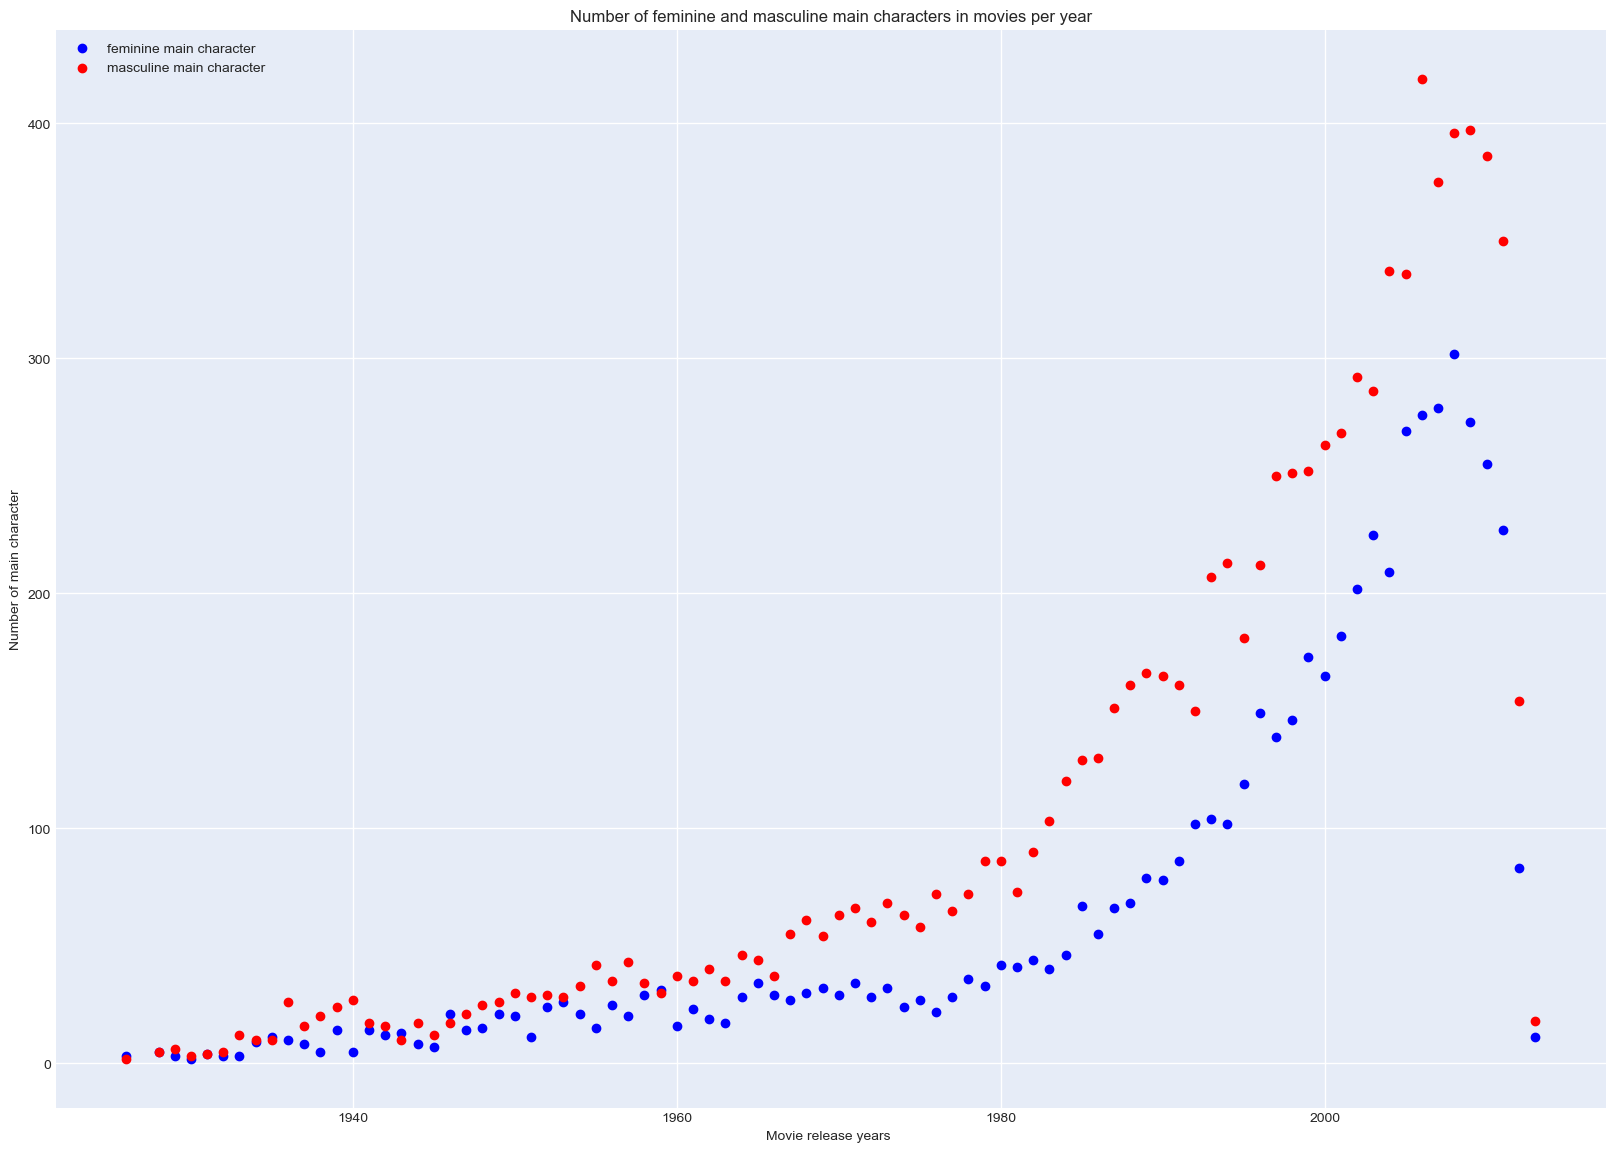

In [1793]:
# plot of number of M and F main characters for each year

X_axis = np.arange(len(character_occurence_Y.Movie_release_year))

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(character_occurence_Y.Movie_release_year, character_occurence_Y['F_count'], label = 'feminine main character', color='blue') 
plt.scatter(character_occurence_Y.Movie_release_year, character_occurence_Y['M_count'], label = 'masculine main character', color='red')# doesn't plot lables!!
plt.title(f"Number of feminine and masculine main characters in movies per year")
plt.xlabel("Movie release years ") 
plt.ylabel("Number of main character") 
#plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

We decide to perform the linear regression on movies between 1970 and 2011, in order to discard the outliers that translates that we have few data only: a few movies only are treated during a year. On this period, the fast increasing trend of number of main characters (compared to less steep slope before), both for feminine and masculine characters, is due to the increase of number of movies released each year (so more data). This is why we consider this reduced period for the linear regression only.

In [1794]:
character_occurence_Y['perc_fem'] = character_occurence_Y['F_count']/(character_occurence_Y['M_count']+character_occurence_Y['F_count'])
character_occurence_Y['perc_masc'] = character_occurence_Y['M_count']/(character_occurence_Y['M_count']+character_occurence_Y['F_count'])

character_occurence_Y_reduced=character_occurence_Y[(character_occurence_Y['Movie_release_year'] >= 1970)&(character_occurence_Y['Movie_release_year'] <= 2011)]


In [1795]:
# perform linear regression on main characters for each year
np.random.seed(1)

model_fem_year = smf.ols(formula='F_count ~ Movie_release_year', data=character_occurence_Y_reduced).fit()
model_masc_year = smf.ols(formula='M_count ~ Movie_release_year', data=character_occurence_Y_reduced).fit()

prediction_fem_1 = model_fem_year.predict(character_occurence_Y_reduced)
prediction_masc_1 = model_masc_year.predict(character_occurence_Y_reduced)


In [1796]:
print(model_fem_year.summary())

                            OLS Regression Results                            
Dep. Variable:                F_count   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     317.4
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.26e-20
Time:                        13:24:11   Log-Likelihood:                -201.60
No. Observations:                  42   AIC:                             407.2
Df Residuals:                      40   BIC:                             410.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.348e+04    763

> The "R-squared" value of 0.888 indicates that the model explains 88.8% of the variance in the dependent variable. The "Adjusted R-squared" value of 0.885 is a modified version of R-squared that adjusts for the number of predictors in the model.

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the extremely small p-value (1.26e-20) indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is 6.83, which suggests that for every unit increase in the year in which a movie is released, the percentage of female main characters is expected to increase by 6.83. The intercept term of -1.348e+04 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


In [1797]:
print(model_masc_year.summary())

                            OLS Regression Results                            
Dep. Variable:                M_count   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     553.2
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           4.89e-25
Time:                        13:24:11   Log-Likelihood:                -201.42
No. Observations:                  42   AIC:                             406.8
Df Residuals:                      40   BIC:                             410.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.769e+04    760


> The "R-squared" value of 0.933 indicates that the model explains 93.3% of the variance in the dependent variable. The "Adjusted R-squared" value of 0.931 is a modified version of R-squared that adjusts for the number of predictors in the model.

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the extremely small p-value (4.65e-25) indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is 8.9807, which suggests that for every unit increase in the year in which a movie is released, the percentage of female main characters is expected to increase by 8.9807. The intercept term of -1.768e+04  represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


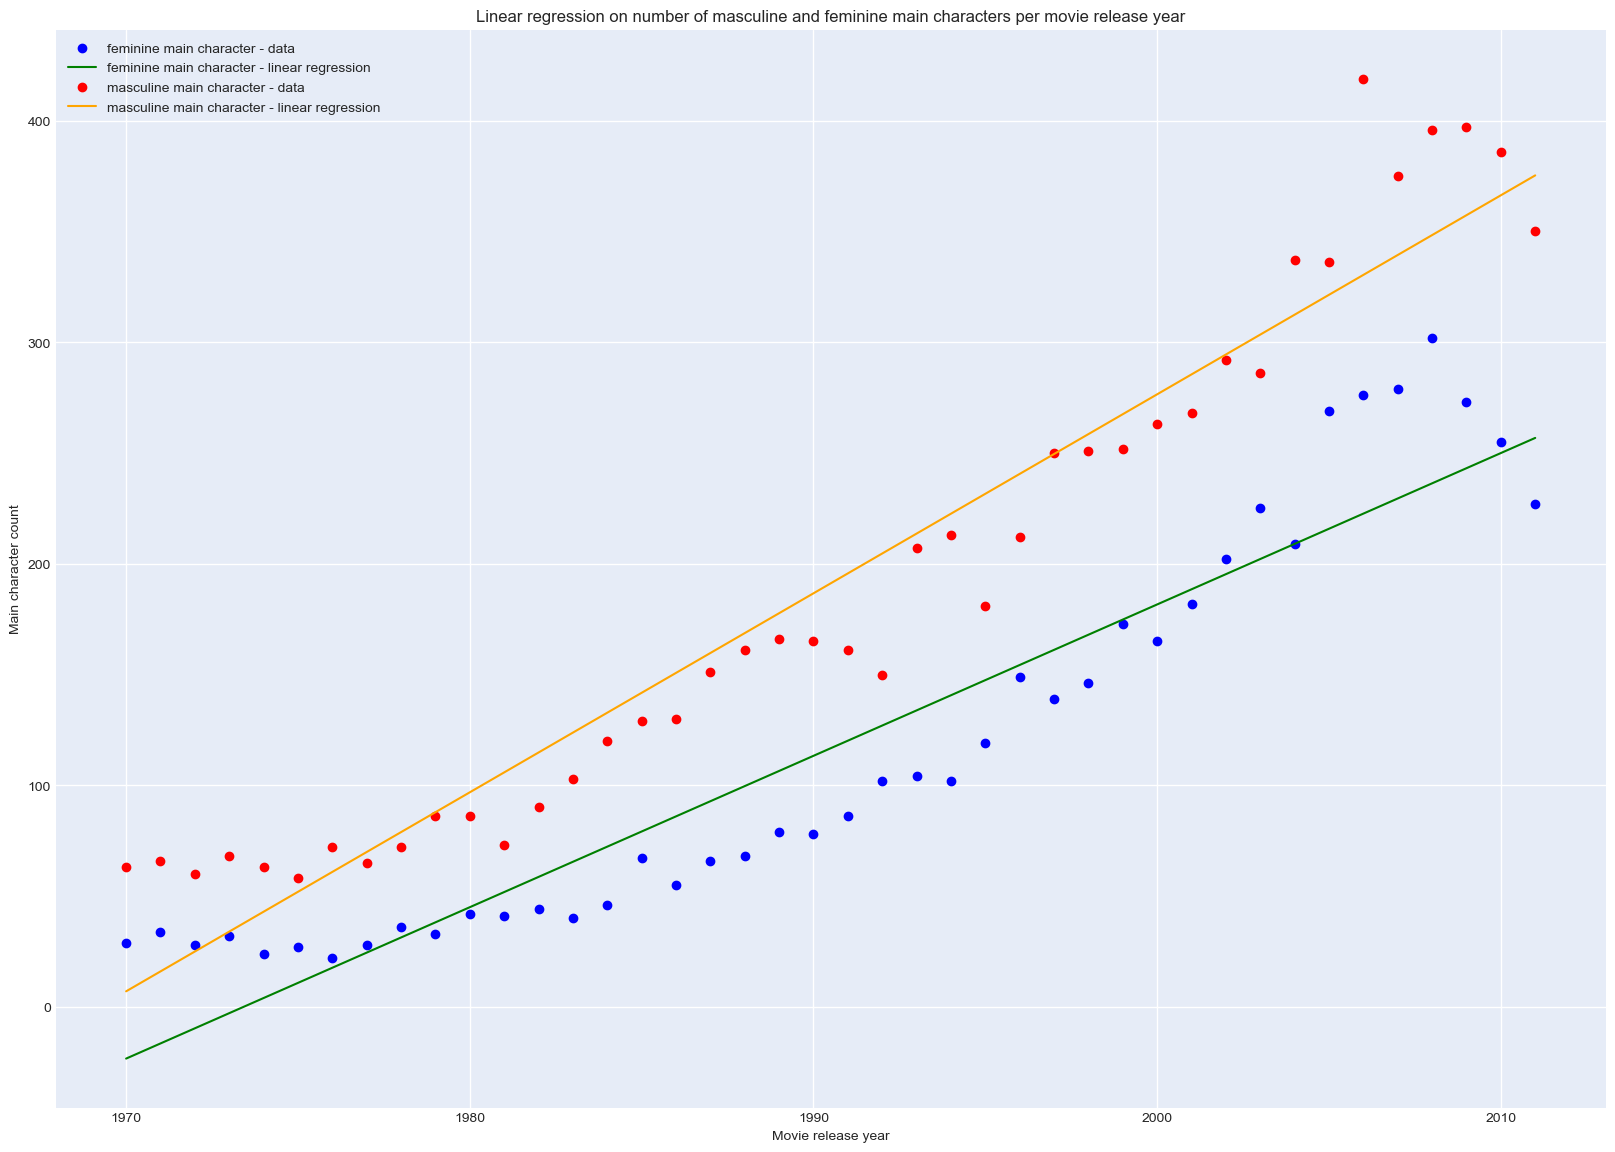

In [1798]:
# perform linear regression on main characters for each year - between 1970 and 2011

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(character_occurence_Y_reduced.Movie_release_year, character_occurence_Y_reduced['F_count'], label = 'feminine main character - data', color='blue') 
plt.plot(character_occurence_Y_reduced.Movie_release_year, prediction_fem_1, label = 'feminine main character - linear regression', color='green')

plt.scatter(character_occurence_Y_reduced.Movie_release_year, character_occurence_Y_reduced['M_count'], label = 'masculine main character - data', color='red')# doesn't plot lables!!
plt.plot(character_occurence_Y_reduced.Movie_release_year, prediction_masc_1, label = 'masculine main character - linear regression', color='orange')

plt.title('Linear regression on number of masculine and feminine main characters per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Main character count")
plt.xlabel("Movie release year")
#plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

> We observe there are more masculine than feminine main characters, but the difference between both numbers doesn't show a gap as large than for the overall number of characters in movies. The representation of women on screen for the main character main criterion is better than for characters in general (ratio of 1 woman for 2 men). Still, as there are more masculine than feminine character, it is logical that this trend reflects a little bit at least on main characters. We decided to perform a linear regression on the percentage of main character per gender for the reduced period as well.

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1811311822.py:14: UserWarning: Legend does not support 'F' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('Feminine main character', 'Masculine main character')
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1811311822.py:14: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('Feminine main character', 'Masculine main character')
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1811311822.py:14: UserWarning: Legend does not support 'm' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-l

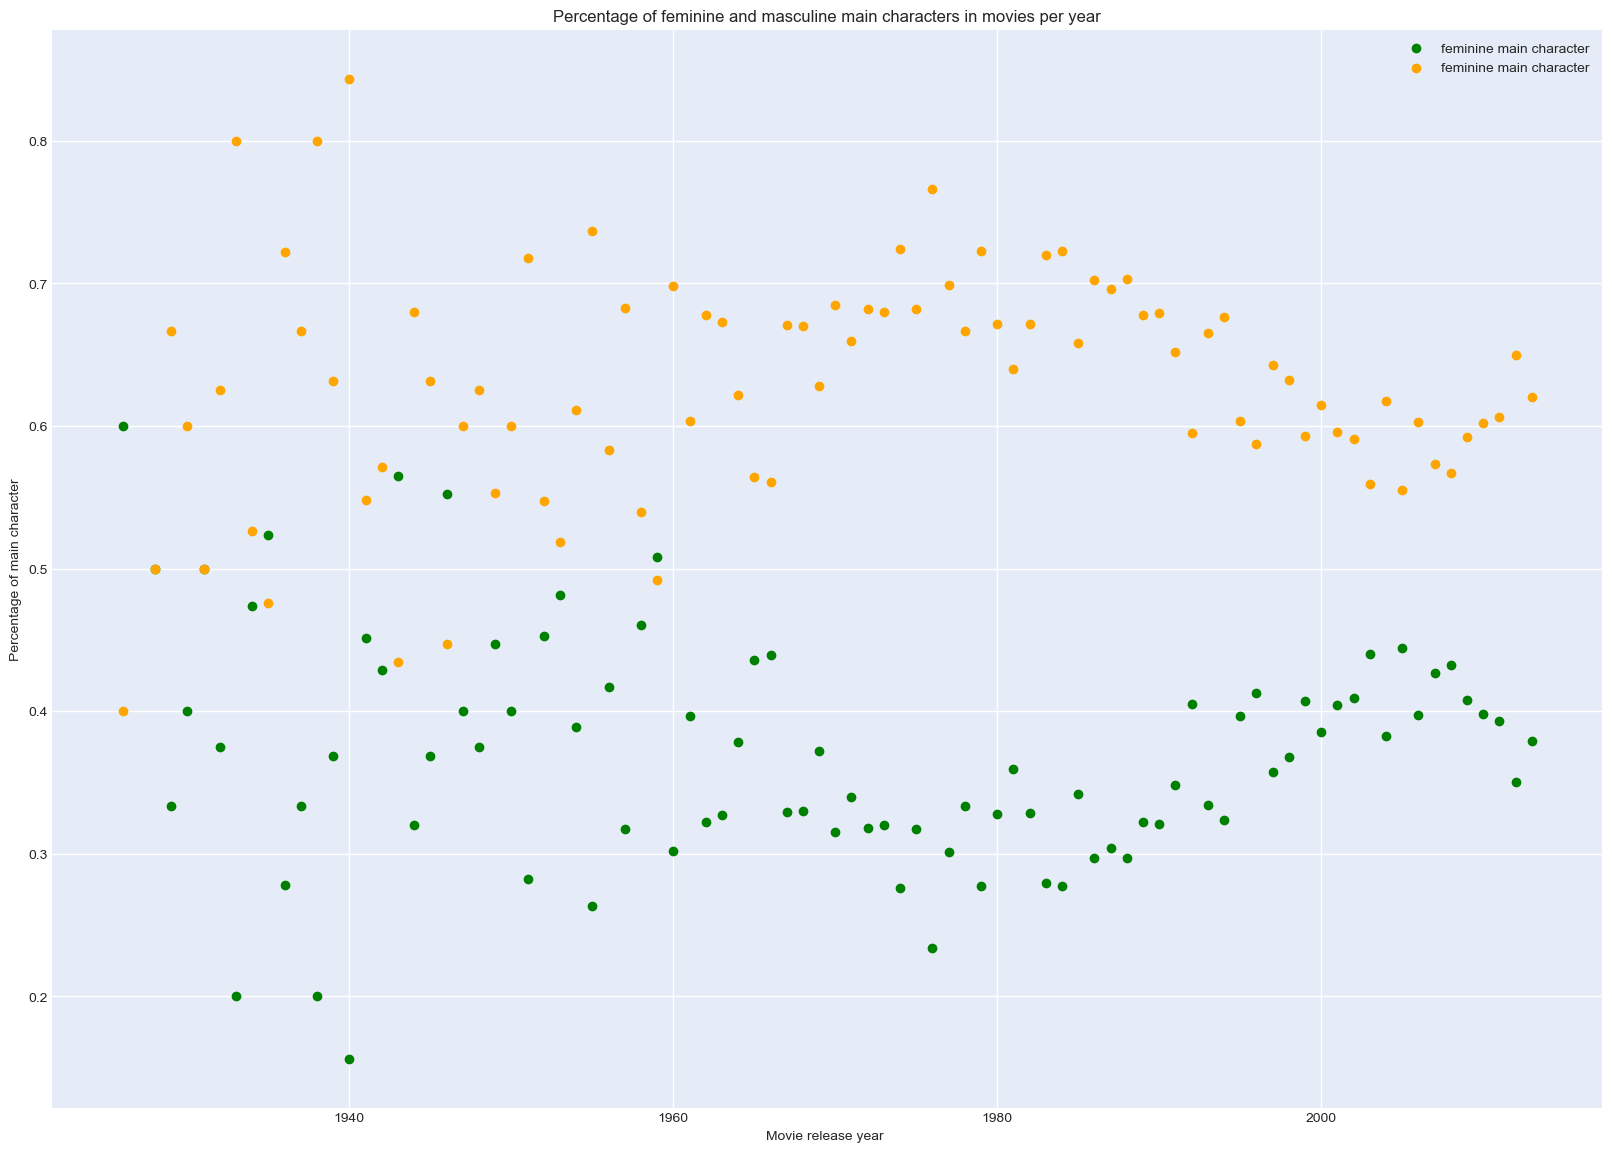

In [1799]:
# perform linear regression on percentage per gender of main characters for each year

X_axis = np.arange(len(character_occurence_Y.Movie_release_year))

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(character_occurence_Y.Movie_release_year, character_occurence_Y['perc_fem'], label = 'feminine main character', color='green')
plt.scatter(character_occurence_Y.Movie_release_year, character_occurence_Y['perc_masc'], label = 'feminine main character', color='orange')

plt.title(f"Percentage of feminine and masculine main characters in movies per year")
plt.xlabel("Movie release year ") 
plt.ylabel("Percentage of main character") 
#plt.yscale('log')
plt.legend('Feminine main character', 'Masculine main character')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

We proceed now to a linear regression on main characters percentage on the reduced period of 1970-2011.

In [1800]:
# perform linear regression on main characters for each year on reduced period 1970-2011
np.random.seed(1)

model_fem_year = smf.ols(formula='perc_fem ~ Movie_release_year', data=character_occurence_Y_reduced).fit()
model_masc_year = smf.ols(formula='perc_masc ~ Movie_release_year', data=character_occurence_Y_reduced).fit()

prediction_fem_1 = model_fem_year.predict(character_occurence_Y_reduced)
prediction_masc_1 = model_masc_year.predict(character_occurence_Y_reduced)


In [1801]:
print(model_fem_year.summary())

                            OLS Regression Results                            
Dep. Variable:               perc_fem   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     69.77
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.64e-10
Time:                        13:24:12   Log-Likelihood:                 85.759
No. Observations:                  42   AIC:                            -167.5
Df Residuals:                      40   BIC:                            -164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.4597      0

> The R-squared value of 0.636 indicates that the model explains about 64% of the variance in the dependent variable. The adjusted R-squared value of 0.627 takes into account the number of observations and the number of variables in the model and gives a slightly lower estimate of the model's explanatory power.

> The F-statistic of 69.91 and the corresponding p-value of 2.58e-10 suggest that the model as a whole is significant. The t-statistic for the "Movie_release_year" variable is 8.361, and the corresponding p-value is less than 0.000. This suggests that the "Movie_release_year" variable is significant in predicting the dependent variable.

> The coefficient for "Movie_release_year" is 0.0034, which suggests that for every unit increase in the year in which a movie is released, the percentage of female main characters is expected to increase by 0.0034. The intercept term of -6.4676 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


In [1802]:
print(model_masc_year.summary())

                            OLS Regression Results                            
Dep. Variable:              perc_masc   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     69.77
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.64e-10
Time:                        13:24:12   Log-Likelihood:                 85.759
No. Observations:                  42   AIC:                            -167.5
Df Residuals:                      40   BIC:                            -164.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.4597      0

> The R-squared value of 0.636 indicates that the model explains about 64% of the variance in the dependent variable. The adjusted R-squared value of 0.627 takes into account the number of observations and the number of variables in the model and gives a slightly lower estimate of the model's explanatory power.

> The F-statistic of 69.91 and the corresponding p-value of 2.58e-10 suggest that the model as a whole is significant. The t-statistic for the "Movie_release_year" variable is -8.361, and the corresponding p-value is less than 0.000. This suggests that the "Movie_release_year" variable is significant in predicting the dependent variable.

> The coefficient for "Movie_release_year" is -0.0034, which suggests that for every unit increase in the year in which a movie is released, the percentage of male main characters is expected to decrease by 0.0034. The intercept term of 7.4676 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


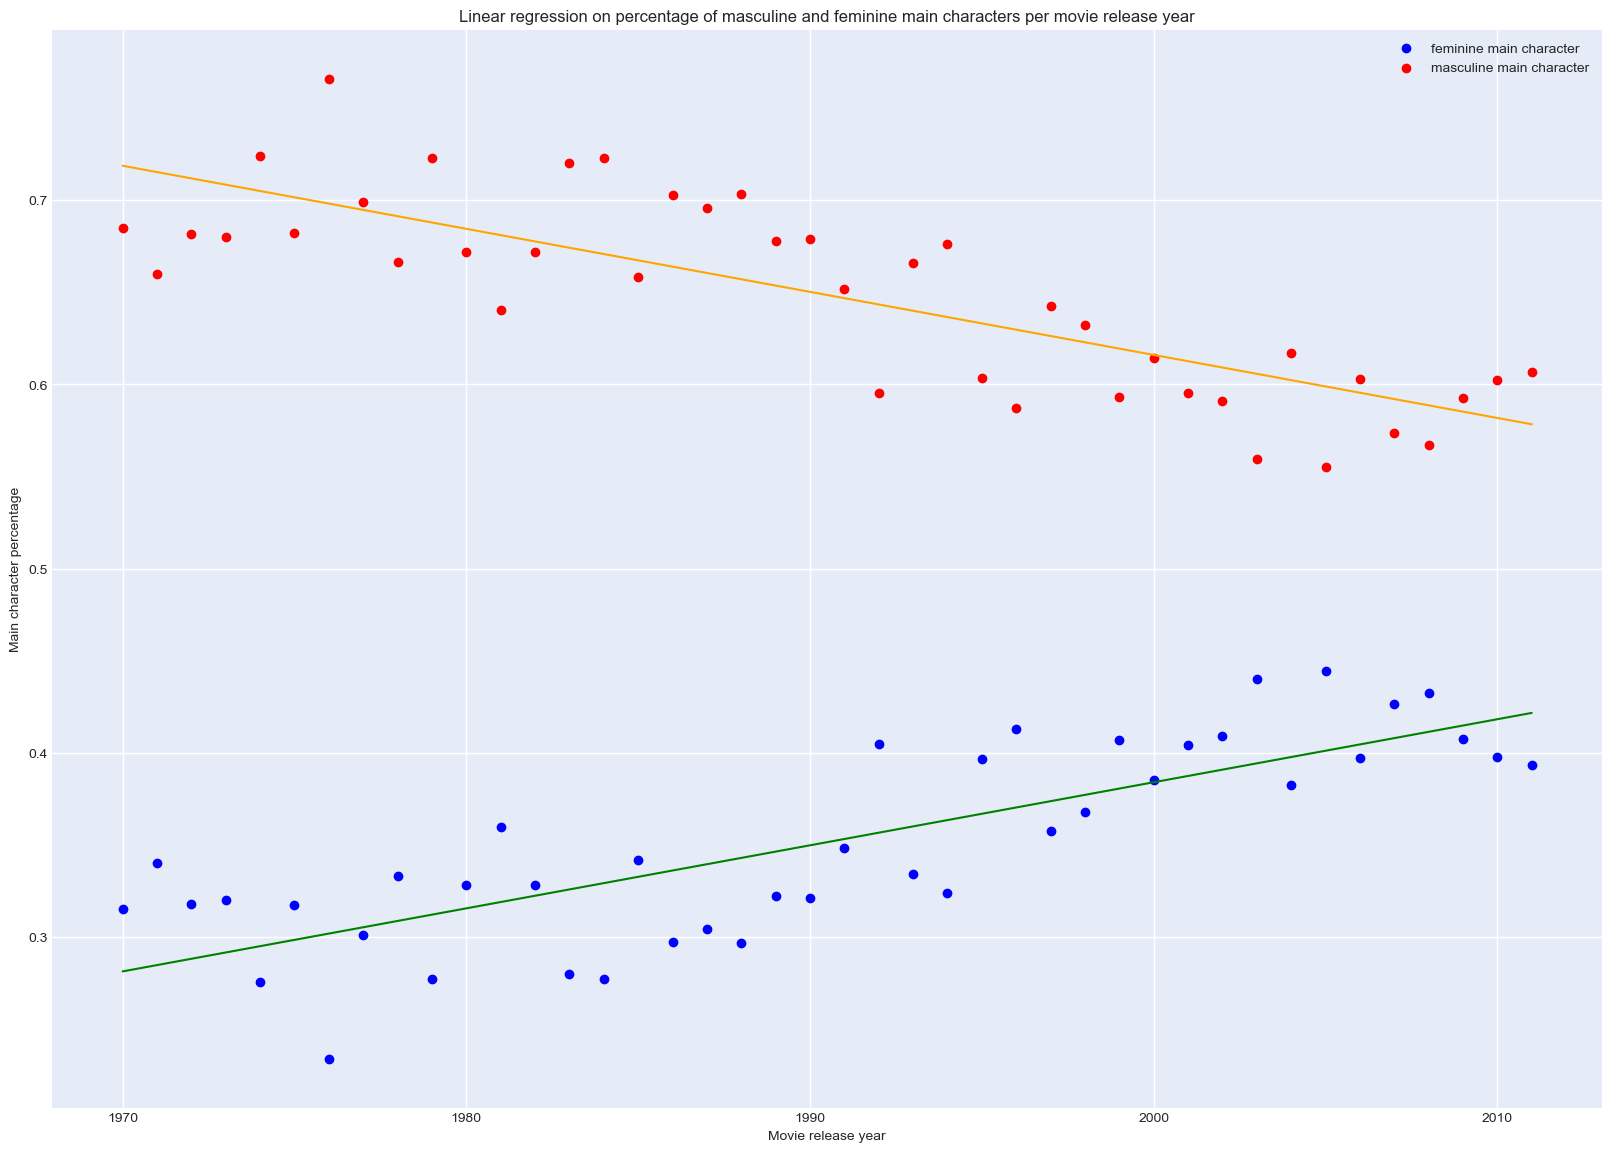

In [1803]:
fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(character_occurence_Y_reduced.Movie_release_year, character_occurence_Y_reduced['perc_fem'], label = 'feminine main character', color='blue') 
plt.plot(character_occurence_Y_reduced.Movie_release_year, prediction_fem_1, color='green')

plt.scatter(character_occurence_Y_reduced.Movie_release_year, character_occurence_Y_reduced['perc_masc'], label = 'masculine main character', color='red')# doesn't plot lables!!
plt.plot(character_occurence_Y_reduced.Movie_release_year, prediction_masc_1, color='orange')

plt.title('Linear regression on percentage of masculine and feminine main characters per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Main character percentage")
plt.xlabel("Movie release year")
#plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

> From plot, we clearly see that there are more and more feminine main characters in proportion and that there is also less masculine main characters (real gap representation). This increasing trend is observed on a 40-years period, between 1970 ad 2011. As both models give statistically significant results (they are statistically significant as a whole), from the statistics of the OSL regressions, we can conclude that, in term of women representation on screen as main character of movies, the gender gap decreased on the studied period.

> **This is a very important result, as we know that female role models (for example, in the form of movie main characters) are key to accelerating gender equality.**

##  B. What are women associated with? How do we talk about these women? <a name="Association"> </a>

### i. Associate words/champ lexical in summaries in function of movie_gender [F; M] which is based on the gender of the main actor


In [1804]:
# merge character_occurence with plot_summaries on Freebase_movie_ID

# create a column movie_gender in plot_summaries in function of gender of main character in character_occurence dataset

# do the NLP algorithm to split words in F, M and both gender categories





#### In general

#### Group by year

#### Group by movie genres

#### Visualization: scatter plot, words viz

### ii. Associate tropes/stereotypes to women and men

#### From tropes_cluster, classify not obvious tropes into feminine or masculine 


#### Identify ideas that come out of these tropes from both categories (topic detection)

#### Identify if there are equivalent tropes between men and women

#### Look at evolution of tropes, link with topic detection on summaries, see evolution of topics in summaries for main character F and M

## C. What kind of roles or jobs done by women are the most appreciated? In which context do people like to see women? <a name="Roles"> </a>

### i. From IMDB ratings, check number of women between high and low score movies

First, we need to associate the ratings from IMDb with the movies we have from movie_metadata.

In [1805]:
# merge movie_metadata and character_metadata on Freebase_movie_ID and Movie_release_date to have a combination of actors, genders and movie titles
actor_title = movie_metadata.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID']).drop(['Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries'], axis=1)

# drop rows where character_name = Nan
actor_title = actor_title.dropna(subset=['Character_name'])

In [1806]:
print('There are %2d unique movies in the actor_title dataset.' %(actor_title[['Movie_name']].nunique()))
print('There are %2d unique movies in the IMDb dataset.' %(IMDb_ratings[['Movie_name']].nunique()))


There are 30614 unique movies in the actor_title dataset.
There are 58429 unique movies in the IMDb dataset.


In [1807]:
# create a dataset with the IMDB_rating and the number of votes and the character name and gender for each movie in common of IMDb_ratings and actor_movie
movie_ratings = IMDb_ratings.merge(actor_title, on='Movie_name', how='left')

# drop rows where there is no freebase_movie_id
movie_ratings = movie_ratings.dropna(subset='Freebase_movie_ID').drop(['Movie_genres_x'], axis=1).rename(columns={'Movie_genres_y': 'Movie_genres'})

In [1808]:
print('There are %2d unique movies in the combination of given and IMDb data, the movie_ratings dataset.' %(movie_ratings[['Movie_name']].nunique()))


There are 15527 unique movies in the combination of given and IMDb data, the movie_ratings dataset.


Our further analysis on gender gap through ratings will thus be based on 15527 movies.

> The movie release years from IMDb don't correspond to the movie release date from the given dataset. Does that mean that those are not the same movies, even if they have the same name? We decide to ignore this anomaly for the rest of the analysis by dropping the movie release year from IMDb.

In [1809]:
# drop IMDb release year for movies as they don't correspond to given data sets movies release years
movie_ratings = movie_ratings.drop(['Movie_release_year'], axis=1)

In [1810]:
# count the number of masculie vs. feminine character for each movie and put it in column F and M
FM = movie_ratings.groupby(['Movie_name', 'Actor_gender']).size().unstack(fill_value=0)

# keep only 1 line per movie
movie_ratings_FM = movie_ratings.merge(FM, on='Movie_name', how='left').drop_duplicates(subset='Movie_name', keep="first")

movie_ratings_FM

,IMDb_rating,IMDb_votes,titleType,Movie_name,Freebase_movie_ID,Movie_release_date,Movie_genres,Character_name,Actor_gender,F,M
0,4.3,23,movie,Robbery Under Arms,/m/0bhcws6,1985-03-28,"[History, Western, Action, Drama, Adventure]",Capt. Starlight,M,0.0,14.0
7,5.2,66,movie,The Fairylogue and Radio-Plays,/m/0fgfyy,1908-09-24,"[Silent film, Black-and-white]",Dorothy Gale,F,1.0,1.0
9,4.7,38,movie,Hamlet,/m/0dtx8p,1921-01-10,[Drama],Gertrude,F,153.0,603.0
95,5.1,537,movie,Cleopatra,/m/04lghwf,1912-11-13,"[History, Silent film, Drama]",Cleopatra,F,40.0,108.0
133,5.8,597,movie,From the Manger to the Cross,/m/0jr0h,1912-10-03,"[Christian film, Silent film, Drama, Indie, Bl...",Lazarus,NaN,3.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
144462,7.4,2273,movie,Digger,/m/043n0k0,1993-01-01,"[Romance Film, Childhood Drama]",Billy,M,0.0,2.0
144470,7.3,14953,movie,Bala,/m/0f6gc3,2002-01-01,"[Action/Adventure, Drama, Tamil cinema, World ...",Aarthi,F,1.0,2.0
144480,3.0,905,movie,Jumbo,/m/051z4n5,2008-12-25,"[Family Film, Animation]",Jumbo,M,2.0,2.0
144501,5.8,7600,movie,Pati Patni Aur Woh,/m/02qnjpw,1978-01-01,"[Romantic comedy, World cinema, Drama, Comedy,...",Sharda Chhadha,F,3.0,1.0


Movies are rated out of 10. Let's determine a threshold mean score: movies with ratings below this threshold score will be considered as low score movies and movies with ratings above this threshold score will be considered as high score movies. 

In [1811]:
threshold = movie_ratings_FM['IMDb_rating'].mean()
print('The mean score for IMDb ratings is equal to %2f.' %(threshold)) 


The mean score for IMDb ratings is equal to 6.104045.


We create a low_rating dataframe and a high_score dataframe.

In [1812]:
low_rating = movie_ratings_FM[movie_ratings_FM['IMDb_rating'] < threshold]
high_rating = movie_ratings_FM[movie_ratings_FM['IMDb_rating'] >= threshold]

In [1813]:
print('The length of the low rating data set is of {}.' .format(len(low_rating)))
print('The length of the high rating data set is of {}.' .format(len(high_rating)))

The length of the low rating data set is of 7126.
The length of the high rating data set is of 8401.


Compare mean number of fem_count and masc_count between high and low ratings datasets

In [1814]:
# For low rated movies under threshold
print('Number of women characters in low rated movies: {}.' .format(low_rating.F.mean()))
print('Number of men characters in low rated movies: {}.' .format(low_rating.M.mean()))
print('Percentage of women characters in low rated movies: {}.' .format(low_rating.F.sum()/(low_rating.F.sum()+low_rating.M.sum())))
print('Percentage of men characters in low rated movies: {}.' .format(low_rating.M.sum()/(low_rating.F.sum()+low_rating.M.sum())))

Number of women characters in low rated movies: 2.940365682137834.
Number of men characters in low rated movies: 5.228270042194093.
Percentage of women characters in low rated movies: 0.3599579882573736.
Percentage of men characters in low rated movies: 0.6400420117426264.


In [1815]:
# For high rated movies under threshold
print('Number of women characters in high rated movies: {}.' .format(high_rating.F.mean()))
print('Number of men characters in high rated movies: {}.' .format(high_rating.M.mean()))
print('Percentage of women characters in high rated movies: {}.' .format(high_rating.F.sum()/(high_rating.F.sum()+high_rating.M.sum())))
print('Percentage of men characters in high rated movies: {}.' .format(high_rating.M.sum()/(high_rating.F.sum()+high_rating.M.sum())))

Number of women characters in high rated movies: 3.2962786259541983.
Number of men characters in high rated movies: 6.398139312977099.
Percentage of women characters in high rated movies: 0.3400182091094761.
Percentage of men characters in high rated movies: 0.6599817908905239.


In [1816]:
print('Absolute difference of women characters between high and low rated movies: {}.' .format(high_rating.F.mean()-low_rating.F.mean()))
print('Absolute difference of men characters between high and low rated movies: {}.' .format(high_rating.M.mean()-low_rating.M.mean()))

Absolute difference of women characters between high and low rated movies: 0.3559129438163642.
Absolute difference of men characters between high and low rated movies: 1.169869270783006.


In [1817]:
print('Relative difference of women characters between high and low rated movies: {}.' .format((high_rating.F.mean()-low_rating.F.mean())/(high_rating.F.mean())))
print('Relative difference of men characters between high and low rated movies: {}.' .format((high_rating.M.mean()-low_rating.M.mean())/(high_rating.M.mean())))

Relative difference of women characters between high and low rated movies: 0.10797416851050794.
Relative difference of men characters between high and low rated movies: 0.18284523258351149.


> Comparing the number of woman in low/high rated movies, there is on average 0.36 more women in high rated movies. The relative increase is of 11% between the two groups.
> Comparing the number of men in low/high rated movies, there is on average 1.17 more men in high rated movies. The relative increase is of 18%.

> The results are not significant. Due to the increase of the number of characters in both movie ratings groups, independently of gender, we could think that a significant feature that impact the ratings is the overall number of characters in a movie, and not the gender of each character. A confounder of these could be the budget of a movie: a higher budget movie will most probably produce a more liked movie (higher ratings on IMDb) and having a higher budget also allow the production to hire more actors and develop more characters for the same movie.

In [1818]:
print('Total number of characters in low rated movies: {}.' .format((low_rating.F+low_rating.M).mean()))
print('Total number of characters in high rated movies: {}.' .format((high_rating.F+high_rating.M).mean()))

Total number of characters in low rated movies: 8.168635724331926.
Total number of characters in high rated movies: 9.694417938931299.


In [1819]:
print('Total number of characters in high rated movies: {}.' .format((high_rating.F+high_rating.M).mean()-(low_rating.F+low_rating.M).mean()))

Total number of characters in high rated movies: 1.5257822145993725.


There is indeed on average 1.5 more characters in high ratings movies.

### ii. Compare rating of two movies where main actor is F and M 


##### Attribute a gender to each movie based on gender of main_character

In [1820]:
# we remove unuseful information from the data frame: character name and gender (not main character)
movie_ratings_FM = movie_ratings_FM.drop(['Character_name'], axis=1)


# merge character_occurence (main character detetcion) with movie_ratings on Freebase_movie_ID to have column actor_gender = main_char_gender  
movie_gender = movie_ratings_FM.merge(character_occurence[['Freebase_movie_ID','Character_gender']], on='Freebase_movie_ID', how='left').rename(columns={'Actor_gender': 'Main_character_gender'})
movie_gender = movie_gender.dropna(subset=['Main_character_gender'])

##### First ratings comparison in function of gender

In [1821]:
# mean rating and votes for the different main character genders
rating_grouped = movie_gender.groupby('Main_character_gender')['IMDb_rating','IMDb_votes'].agg('mean')
rating_grouped

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1987061025.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_grouped = movie_gender.groupby('Main_character_gender')['IMDb_rating','IMDb_votes'].agg('mean')


,IMDb_rating,IMDb_votes
Main_character_gender,,
F,6.036923,27325.766755
M,6.146344,38347.426833


> The mean IMDb rating for movies where the main character is a woman is: 6.09.
> The mean IMDb rating for movies where the main character is a man is: 6.22.
The difference between both scores for man and woman is of 0.13 (out of a total score of 10). It is thus a difference between both of 0.013%.

> What we also see is that there are more votes for movies where the main character is a man (more than 25.000 votes). More votes for a movie implies more people watching the rated movie, or more people susceptible of rating a movie watching this movie. 

> If indeed more votes implies more people watching the rated movie, people are more attracted without watching by movies where the main character is a man.

##### Compare rating in function of the **movie genre** by gender

In [1822]:
movie_gender

,IMDb_rating,IMDb_votes,titleType,Movie_name,Freebase_movie_ID,Movie_release_date,Movie_genres,Main_character_gender,F,M,Character_gender
0,4.3,23,movie,Robbery Under Arms,/m/0bhcws6,1985-03-28,"[History, Western, Action, Drama, Adventure]",M,0.0,14.0,NaN
1,5.2,66,movie,The Fairylogue and Radio-Plays,/m/0fgfyy,1908-09-24,"[Silent film, Black-and-white]",F,1.0,1.0,NaN
2,4.7,38,movie,Hamlet,/m/0dtx8p,1921-01-10,[Drama],F,153.0,603.0,NaN
3,5.1,537,movie,Cleopatra,/m/04lghwf,1912-11-13,"[History, Silent film, Drama]",F,40.0,108.0,NaN
5,5.0,38,movie,Oliver Twist,/m/04jffj,1997-01-01,"[Television movie, Family Drama, Period piece,...",M,72.0,300.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15672,7.4,2273,movie,Digger,/m/043n0k0,1993-01-01,"[Romance Film, Childhood Drama]",M,0.0,2.0,NaN
15673,7.3,14953,movie,Bala,/m/0f6gc3,2002-01-01,"[Action/Adventure, Drama, Tamil cinema, World ...",F,1.0,2.0,NaN
15674,3.0,905,movie,Jumbo,/m/051z4n5,2008-12-25,"[Family Film, Animation]",M,2.0,2.0,M
15675,5.8,7600,movie,Pati Patni Aur Woh,/m/02qnjpw,1978-01-01,"[Romantic comedy, World cinema, Drama, Comedy,...",F,3.0,1.0,F


In [1823]:
# explode movie_genres columns into sub rows in order to treat movie genre by movie genre
movie_genre = movie_gender.explode('Movie_genres')

# extract mean rating per movie genre
rating_per_genre = movie_genre.groupby('Movie_genres')['IMDb_rating','IMDb_votes'].agg('mean')

rating_per_genre

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/2009870946.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_genre = movie_genre.groupby('Movie_genres')['IMDb_rating','IMDb_votes'].agg('mean')


,IMDb_rating,IMDb_votes
Movie_genres,,
Absurdism,6.267606,84633.239437
Acid western,6.457143,6461.857143
Action,5.864112,61295.086338
Action Comedy,5.896154,85633.448718
Action Thrillers,5.833071,86896.405512
...,...,...
Women in prison films,5.650000,1919.000000
Workplace Comedy,6.364407,63105.694915
World cinema,6.223141,12803.441578


Text(0.5, 1.0, 'Mean rating of movies for movie genres')

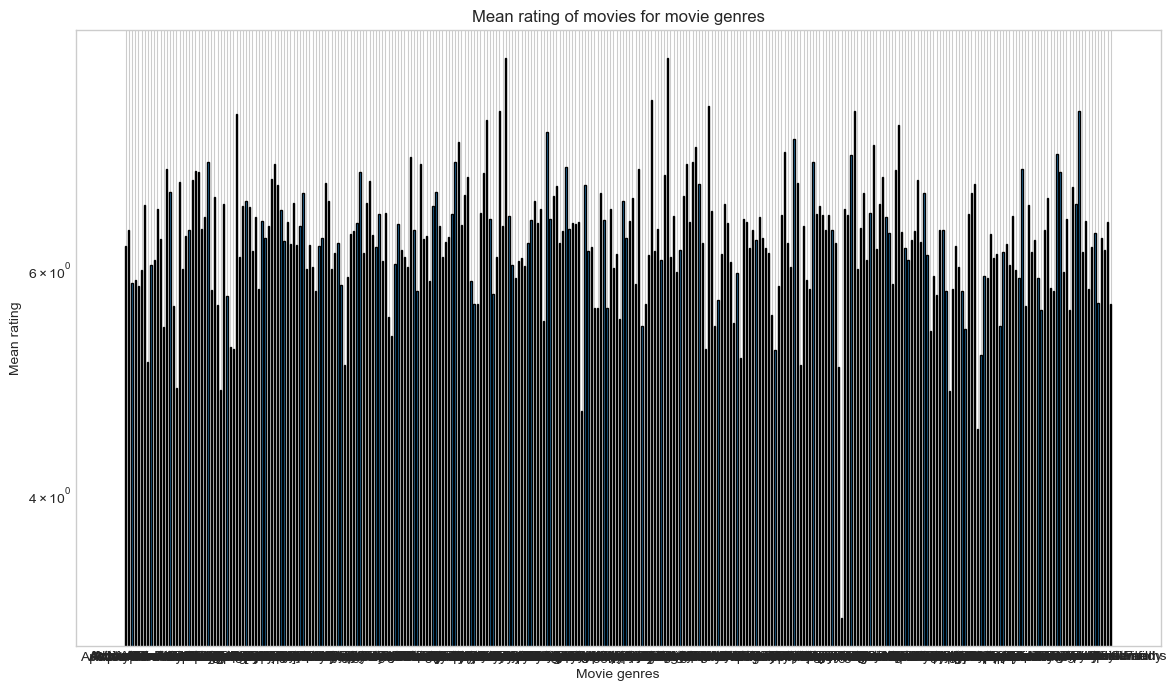

In [1824]:
# plot the mean rating per movie genre 

plt.figure(figsize=(14,8))
plt.bar(rating_per_genre.index, rating_per_genre['IMDb_rating'], 0.4, edgecolor = 'black')

plt.xlabel("Movie genres")
plt.yscale('log')
plt.ylabel("Mean rating")
plt.title("Mean rating of movies for movie genres")

> **As there are 293 different movie genres, the visualization is unreadable. In order to have less genres to analyze, we should cluster genres into categories.**

In [1825]:
# proceed to movie genres grouping
movie_gender=movie_gender.explode('Movie_genres')
movie_gender['Movie_genres'] = movie_gender['Movie_genres'].apply(group_genres)

#only keep the genres with more than 100 movies
movie_gender=movie_gender.groupby('Movie_genres').filter(lambda x: len(x) > 500)
movie_gender=movie_gender.drop_duplicates(subset=['Freebase_movie_ID'], keep='first')
movie_gender

,IMDb_rating,IMDb_votes,titleType,Movie_name,Freebase_movie_ID,Movie_release_date,Movie_genres,Main_character_gender,F,M,Character_gender
0,4.3,23,movie,Robbery Under Arms,/m/0bhcws6,1985-03-28,Biography,M,0.0,14.0,NaN
1,5.2,66,movie,The Fairylogue and Radio-Plays,/m/0fgfyy,1908-09-24,Black-and-white,F,1.0,1.0,NaN
2,4.7,38,movie,Hamlet,/m/0dtx8p,1921-01-10,Drama,F,153.0,603.0,NaN
3,5.1,537,movie,Cleopatra,/m/04lghwf,1912-11-13,Biography,F,40.0,108.0,NaN
5,5.0,38,movie,Oliver Twist,/m/04jffj,1997-01-01,Drama,M,72.0,300.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15672,7.4,2273,movie,Digger,/m/043n0k0,1993-01-01,Romance,M,0.0,2.0,NaN
15673,7.3,14953,movie,Bala,/m/0f6gc3,2002-01-01,Action,F,1.0,2.0,NaN
15674,3.0,905,movie,Jumbo,/m/051z4n5,2008-12-25,Family Film,M,2.0,2.0,M
15675,5.8,7600,movie,Pati Patni Aur Woh,/m/02qnjpw,1978-01-01,Romance,F,3.0,1.0,F


In [1826]:
# extract mean rating per movie genre
rating_per_genre = movie_gender.groupby('Movie_genres')['IMDb_rating','IMDb_votes'].agg('mean').reset_index()

rating_per_genre

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/225821518.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_genre = movie_gender.groupby('Movie_genres')['IMDb_rating','IMDb_votes'].agg('mean').reset_index()


,Movie_genres,IMDb_rating,IMDb_votes
0,Action,5.887219,22065.333333
1,Adventure,6.264742,91446.439175
2,Biography,6.785561,52063.082888
3,Black comedy,5.945455,17321.811688
4,Black-and-white,6.760606,17190.818182
5,Bollywood,6.239130,4696.000000
6,Comedy,5.829817,22814.647706
7,Crime,6.166645,38956.161162
8,Drama,6.400618,16124.685361
9,Family Film,5.820489,23033.807339


Text(0.5, 1.0, 'Mean rating of movies for clustered movie genres')

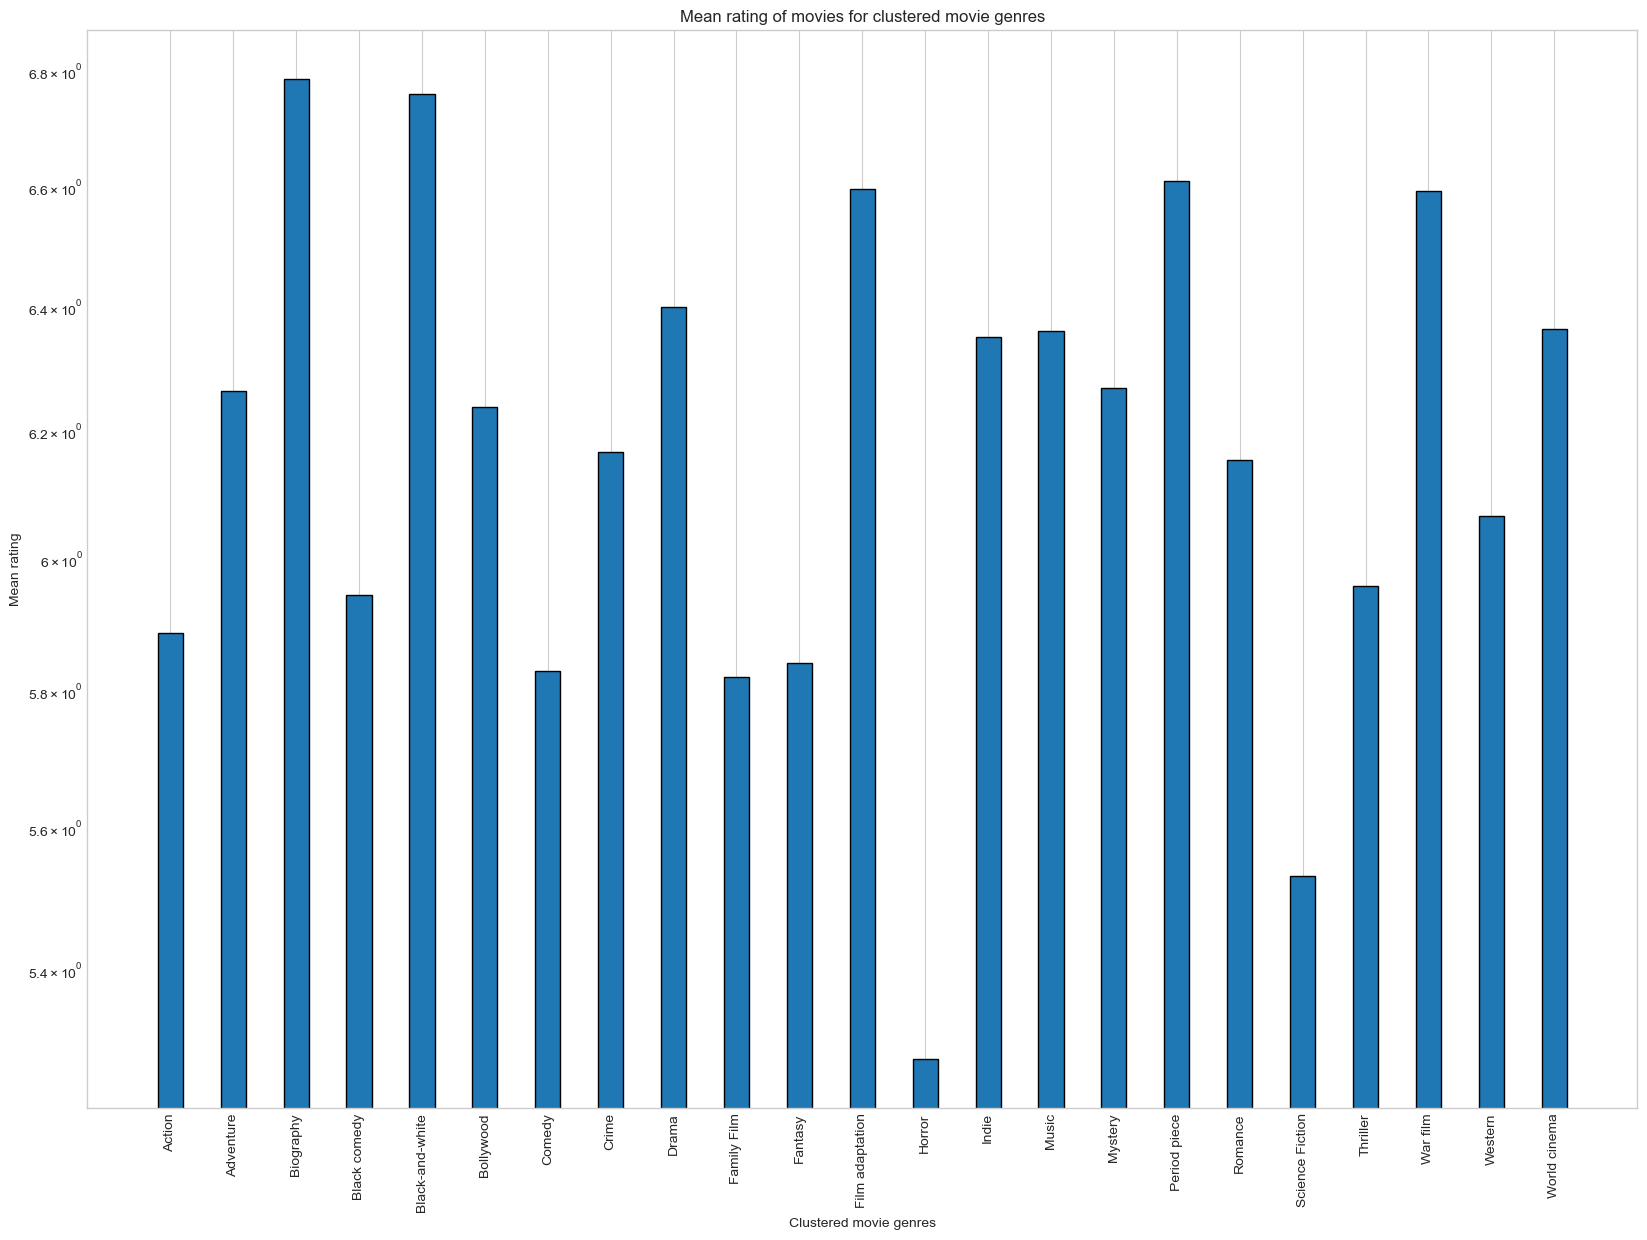

In [1827]:
# plot the mean rating per movie genre 
X_axis = np.arange(len(rating_per_genre.index))

plt.figure(figsize=(20,14))
plt.bar(rating_per_genre.Movie_genres, rating_per_genre['IMDb_rating'], 0.4, edgecolor = 'black')

plt.xticks(X_axis, rating_per_genre.Movie_genres, rotation=90)
plt.xlabel("Clustered movie genres")
plt.yscale('log')
plt.ylabel("Mean rating")
plt.title("Mean rating of movies for clustered movie genres")

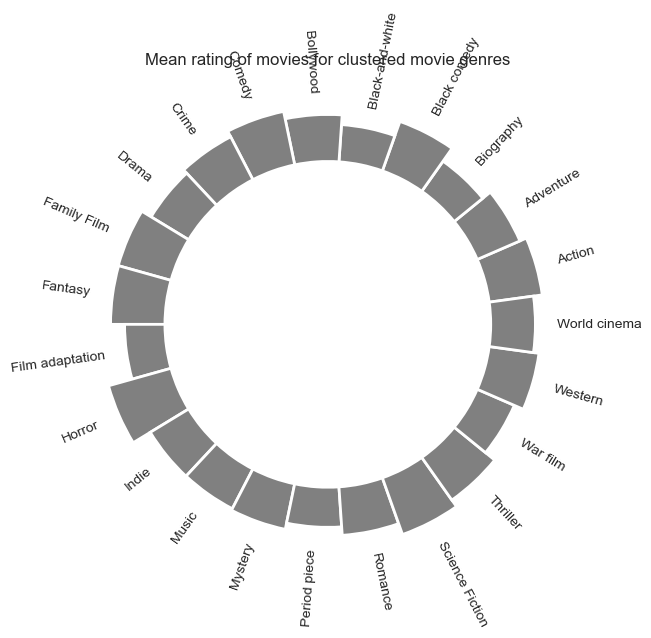

In [1857]:
# funnier vizualization - circular bar plot
# mean rating per clustered movie genre

# set figure size
plt.figure(figsize=(14,6))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = rating_per_genre['IMDb_rating'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * rating_per_genre['IMDb_rating'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(rating_per_genre.Movie_genres)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(rating_per_genre.Movie_genres)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    #cmap='rainbow',
    color='grey')

plt.title("Mean rating of movies for clustered movie genres")


# Set the labels
# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, rating_per_genre.Movie_genres):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

> We see mean rating vary between movies genres. We can now see if there is also a dependency on the sex of the main character, per movie genres.

In [1829]:
# plot the mean rating per movie genre for movie where main character is F and main character is M

# obtain IMDb rating and votes per year for both genders
rating_per_genre_gdr = movie_gender.groupby(['Movie_genres', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')

# the function pd.xs (feature, level=1) allows to extract the second column indices (here, main character gender) from a groupby
rating_per_genre_F = rating_per_genre_gdr.xs('F', level=1).rename(columns={"IMDb_rating": "IMDb_rating_F", "IMDb_votes": "IMDb_vote_F"})
rating_per_genre_M = rating_per_genre_gdr.xs('M', level=1).rename(columns={"IMDb_rating": "IMDb_rating_M", "IMDb_votes": "IMDb_vote_M"})

rating_per_genre_gender = pd.concat([rating_per_genre_F, rating_per_genre_M], axis=1)

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/3616576544.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_genre_gdr = movie_gender.groupby(['Movie_genres', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')


In [1830]:
rating_per_genre_gdr = rating_per_genre_gdr.reset_index()

In [1831]:
rating_per_genre_F

,IMDb_rating_F,IMDb_vote_F
Movie_genres,,
Action,5.657143,17810.017857
Adventure,6.215267,69328.992366
Biography,6.784921,52358.380952
Black comedy,5.828571,18870.897959
Black-and-white,6.800000,16792.757576
Bollywood,5.841379,4950.793103
Comedy,5.759459,19609.997543
Crime,6.083333,22803.584388
Drama,6.324742,13363.520046


In [1832]:
# we investigate the NaN values in the obtained data frame
rating_per_genre_gender['IMDb_rating_F'].isnull().values.any()

False

In [1833]:
rating_per_genre_gender['IMDb_rating_M'].isnull().values.any()

False

The NaN values are due to the fact that there are no main character of this gender for the looked at movie genre.
An idea could be to look at which movie genres have not had at least one feminine main character, and also for masculine main character.

In [1834]:
# we replace the Nan values by zeros, in order to be able to plot the data - no ratings is equivalent to a rating of zero
rating_per_genre_gender = rating_per_genre_gender.fillna(0).reset_index()

In [1835]:
rating_per_genre_gender

,Movie_genres,IMDb_rating_F,IMDb_vote_F,IMDb_rating_M,IMDb_vote_M
0,Action,5.657143,17810.017857,5.955570,23329.511936
1,Adventure,6.215267,69328.992366,6.283051,99631.144068
2,Biography,6.784921,52358.380952,6.785887,51913.052419
3,Black comedy,5.828571,18870.897959,6.000000,16598.904762
4,Black-and-white,6.800000,16792.757576,6.740909,17389.848485
5,Bollywood,5.841379,4950.793103,6.527500,4511.275000
6,Comedy,5.759459,19609.997543,5.871742,24724.300146
7,Crime,6.083333,22803.584388,6.204615,46318.008654
8,Drama,6.324742,13363.520046,6.454427,18082.847279
9,Family Film,5.888034,18932.897436,5.782857,25318.600000


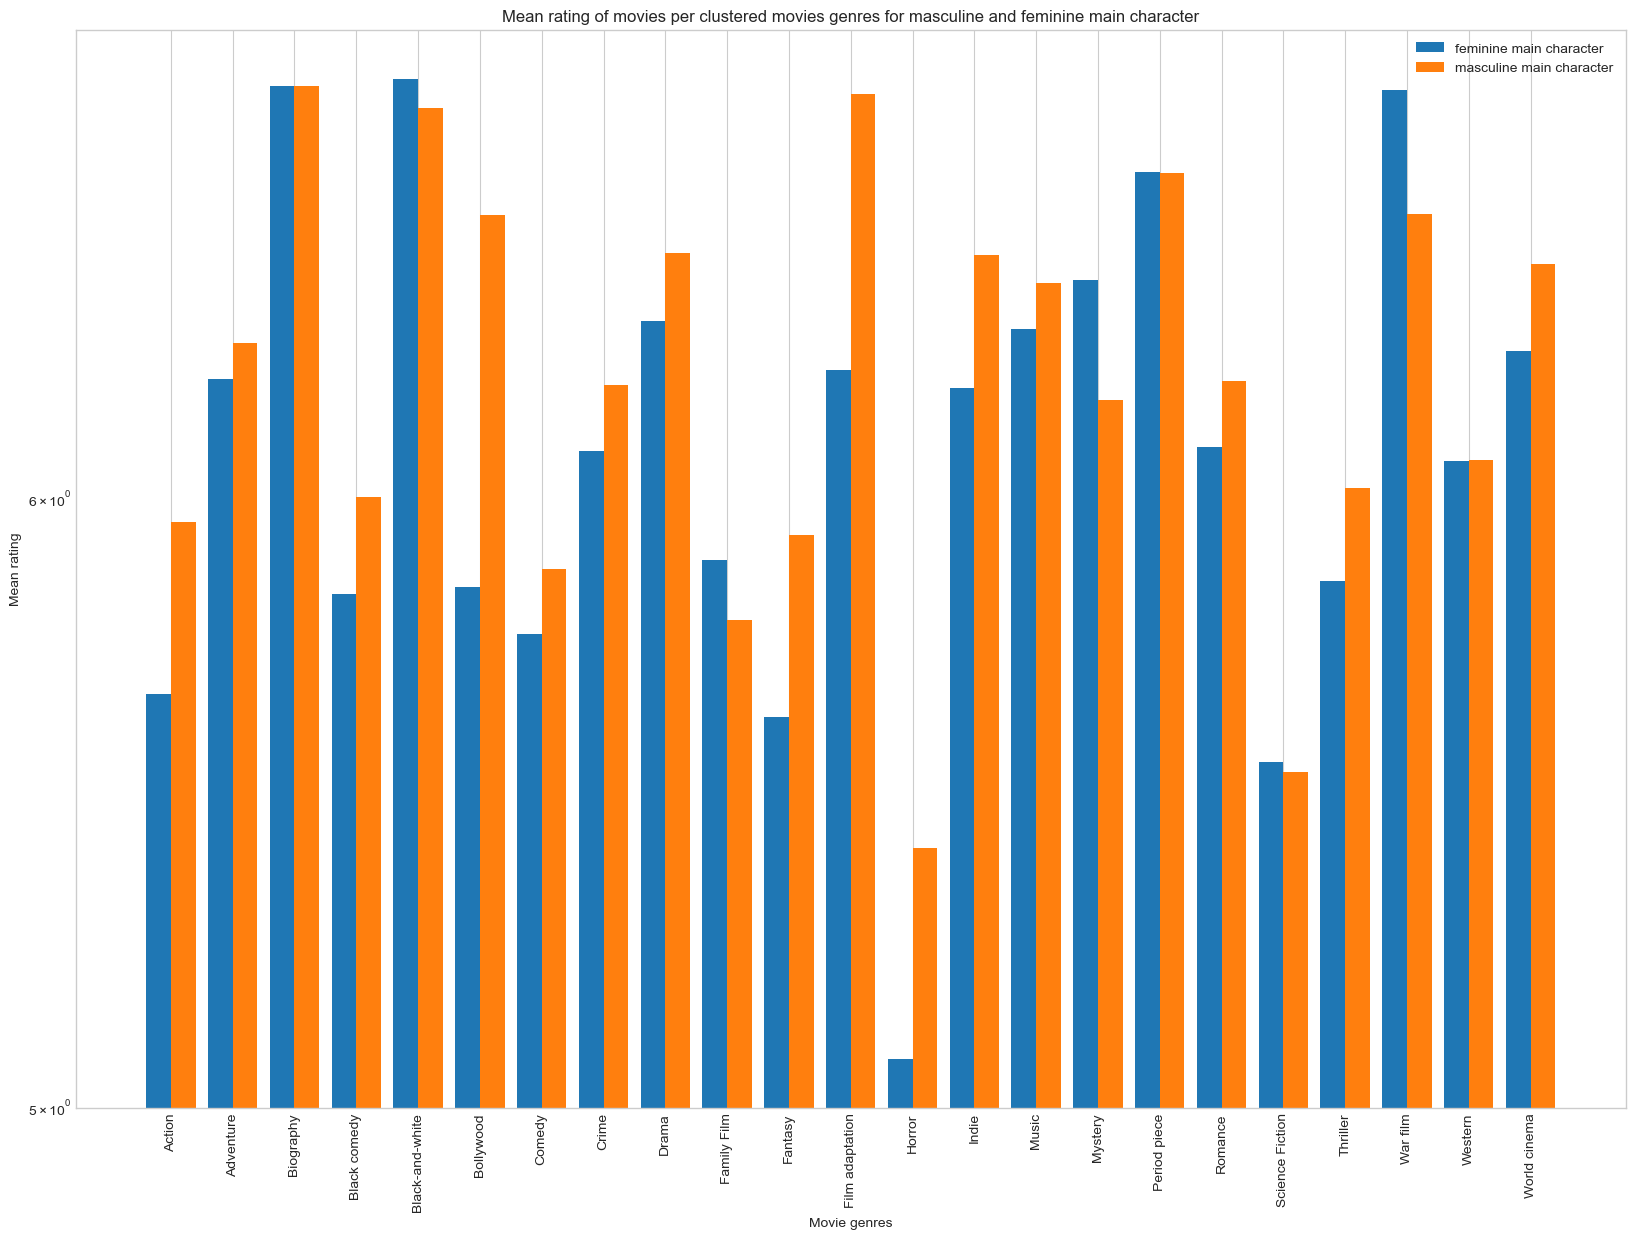

In [1836]:
# plot the mean IMDb_rating per movie genres for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(rating_per_genre_gender.Movie_genres))

plt.figure(figsize=(20,14))
plt.bar(X_axis - 0.2, rating_per_genre_gender['IMDb_rating_F'], 0.4, label = 'feminine main character') # doesn't plot lables!!
plt.bar(X_axis + 0.2, rating_per_genre_gender['IMDb_rating_M'], 0.4, label = 'masculine main character')

 
plt.xticks(X_axis, rating_per_genre_gender.Movie_genres, rotation=90)
plt.xlabel("Movie genres")
plt.ylabel("Mean rating")
plt.yscale('log')
plt.title("Mean rating of movies per clustered movies genres for masculine and feminine main character")
plt.legend(loc='best')



> From plot, we see the ratings change in function of the movie genres, and can also be dependant on the gender of the main character. In general, the mean rating is always (even a little bit) higher for movies where the main character is a man.

> As we could have expected, 'Action' movie genres experience a very large rating gap depending on the main character gender similarly to 'Thriller' movies, while this gap is reduced for 'Drama' and 'Romance' movies.

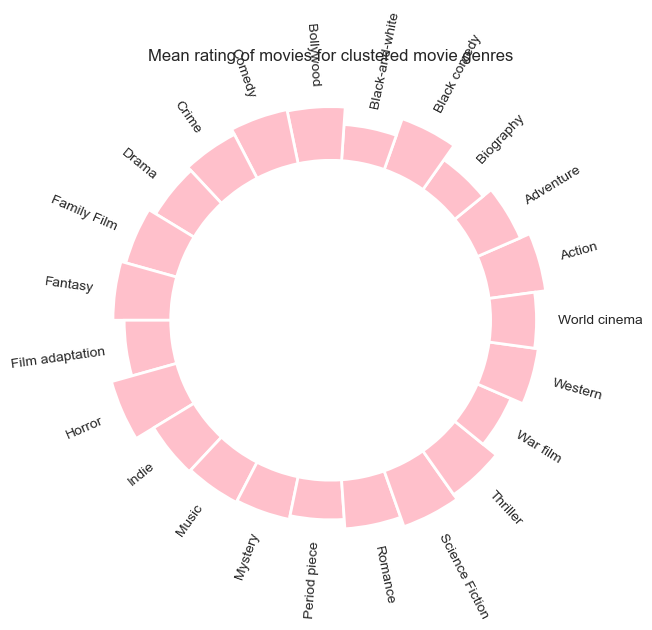

In [1859]:
# funnier vizualization - circular bar plot

# set figure size
plt.figure(figsize=(14,6))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = rating_per_genre_gender['IMDb_rating_F'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * rating_per_genre_gender['IMDb_rating_F'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(rating_per_genre_gender.Movie_genres)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(rating_per_genre_gender.Movie_genres)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    #cmap='rainbow',
    color='pink')

plt.title("Mean rating of movies with female main character for clustered movie genres")


# Set the labels
# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, rating_per_genre.Movie_genres):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

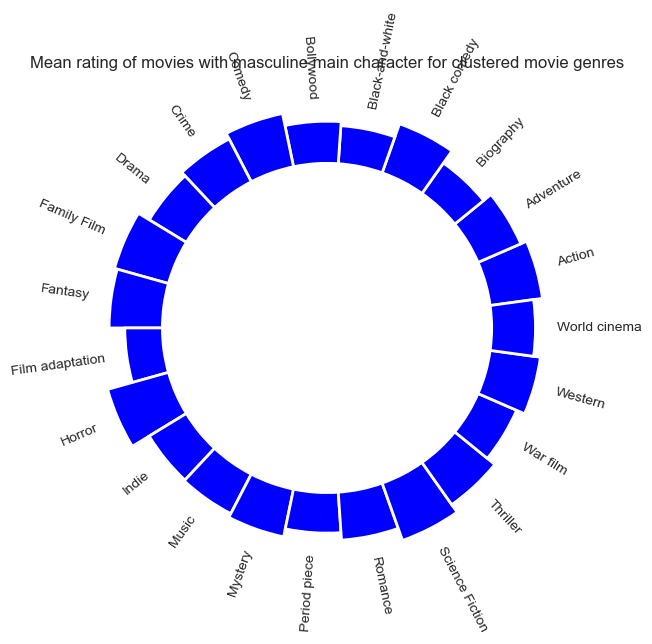

In [1861]:
# funnier vizualization - circular bar plot

# set figure size
plt.figure(figsize=(14,6))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = rating_per_genre_gender['IMDb_rating_M'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * rating_per_genre_gender['IMDb_rating_M'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(rating_per_genre_gender.Movie_genres)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(rating_per_genre_gender.Movie_genres)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    #cmap='rainbow',
    color='blue')

plt.title("Mean rating of movies with masculine main character for clustered movie genres")


# Set the labels
# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, rating_per_genre.Movie_genres):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

In [1837]:
"""
ANGLES = np.linspace(0, 2 * np.pi, len(rating_per_genre_gender), endpoint=False)
VALUES = rating_per_genre_gdr["IMDb_rating"].values
LABELS = rating_per_genre_gdr["Movie_genres"].values

# Determine the width of each bar. 
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

# Specify offset
ax.set_theta_offset(OFFSET)

# Set limits for radial (y) axis. The negative lower bound creates the whole in the middle.
ax.set_ylim(-100, 100)

# Remove all spines
ax.set_frame_on(False)

# Remove grid and tick marks
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add bars
ax.bar(
    ANGLES, VALUES, width=WIDTH, linewidth=2,
    color="#61a4b2", edgecolor="white"
)

# Add labels
add_labels(ANGLES, VALUES, LABELS, OFFSET, ax)

# 3 empty bars are added 
PAD = 3
ANGLES_N = len(VALUES) + PAD
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# The index contains non-empty bards
IDXS = slice(0, ANGLES_N - PAD)

# The layout customization is the same as above
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Add bars, subsetting angles to use only those that correspond to non-empty bars
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color="#61a4b2", 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)


# Grab the group values
GROUP = rating_per_genre_gdr["Main_character_gender"].values

# Add three empty bars to the end of each group
PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [10, 20, 12, 8]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Same layout as above
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
GROUPS_SIZE = [10, 20, 12, 8]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)
"""

'\nANGLES = np.linspace(0, 2 * np.pi, len(rating_per_genre_gender), endpoint=False)\nVALUES = rating_per_genre_gdr["IMDb_rating"].values\nLABELS = rating_per_genre_gdr["Movie_genres"].values\n\n# Determine the width of each bar. \n# The circumference is \'2 * pi\', so we divide that total width over the number of bars.\nWIDTH = 2 * np.pi / len(VALUES)\n\n# Determines where to place the first bar. \n# By default, matplotlib starts at 0 (the first bar is horizontal)\n# but here we say we want to start at pi/2 (90 deg)\nOFFSET = np.pi / 2\n\n# Initialize Figure and Axis\nfig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})\n\n# Specify offset\nax.set_theta_offset(OFFSET)\n\n# Set limits for radial (y) axis. The negative lower bound creates the whole in the middle.\nax.set_ylim(-100, 100)\n\n# Remove all spines\nax.set_frame_on(False)\n\n# Remove grid and tick marks\nax.xaxis.grid(False)\nax.yaxis.grid(False)\nax.set_xticks([])\nax.set_yticks([])\n\n# Add bars\nax.b

##### Compare rating in function of the **movie release year** between male and female of main characters

In [1838]:
# extract movie release year for each movie
movie_gender['Movie_release_year'] = movie_gender['Movie_release_date'].dt.year 

# extract mean rating per year
rating_per_year = movie_gender.groupby('Movie_release_year')['IMDb_rating','IMDb_votes'].agg('mean')

rating_per_year

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/3488371974.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_year = movie_gender.groupby('Movie_release_year')['IMDb_rating','IMDb_votes'].agg('mean')


,IMDb_rating,IMDb_votes
Movie_release_year,,
1906.0,7.300000,318.000000
1908.0,6.400000,3244.333333
1910.0,6.366667,1121.666667
1911.0,5.700000,4045.500000
1912.0,5.100000,537.000000
...,...,...
2010.0,5.851739,56071.563043
2011.0,5.841915,53985.846809
2012.0,5.937269,85741.918819


Text(0.5, 1.0, 'Mean rating of movies per release year')

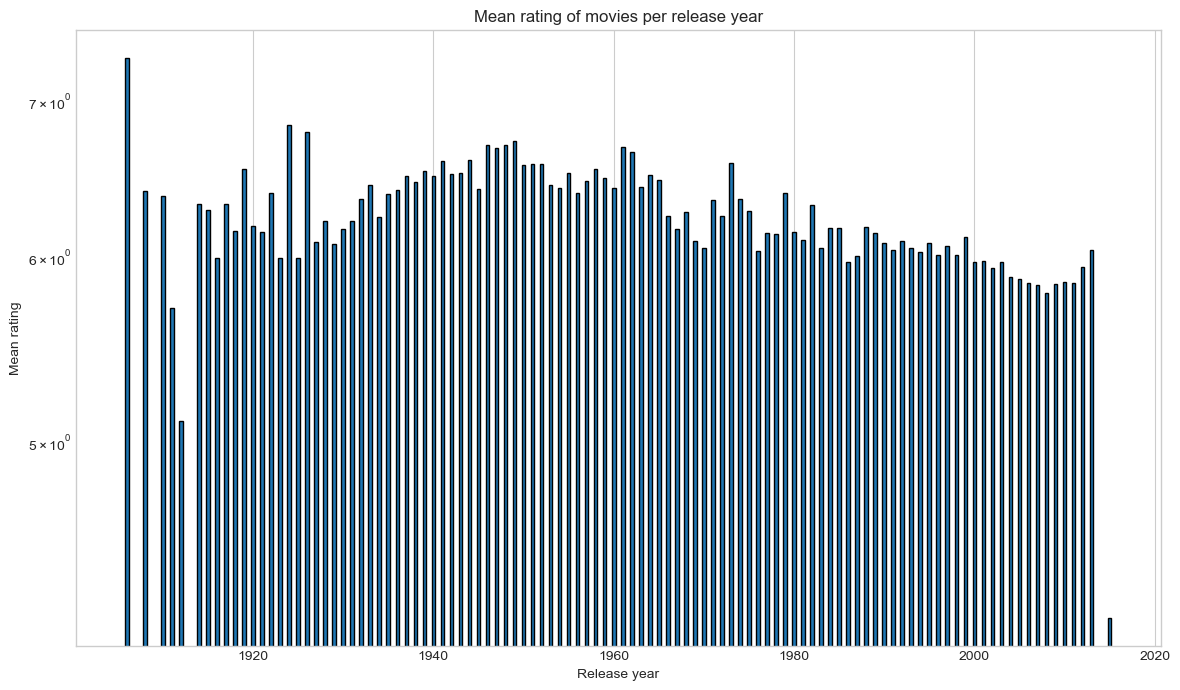

In [1839]:
# plot the mean rating per movie release year 

plt.figure(figsize=(14,8))
plt.bar(rating_per_year.index, rating_per_year['IMDb_rating'], 0.4, edgecolor = 'black')

plt.xlabel("Release year")
plt.yscale('log')
plt.ylabel("Mean rating")
plt.title("Mean rating of movies per release year")


> Between 1929 and 1940, there are outliers (very small values). This can be explained to big innovation that saw the light from 1926-1927: notably the transition to sound-on-film technology, which marks the end of the silent-film era and the first animation movie. Those were the first of their types and the technologies might have taken a decade to improve to acceptable standards and it may also have taken some time for people to get used to it. 

In [1840]:

# we decide to plot on 10 years period in order to have cleaner and more observable data

# Assign each row to a period
rating_per_year_grP = movie_gender
rating_per_year_grP['PERIOD'] = pd.cut(rating_per_year_grP['Movie_release_year'], bins=period_bins, include_lowest=True, precision=0)
rating_per_year_grP['PERIOD'] = rating_per_year_grP['PERIOD'].astype("str")
rating_per_year_grP = rating_per_year_grP.replace(label_dict)

rating_per_year_grP = movie_gender.groupby('PERIOD').mean().dropna().reset_index()
rating_per_year_grP

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/1205703429.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rating_per_year_grP = movie_gender.groupby('PERIOD').mean().dropna().reset_index()


,PERIOD,IMDb_rating,IMDb_votes,F,M,Movie_release_year
0,"[1926, 1936)",6.288603,2724.209559,2.691176,5.027574,1931.762868
1,"[1936, 1946)",6.502023,7241.293300,2.059418,4.185841,1940.359039
2,"[1946, 1956)",6.577074,7568.351528,2.158297,3.945415,1950.786026
3,"[1956, 1966)",6.496530,10764.218717,2.112513,4.323870,1960.388013
4,"[1966, 1976)",6.256970,15814.688662,2.015799,4.191450,1970.485130
5,"[1976, 1986)",6.166691,23568.047372,2.327905,4.859363,1980.963731
6,"[1986, 1996)",6.067782,33819.582427,2.366946,4.760251,1990.757322
7,"[1996, 2006)",5.970724,46829.432492,3.680621,6.704186,2000.793180
8,"[2006, 2014)",5.842998,56386.392199,4.478194,7.691646,2008.796069
9,nan,5.847826,5624.021739,3.746377,8.195652,1920.605042


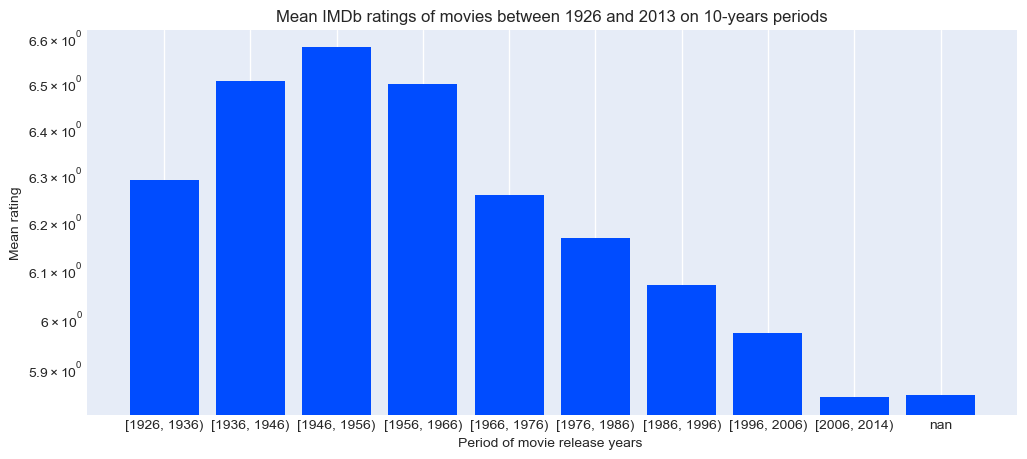

In [1841]:
fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(5)
fig.patch.set_facecolor('white')
plt.bar(rating_per_year_grP['PERIOD'], rating_per_year_grP['IMDb_rating'], color='#004cff')
plt.title(f"Mean IMDb ratings of movies between {start_year} and {end_year} on 10-years periods")
plt.xlabel("Period of movie release years ") 
plt.ylabel("Mean rating") 
plt.yscale('log')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
#plt.locator_params(axis='y', nbins=9)

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

> We clearly see a decreasing trend in the ratings of movies from 1940s. This can be due to the fact that more and more films are produced, and statistically, more and more films are less qualitative. Also, there is more room to creation and unicity with time, so every one will like special types of movies.

> As IMDb (and Internet) are pretty new tools on the studied time period, it is logical that there are much more votes on more recent films than old ones (about 100x more). We could thus ponderate the rating by the number of votes to have a real notion of appreciation from people.

In [1842]:
# obtain IMDb rating and votes per year for both genders
rating_per_year_gender = movie_gender.groupby(['Movie_release_year', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')

# the function pd.xs (feature, level=1) allows to extract the second column indices (here, main character gender) from a groupby
rating_per_year_F = rating_per_year_gender.xs('F', level=1).rename(columns={"IMDb_rating": "IMDb_rating_F", "IMDb_votes": "IMDb_vote_F"})
rating_per_year_M = rating_per_year_gender.xs('M', level=1).rename(columns={"IMDb_rating": "IMDb_rating_M", "IMDb_votes": "IMDb_vote_M"})

rating_per_year_gender = pd.concat([rating_per_year_F, rating_per_year_M], axis=1)

rating_per_year_gender

/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/174806093.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_per_year_gender = movie_gender.groupby(['Movie_release_year', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean')


,IMDb_rating_F,IMDb_vote_F,IMDb_rating_M,IMDb_vote_M
Movie_release_year,,,,
1908.0,5.200000,66.000000,7.000000,4833.500000
1910.0,6.300000,1312.500000,6.500000,740.000000
1911.0,6.100000,147.000000,5.300000,7944.000000
1912.0,5.100000,537.000000,NaN,NaN
1914.0,7.000000,41.500000,5.866667,840.000000
...,...,...,...,...
2011.0,5.760571,48126.068571,5.890169,57461.986441
2012.0,5.821649,61025.783505,6.001724,99520.454023
2013.0,5.858333,158993.500000,6.110714,204142.107143


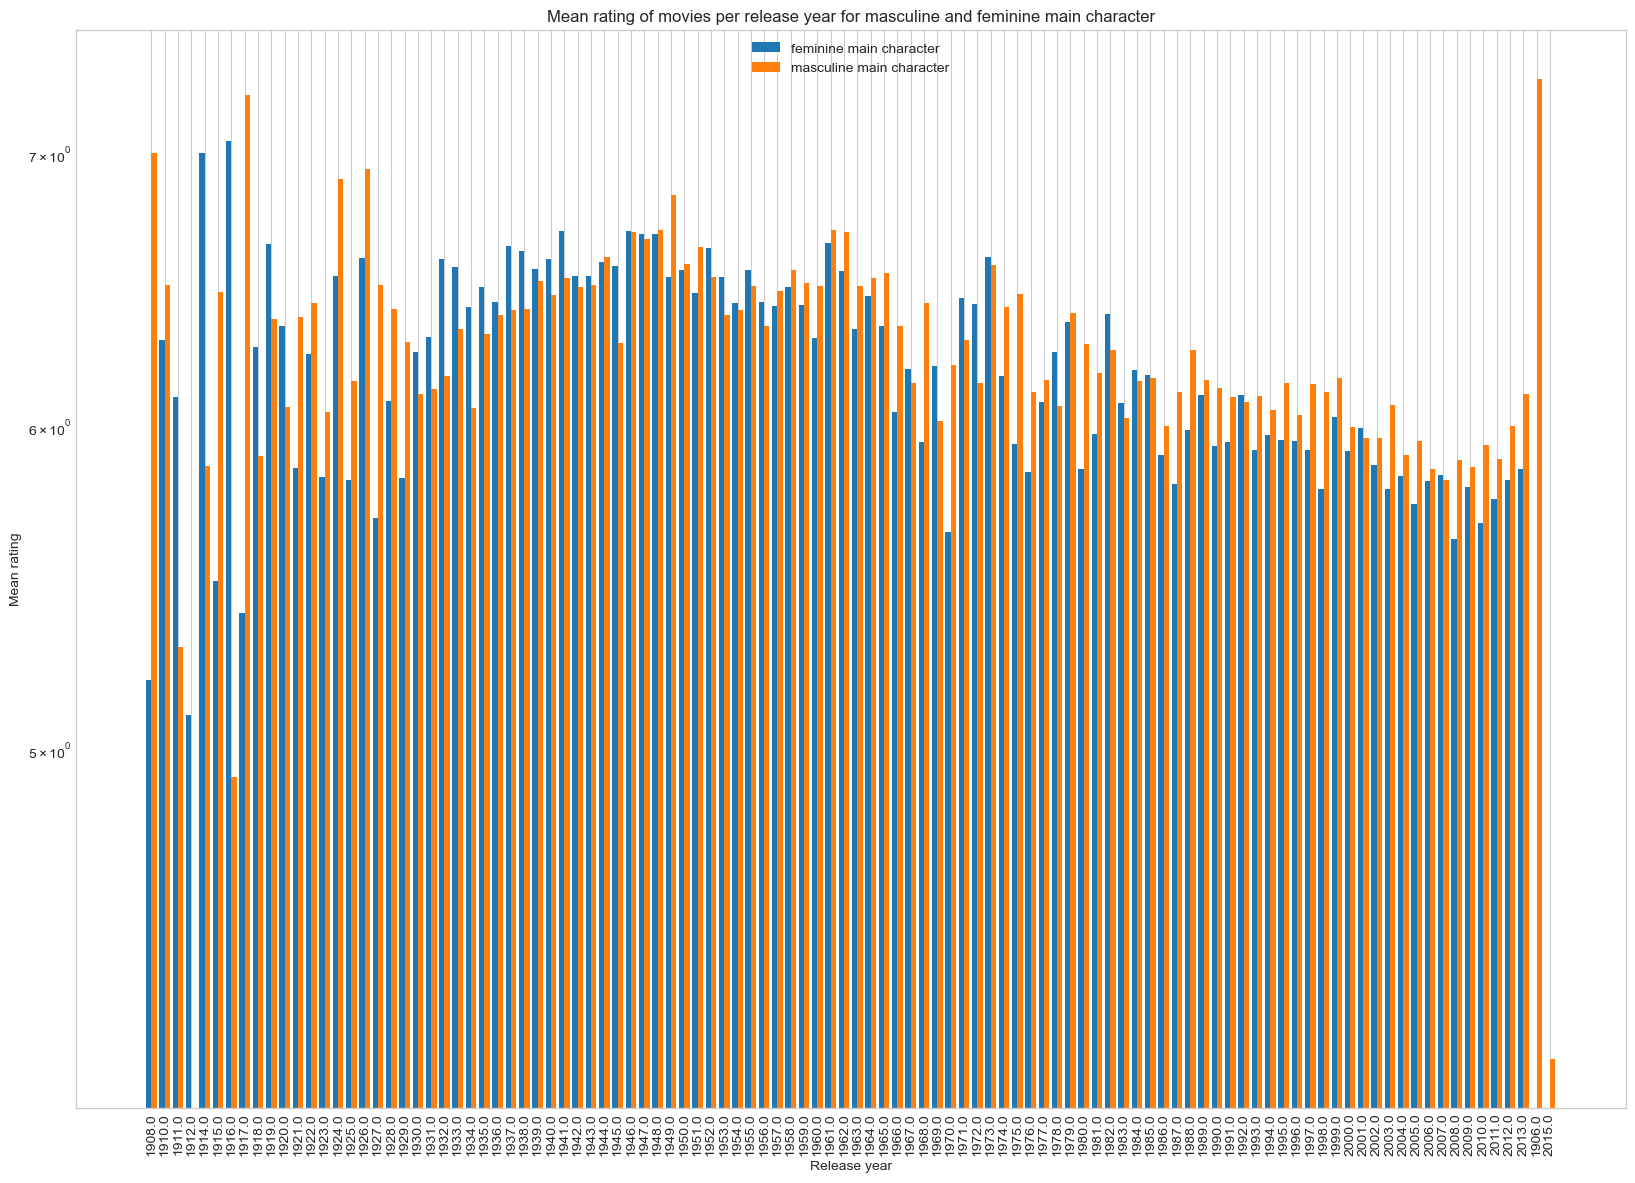

In [1843]:
# plot the mean IMDb_rating per movie release year for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(rating_per_year_gender.index))

plt.figure(figsize=(20,14))
plt.bar(X_axis - 0.2, rating_per_year_gender['IMDb_rating_F'], 0.4, label = 'feminine main character') # doesn't plot lables!!
plt.bar(X_axis + 0.2, rating_per_year_gender['IMDb_rating_M'], 0.4, label = 'masculine main character')

 
plt.xticks(X_axis, rating_per_year_gender.index, rotation=90)
plt.xlabel("Release year")
plt.ylabel("Mean rating")
plt.yscale('log')
plt.title("Mean rating of movies per release year for masculine and feminine main character")
plt.legend(loc='best')


> Overall, we tend to see the same trends for both gender and also a similar trend as in the plot not by gender.
Between 1929-1939 approximately, we see that ratings for movies where the main character is a woman are way higher than when main character is a man. During this period, we saw on the general plot that ratings were very low overall. Looking at the votes in this period, there are more votes for feminine main character (twice as much) than for masculine main character. This period is thus not significant for the analysis of the evolution of the ratings for movies biased by the gender gap.

We decided to perform a linear regression on the period 1950-2013, in order to have a more precise and observable data, as well as to potentially observe a trend in the data.

In [1844]:
rating_per_year_gender

,IMDb_rating_F,IMDb_vote_F,IMDb_rating_M,IMDb_vote_M
Movie_release_year,,,,
1908.0,5.200000,66.000000,7.000000,4833.500000
1910.0,6.300000,1312.500000,6.500000,740.000000
1911.0,6.100000,147.000000,5.300000,7944.000000
1912.0,5.100000,537.000000,NaN,NaN
1914.0,7.000000,41.500000,5.866667,840.000000
...,...,...,...,...
2011.0,5.760571,48126.068571,5.890169,57461.986441
2012.0,5.821649,61025.783505,6.001724,99520.454023
2013.0,5.858333,158993.500000,6.110714,204142.107143


In [1845]:
rating_per_year_gender = rating_per_year_gender[(rating_per_year_gender.index >= 1950) & (rating_per_year_gender.index <= 2013)].reset_index()

In [1846]:
rating_per_year_gender

,Movie_release_year,IMDb_rating_F,IMDb_vote_F,IMDb_rating_M,IMDb_vote_M
0,1950.0,6.554054,5831.513514,6.574627,4245.358209
1,1951.0,6.471429,7708.342857,6.639216,16166.117647
2,1952.0,6.637500,12253.025000,6.530000,2838.516667
3,1953.0,6.526829,4568.780488,6.390141,7015.436620
4,1954.0,6.435135,4081.324324,6.408621,9782.431034
...,...,...,...,...,...
59,2009.0,5.798477,43258.395939,5.864610,56046.944805
60,2010.0,5.682051,32384.685897,5.938816,68226.671053
61,2011.0,5.760571,48126.068571,5.890169,57461.986441
62,2012.0,5.821649,61025.783505,6.001724,99520.454023


In [1847]:
# perform linear regression on main characters for each year
np.random.seed(1)

model_fem_year = smf.ols(formula='IMDb_rating_F ~ Movie_release_year', data=rating_per_year_gender).fit()
model_masc_year = smf.ols(formula='IMDb_rating_M ~ Movie_release_year', data=rating_per_year_gender).fit()

prediction_fem_1 = model_fem_year.predict(rating_per_year_gender)
prediction_masc_1 = model_masc_year.predict(rating_per_year_gender)

In [1848]:
print(model_fem_year.summary())

                            OLS Regression Results                            
Dep. Variable:          IMDb_rating_F   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     132.1
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           5.21e-17
Time:                        13:24:30   Log-Likelihood:                 26.146
No. Observations:                  64   AIC:                            -48.29
Df Residuals:                      62   BIC:                            -43.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             31.2967      2

> The "R-squared" value of 0.681 indicates that the model explains 68.1% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the null p-value indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is -0.0127, which suggests that for every unit increase in the year in which a movie is released, the rating for a movie with a female main character is expected to increase by -0.0127. The intercept term of 31.2967 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


In [1849]:
print(model_masc_year.summary())

                            OLS Regression Results                            
Dep. Variable:          IMDb_rating_M   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     170.9
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.78e-19
Time:                        13:24:30   Log-Likelihood:                 45.157
No. Observations:                  64   AIC:                            -86.31
Df Residuals:                      62   BIC:                            -82.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.5024      1

> The "R-squared" value of 0.734 indicates that the model explains 73.4% of the variance in the dependent variable. 

> The "F-statistic" and its associated "Prob (F-statistic)" value are used to test the overall significance of the model. In this case, the null p-value indicates that the model is highly significant.

> The coefficient for "Movie_release_year" is -0.0107, which suggests that for every unit increase in the year in which a movie is released, the rating for a movie with a male main character is expected to increase by -0.0107. The intercept term of 27.5024 represents the expected value of the dependent variable when the "Movie_release_year" variable is 0.


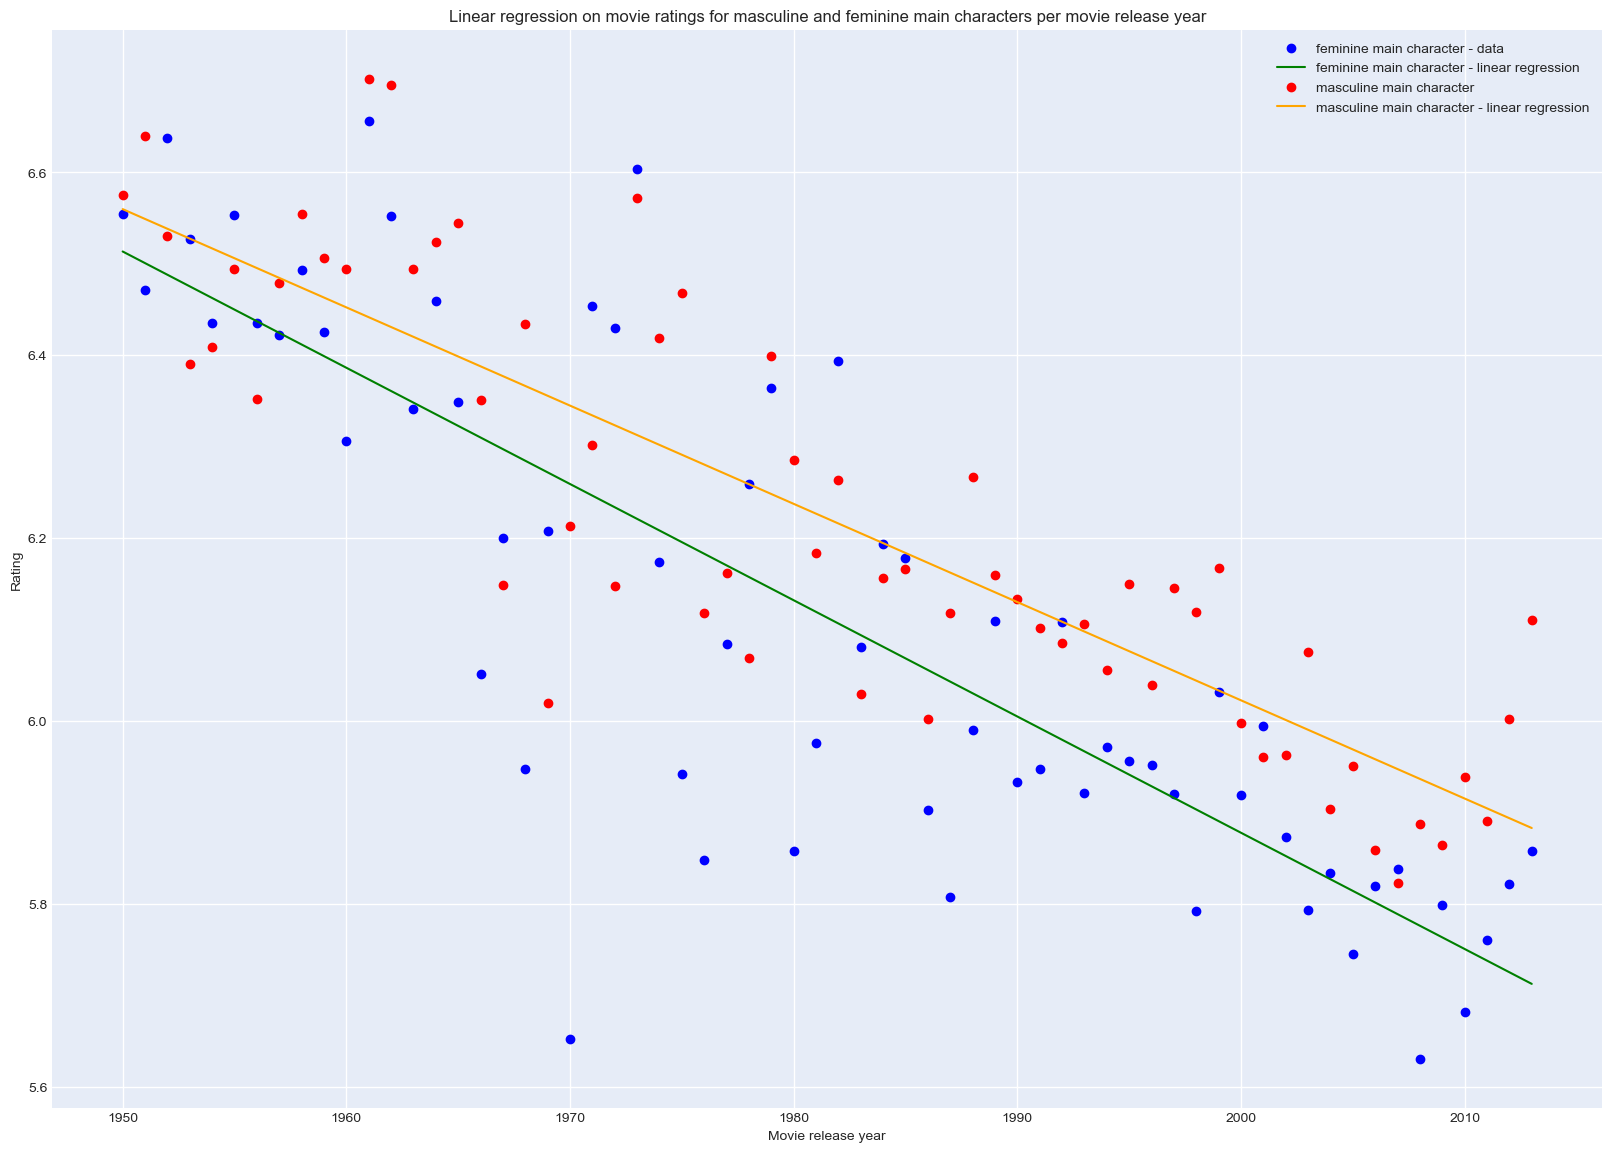

In [1850]:
# perform linear regression on ratings for F and M main characters for each year - between 1950 and 2013

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(rating_per_year_gender.Movie_release_year, rating_per_year_gender['IMDb_rating_F'], label = 'feminine main character - data', color='blue') 
plt.plot(rating_per_year_gender.Movie_release_year, prediction_fem_1, label = 'feminine main character - linear regression', color='green')

plt.scatter(rating_per_year_gender.Movie_release_year, rating_per_year_gender['IMDb_rating_M'], label = 'masculine main character', color='red')# doesn't plot lables!!
plt.plot(rating_per_year_gender.Movie_release_year, prediction_masc_1, label = 'masculine main character - linear regression', color='orange')

plt.title('Linear regression on movie ratings for masculine and feminine main characters per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Rating")
plt.xlabel("Movie release year")
#plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

> From plot, we observe the ratings for movies where women are main characters decrease faster through the years than ratings for movies whith male main character. We have to look at the ratio of ratings between groups as they are not similar in term of confounders: the number of released movie each year and the number of votes. 

> On average, number of votes for male main character movies is higher. But this is logical as there are more movie of this type released each year.

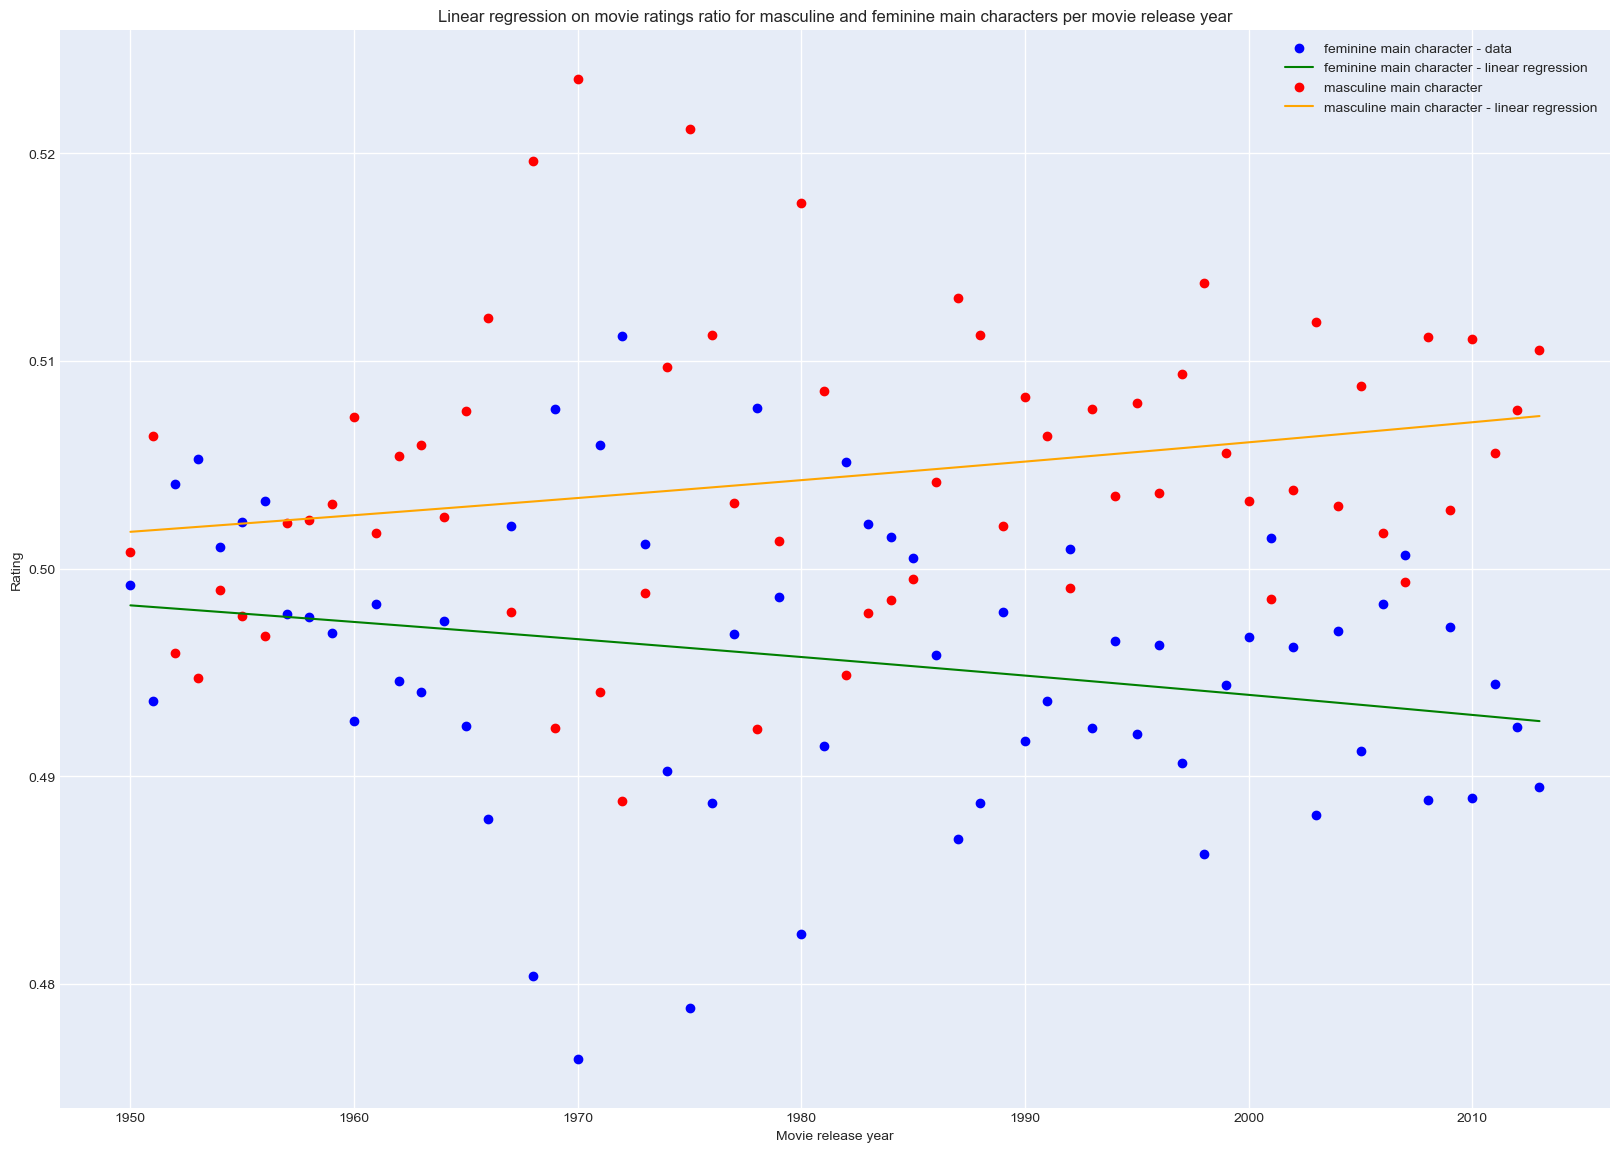

In [1851]:
# perform linear regression on ratings ratio for F and M main characters for each year - between 1950 and 2013

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.scatter(rating_per_year_gender.Movie_release_year, rating_per_year_gender['IMDb_rating_F']/(rating_per_year_gender['IMDb_rating_F']+rating_per_year_gender['IMDb_rating_M']), label = 'feminine main character - data', color='blue') 
plt.plot(rating_per_year_gender.Movie_release_year, prediction_fem_1/(prediction_fem_1+prediction_masc_1), label = 'feminine main character - linear regression', color='green')

plt.scatter(rating_per_year_gender.Movie_release_year, rating_per_year_gender['IMDb_rating_M']/(rating_per_year_gender['IMDb_rating_F']+rating_per_year_gender['IMDb_rating_M']), label = 'masculine main character', color='red')# doesn't plot lables!!
plt.plot(rating_per_year_gender.Movie_release_year, prediction_masc_1/(prediction_fem_1+prediction_masc_1), label = 'masculine main character - linear regression', color='orange')

plt.title('Linear regression on movie ratings ratio for masculine and feminine main characters per movie release year')
plt.legend(['Data - original','Linear regression - original','Data - fitted','Linear regression - fitted'])
plt.ylabel("Rating")
plt.xlabel("Movie release year")
#plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

> From the second linear regression (above plot), we indeed see in terms of ratio between ratings that the gap increases. Movies whith male main character are highly rated on average, we could conclude viewers like to see better a man than a woman on screen as the lead of a movie.

In [1852]:
movie_gender = movie_gender[(movie_gender.Movie_release_year <= 2013)]

In [1853]:
# Plot ratings by period
# Assign each row to a period
rating_per_year_gender_grP = movie_gender
rating_per_year_gender_grP['PERIOD'] = pd.cut(rating_per_year_gender_grP['Movie_release_year'], bins=period_bins, include_lowest=True, precision=0)
rating_per_year_gender_grP['PERIOD'] = rating_per_year_gender_grP['PERIOD'].astype("str")
rating_per_year_gender_grP = rating_per_year_gender_grP.replace(label_dict)

rating_per_year_gender_grP = movie_gender.groupby(['PERIOD', 'Main_character_gender'])['IMDb_rating','IMDb_votes'].agg('mean').dropna().reset_index()
rating_per_year_gender_grP


/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/2869913163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_per_year_gender_grP['PERIOD'] = pd.cut(rating_per_year_gender_grP['Movie_release_year'], bins=period_bins, include_lowest=True, precision=0)
/var/folders/f4/b7ft2_n14dsbh5_k5kt37m0m0000gn/T/ipykernel_27889/2869913163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_per_year_gender_grP['PERIOD'] = rating_per_year_gender_grP['PERIOD'].astype("str")
/var/folders/f4/b7

,PERIOD,Main_character_gender,IMDb_rating,IMDb_votes
0,"[1926, 1936)",F,6.341772,2235.666667
1,"[1926, 1936)",M,6.247557,3101.358306
2,"[1936, 1946)",F,6.576978,6467.830935
3,"[1936, 1946)",M,6.461404,7660.440546
4,"[1946, 1956)",F,6.574412,5829.423529
5,"[1946, 1956)",M,6.578646,8594.802083
6,"[1956, 1966)",F,6.439181,8513.038012
7,"[1956, 1966)",M,6.528736,12028.428571
8,"[1966, 1976)",F,6.157265,11241.888889
9,"[1966, 1976)",M,6.305241,18028.554483


In [1854]:
# Obtain dataframe with column for M ratings and for F ratings
rating_per_year_grP_F = rating_per_year_gender_grP[rating_per_year_gender_grP['Main_character_gender'] == 'F'].rename(columns={"IMDb_rating": "IMDb_rating_F", "IMDb_votes": "IMDb_vote_F"})
rating_per_year_grP_M = rating_per_year_gender_grP[rating_per_year_gender_grP['Main_character_gender'] == 'M'].rename(columns={"IMDb_rating": "IMDb_rating_M", "IMDb_votes": "IMDb_vote_M"})

rating_per_year_gender_grP = rating_per_year_grP_F.merge( rating_per_year_grP_M, how='left', on='PERIOD')

rating_per_year_gender_grP

,PERIOD,Main_character_gender_x,IMDb_rating_F,IMDb_vote_F,Main_character_gender_y,IMDb_rating_M,IMDb_vote_M
0,"[1926, 1936)",F,6.341772,2235.666667,M,6.247557,3101.358306
1,"[1936, 1946)",F,6.576978,6467.830935,M,6.461404,7660.440546
2,"[1946, 1956)",F,6.574412,5829.423529,M,6.578646,8594.802083
3,"[1956, 1966)",F,6.439181,8513.038012,M,6.528736,12028.428571
4,"[1966, 1976)",F,6.157265,11241.888889,M,6.305241,18028.554483
5,"[1976, 1986)",F,6.133405,24919.835118,M,6.184276,22853.924208
6,"[1986, 1996)",F,5.966545,27442.922141,M,6.120855,37162.448980
7,"[1996, 2006)",F,5.876187,37878.529674,M,6.027136,52170.652944
8,"[2006, 2014)",F,5.766378,42483.930709,M,5.891994,65276.687311
9,nan,F,6.161224,628.714286,M,6.333333,1298.217391


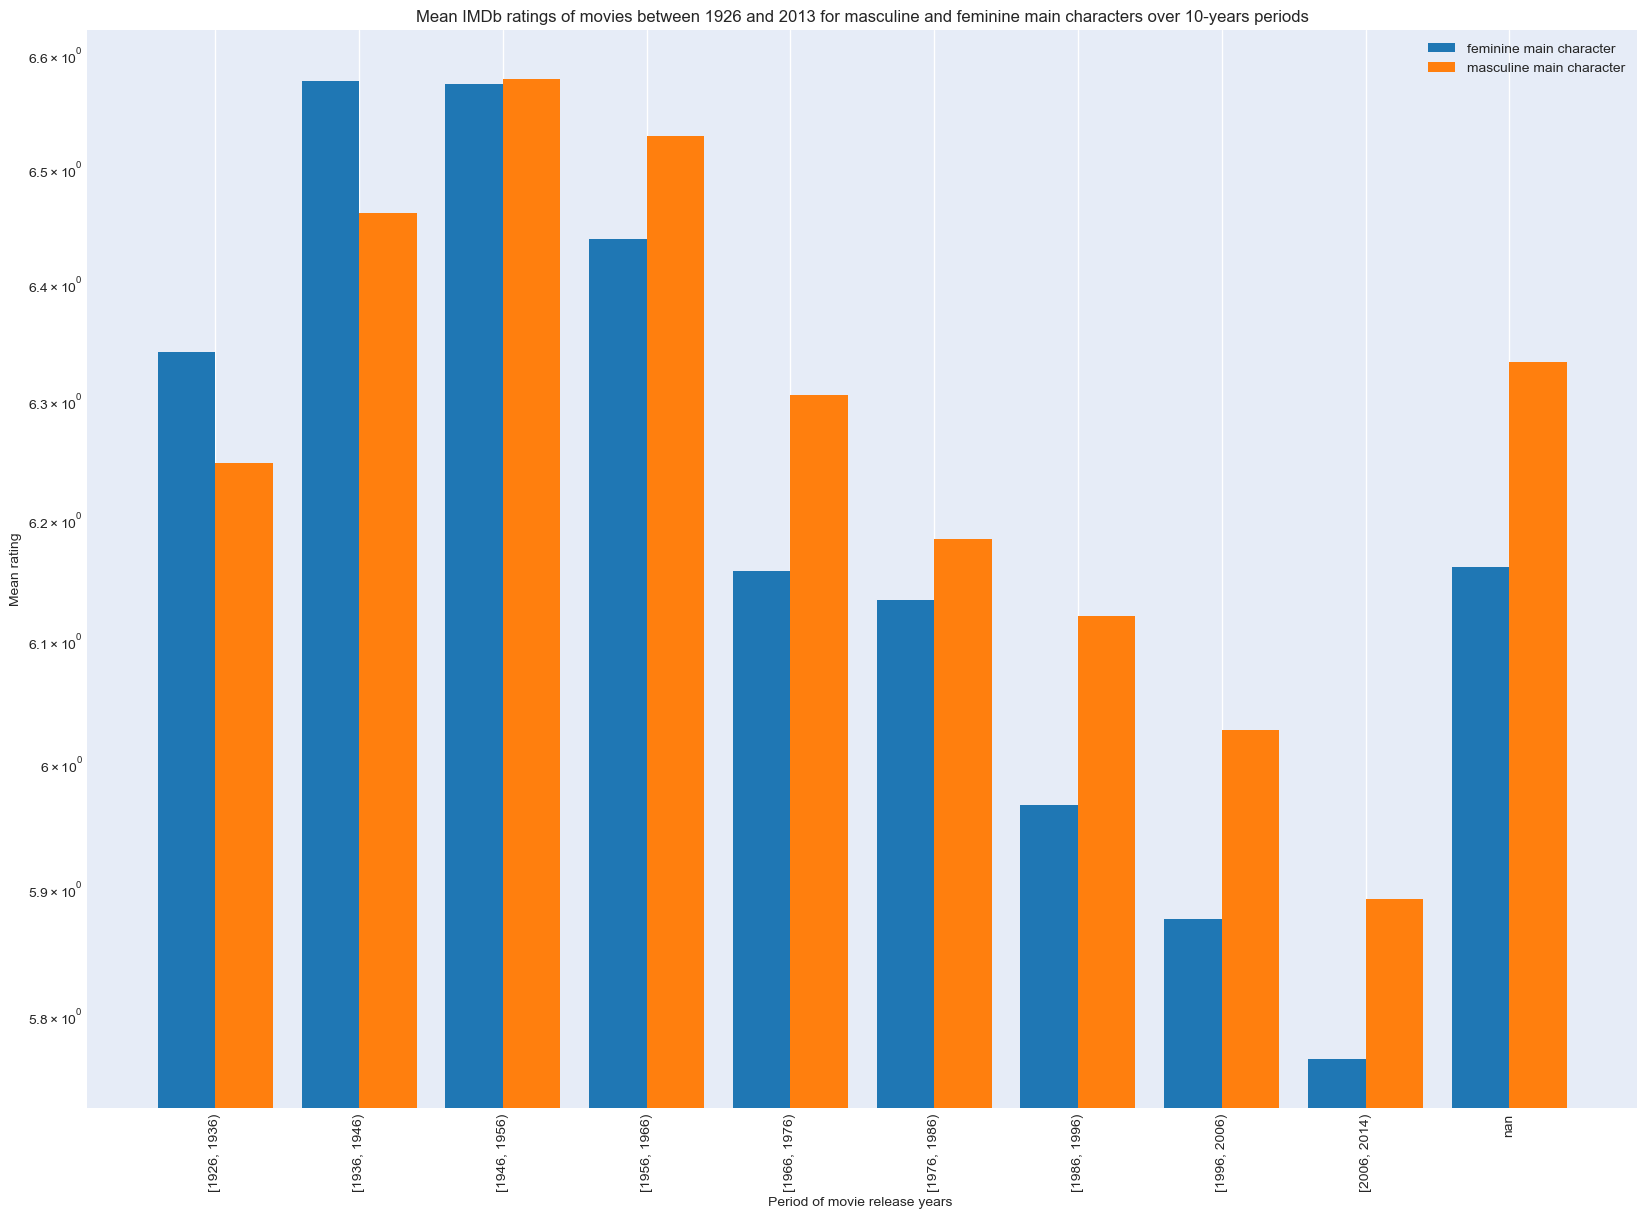

In [1855]:
# plot the mean IMDb_rating per period of movie release for movie where main_character_gender is F and main_character_gender is M
X_axis = np.arange(len(rating_per_year_gender_grP.index))

fig = plt.figure(figsize=(20,14))
fig.patch.set_facecolor('white')
plt.bar(X_axis - 0.2, rating_per_year_gender_grP['IMDb_rating_F'], 0.4, label = 'feminine main character') # doesn't plot lables!!
plt.bar(X_axis + 0.2, rating_per_year_gender_grP['IMDb_rating_M'], 0.4, label = 'masculine main character')

plt.xticks(X_axis, rating_per_year_gender_grP['PERIOD'], rotation=90)
plt.title(f"Mean IMDb ratings of movies between {start_year} and {end_year} for masculine and feminine main characters over 10-years periods")
plt.xlabel("Period of movie release years ") 
plt.ylabel("Mean rating") 
plt.yscale('log')
plt.legend(loc='best')

# Styling of the plot
plt.grid(color = 'white', linewidth = 1)
plt.locator_params(axis='y')

# Styling of the axes
ax = plt.gca()
ax.set_facecolor('#e6ecf7')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.show()



> From the mid-30s, there was a code and law enforcement at Hollywood to show good behaviour on screen. But in the years before that, woman were very free on screen and showed as powerful characters. There was thus a period were women were very present on screen. On average from given datasets, there were more women main characters than men before 1933 (but on very few movies). As we only have very few data for this period, we can not conclude anything. (https://lionessmagazine.com/strong-women-in-film-the-1930s-40s-and-50s/)

### iii. Is the work of women in general (other fields than acting) less/at the same level/more appreciated than the work of men? (using Oscar nominees for all jobs)

#### Compare all the Oscars nominees for all categories

#### Do an overall linear regression

## D. How do women interact, with other women and with men? <a name="Interaction"> </a>

### i. Use Bechdel tests dataset with movie dataset

#### Merge Bechdel tests dataset with movie dataset

#### Check evolution of Bechdel score through time

#### For what kind of movie is the Bechdel score the highest?

#  4. Conclusion <a id="Conclusion"> </a>

## Compare our approach and results with the Bechdel score

## General conclusion on evolution of gender gap in the film industry

## Impact of the METOO movement?